# ML Anomaly Detection

**Author:** _Juan David Lara Camacho_

> This notebook follows a structured end‑to‑end data‑science lifecycle to satisfy the technical assessment requirements for the _Especialista en Machine Learning_ role.


## Table of Contents
0. [Setup & Environment](#0-Setup-&-Environment)
1. [Problem Statement & Objectives](#1-Problem-Statement-&-Objectives)
2. [Data Loading & Initial Checks](#2-Data-Loading-&-Initial-Checks)
3. [Data Quality Report & Cleaning](#3-Data-Quality-Report-&-Cleaning)
4. [Exploratory Data Analysis](#4-Exploratory-Data-Analysis)
5. [Feature Engineering](#5-Feature-Engineering)
6. [Modeling & Anomaly Detection](#6-Modeling-&-Anomaly-Detection)
7. [Interpretability](#7-Interpretability)
8. [Conclusions & Key Findings](#8-Conclusions-&-Key-Findings) 
9.  [Production Implementation Roadmap](#9-Production-Implementation-Roadmap)

---

## 0. Setup & Environment

In [1]:

# Install dependencies

# !pip install -r requirements.txt


# Standard library
import os
import sys
import json
import time
import random
import logging
import warnings
from pathlib import Path
from datetime import datetime, timedelta


# Data manipulation & I/O
import pandas as pd
import numpy as np
import pyarrow
import openpyxl


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Machine learning & advanced analytics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor


# Messaging / Streaming
from kafka import KafkaConsumer, KafkaProducer
import redis


# Databases & APIs
import requests
from influxdb import InfluxDBClient
import pymongo


# Web framework
from flask import Flask, request, jsonify


In [2]:
# Configuration settings
RNG_SEED = 123
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner notebook output

# Logging configuration
logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")

In [3]:
# Path constants
DATA_RAW = Path('../data/raw')
DATA_PROCESSED = Path('../data/processed')
FIG_DIR = Path('../reports/figures')
MODELS_DIR = Path('../models')

# Create necessary directories
for p in [DATA_RAW, DATA_PROCESSED, FIG_DIR, MODELS_DIR]:
    p.mkdir(parents=True, exist_ok=True)
    
logging.info("Environment setup completed successfully")

INFO | Environment setup completed successfully


## 1. Problem Statement & Objectives

Mobile telecommunications networks consist of multiple base stations that enable wireless communication between mobile devices and the network's central infrastructure. Each base station contains several cells operating at different frequency bands, specifically AWS (1700/2100 MHz) and 1900 MHz in our dataset. These frequency bands have distinct characteristics:

- **AWS (1700/2100 MHz)**: Provides good performance in high-traffic areas but with more limited coverage
- **1900 MHz**: Offers a balance between coverage and capacity, widely used for 4G services

Each cell continuously generates performance data including two key performance indicators (KPIs):

- **Throughput Downlink (THP_DL)**: The effective download speed perceived by users, measured in Mbps
- **PRB Utilization Downlink (PRB_UTILIZACION_DL)**: The level of radio resource usage in the downlink, ranging from 0 to 1

Using the highway analogy mentioned in the technical test:
- Highway lanes are analogous to cells
- Vehicle quantity represents the load (PRB utilization)
- Vehicle speed corresponds to the perceived Throughput

This project aims to:

1. Perform exploratory data analysis to identify patterns and relationships between THP_DL and PRB_UTILIZACION_DL across the different frequency bands
2. Develop an anomaly detection model to identify events that may represent risks of speed reduction or high load growth
3. Design an automated alert system to notify operations teams when anomalies that compromise service quality are detected

Business impact:
- Prevent service degradation before it affects customers by detecting anomalous patterns early
- Reduce Mean Time To Repair (MTTR) by enabling proactive interventions when potential issues are identified
- Improve Quality of Service (QoS) and customer satisfaction through efficient resource management
- Optimize network performance by understanding the relationship between resource utilization and throughput

> _For this analysis, we will assume that each cell operates independently, and all cells belong to the same geographic area, as specified in the requirements._

## 2. Data Loading & Initial Checks

In this section, we load our telecommunications network data from the raw Excel file and perform initial quality checks. We'll examine the data structure, identify missing values, check for duplicates, and verify the integrity of our KPI metrics. These initial assessments will help us understand the completeness and quality of our dataset before proceeding with deeper analysis.
Key tasks include:

- Loading the Network_KPIs_202501_202503.xlsx dataset
- Examining data types and structure
- Identifying missing values
- Checking for duplicates and inconsistencies
- Verifying value ranges for our key metrics (THP_DL and PRB_UTILIZACION_DL)
- Confirming the dataset covers a sufficient time period

In [4]:
# Load KPI dataset
FILE_KPI  = DATA_RAW / 'Network_KPIs_202501_202503.xlsx'
logging.info(f"Loading data from {FILE_KPI}")
df_raw = pd.read_excel(FILE_KPI , parse_dates=['DATE_SK'])

df_raw.head()


INFO | Loading data from ..\data\raw\Network_KPIs_202501_202503.xlsx


DATE_SK  CELL_SK BANDA        THP_DL  PRB_UTILIZACION_DL
0 2025-01-01  1215849   AWS  13878.820023            0.204167
1 2025-01-02  1215849   AWS  12798.423682            0.199167
2 2025-01-03  1215849   AWS  13529.695784            0.186250
3 2025-01-04  1215849   AWS  12979.982483            0.204583
4 2025-01-05  1215849   AWS  13155.748876            0.178750

### 2.1 Data Types & Missing Values
Let's examine the data structure, including data types and missing values to understand our dataset better.

In [5]:
# Dataset overview and Structure
print("Dataset Overview:")
print(f"• Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"• Date range: {df_raw.DATE_SK.min().date()} to {df_raw.DATE_SK.max().date()}")
print(f"• Unique cells: {df_raw.CELL_SK.nunique():,}")
print(f"• Bands: {', '.join(df_raw.BANDA.unique())}")

print("\nData Types:")
display(pd.DataFrame(df_raw.dtypes, columns=['Data Type']))

Dataset Overview:
• Shape: 13,320 rows × 5 columns
• Date range: 2025-01-01 to 2025-03-29
• Unique cells: 172
• Bands: AWS, 1900

Data Types:


Data Type
DATE_SK             datetime64[ns]
CELL_SK                      int64
BANDA                       object
THP_DL                     float64
PRB_UTILIZACION_DL         float64


Missing Values Summary:


Missing Values  Percentage (%)
PRB_UTILIZACION_DL             180            1.35
DATE_SK                          0            0.00
CELL_SK                          0            0.00
BANDA                            0            0.00
THP_DL                           0            0.00

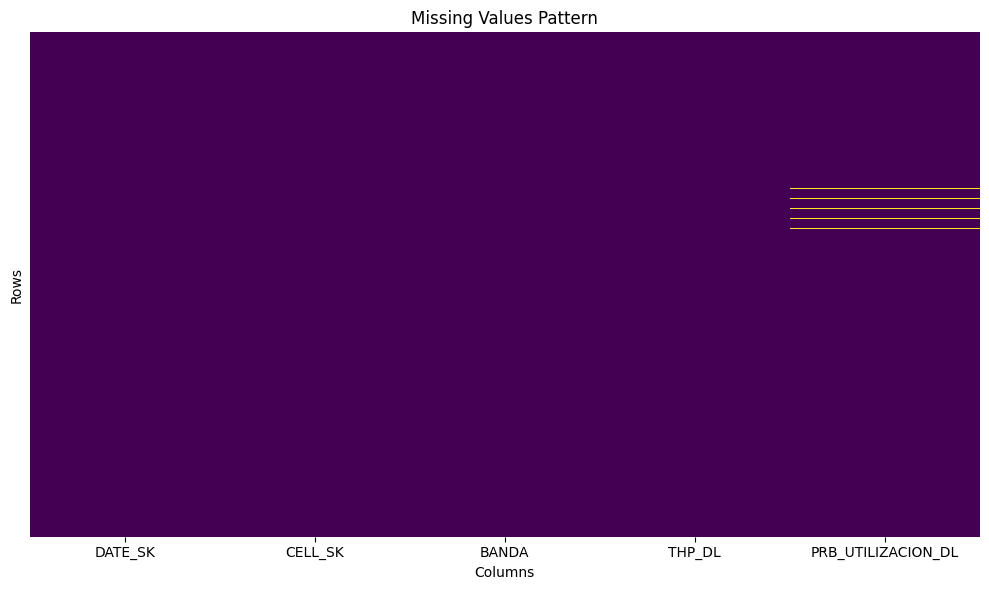

In [6]:
# Missing values analysis
missing_data = pd.DataFrame({
    'Missing Values': df_raw.isna().sum(),
    'Percentage (%)': round(df_raw.isna().mean() * 100, 2)
}).sort_values('Percentage (%)', ascending=False)

print("\nMissing Values Summary:")
display(missing_data)

# Visualize missing values pattern if any exist
if df_raw.isna().any().any():
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_raw.isna(), cbar=False, yticklabels=False, 
                cmap='viridis')
    plt.title('Missing Values Pattern')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.tight_layout()
    plt.show()

### 2.2 Duplicate & Range Checks

We'll now check for duplicates and perform basic data validation to ensure data integrity. In mobile network data, we shouldn't have multiple records for the same cell at the same timestamp, and metrics should be within expected ranges.

In [7]:
# Check for exact duplicates
dup_full = df_raw.duplicated().sum()
dup_pct = (dup_full / len(df_raw) * 100)

# Check for duplicate cell-date combinations (business key duplicates)
dup_pair = df_raw.duplicated(['CELL_SK', 'DATE_SK']).sum()
dup_pair_pct = (dup_pair / len(df_raw) * 100)

print("\nDuplicate Analysis:")
print(f"• Exact duplicates: {dup_full:,} rows ({dup_pct:.2f}%)")
print(f"• Duplicate cell-date pairs: {dup_pair:,} rows ({dup_pair_pct:.2f}%)")


Duplicate Analysis:
• Exact duplicates: 0 rows (0.00%)
• Duplicate cell-date pairs: 0 rows (0.00%)


### 2.3 Quick Integrity Assertions  


In [8]:
# Define expected ranges and data types
EXPECTED = {
    "DATE_SK": "datetime64[ns]",
    "CELL_SK": "int64", 
    "BANDA": "object",
    "THP_DL": "float64",
    "PRB_UTILIZACION_DL": "float64",
}

# Check for required columns
missing_cols = set(EXPECTED) - set(df_raw.columns)
assert not missing_cols, f"Missing columns: {missing_cols}"

# KPI range checks
print("\nValue Range Analysis:")
for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
    min_val = df_raw[kpi].min()
    max_val = df_raw[kpi].max()
    
    if kpi == 'PRB_UTILIZACION_DL':
        valid_range = (0, 1)
        invalid = ((df_raw[kpi] < 0) | (df_raw[kpi] > 1)).sum()
    else:  # THP_DL
        valid_range = (0, float('inf'))
        invalid = (df_raw[kpi] < 0).sum()
    
    invalid_pct = invalid / df_raw[kpi].count() * 100
    
    print(f"• {kpi}: Range [{min_val:.2f} to {max_val:.2f}], " 
          f"Expected [{valid_range[0]} to {valid_range[1]}]")
    print(f"  - Invalid values: {invalid:,} ({invalid_pct:.2f}%)")

# Time series completeness check
date_range = pd.date_range(start=df_raw.DATE_SK.min(), end=df_raw.DATE_SK.max())
missing_dates = set(date_range.date) - set(df_raw.DATE_SK.dt.date)
if missing_dates:
    print(f"\nWarning: {len(missing_dates)} dates missing in the dataset")
    if len(missing_dates) < 10:
        print(f"Missing dates: {sorted(missing_dates)}")


Value Range Analysis:
• THP_DL: Range [0.00 to 64994.53], Expected [0 to inf]
  - Invalid values: 0 (0.00%)
• PRB_UTILIZACION_DL: Range [0.00 to 2.18], Expected [0 to 1]
  - Invalid values: 9 (0.07%)


In [9]:
# Generate descriptive statistics
print("\nSummary Statistics:")
display(df_raw.describe().T)

# Data integrity assertions

# 1. Temporal span check (≥ 30 days)
span_days = (df_raw.DATE_SK.max() - df_raw.DATE_SK.min()).days + 1
assert span_days >= 30, f"Data only spans {span_days} days; require ≥30 days"
print(f"✓ Data spans {span_days} days (sufficient for analysis)")

# 2. Minimum samples per band
counts = df_raw.BANDA.value_counts()
assert counts.min() >= 100, f"Band {counts.idxmin()} has only {counts.min()} records"
print(f"✓ Each band has sufficient data points (AWS: {counts.get('AWS', 0):,}, 1900: {counts.get('1900', 0):,})")

# 3. No completely missing KPI columns
assert not df_raw['THP_DL'].isna().all(), "THP_DL column is completely empty"
assert not df_raw['PRB_UTILIZACION_DL'].isna().all(), "PRB_UTILIZACION_DL column is completely empty"
print("✓ KPI columns contain data")

print("\nAll integrity checks passed")


Summary Statistics:


count                           mean  \
DATE_SK               13320  2025-02-14 20:19:53.513513472   
CELL_SK             13320.0                 1729465.791892   
THP_DL              13320.0                   16190.250647   
PRB_UTILIZACION_DL  13140.0                        0.15515   

                                    min                  25%  \
DATE_SK             2025-01-01 00:00:00  2025-01-25 00:00:00   
CELL_SK                       1215849.0            1810745.0   
THP_DL                              0.0         12378.086664   
PRB_UTILIZACION_DL                  0.0             0.069167   

                                    50%                  75%  \
DATE_SK             2025-02-15 00:00:00  2025-03-09 00:00:00   
CELL_SK                       1856201.0            1864375.0   
THP_DL                     15904.998334         20264.444076   
PRB_UTILIZACION_DL             0.131667             0.210833   

                                    max            std  
DATE_SK             2025-03-29 00:00:00            NaN  
CELL_SK                       1907416.0  240078.458723  
THP_DL                      64994.52644    7783.137606  
PRB_UTILIZACION_DL             2.179167       0.125985

✓ Data spans 88 days (sufficient for analysis)
✓ Each band has sufficient data points (AWS: 11,494, 1900: 1,826)
✓ KPI columns contain data

All integrity checks passed


## 3. Data Quality Report & Cleaning  

This section performs a comprehensive data quality assessment and cleaning process to prepare our dataset for analysis. We'll identify and address various quality issues that could impact our findings, focusing on four main categories of problems: missing values, out-of-range values, outliers, and duplicates.
Our cleaning process will follow these steps:

Generate detailed quality profiles for each KPI
Remove exact duplicates and business key duplicates
Handle outliers through appropriate statistical methods
Correct out-of-range values for both throughput and PRB utilization
Implement time-aware imputation for missing values
Compare the raw and cleaned datasets to verify improvements
Export the cleaned dataset for future analysis

The goal is to create a reliable dataset that accurately represents the network performance while removing noise that could interfere with our anomaly detection.

### 3.1 KPI Data Quality Profile

KPI Quality Profiles:


count  valid % missing   % zeros % below range  \
THP_DL              13320  13320       0.0  7.635135           0.0   
PRB_UTILIZACION_DL  13320  13140  1.351351  7.635135           0.0   

                   % above range % outliers (IQR)  min          mean  \
THP_DL                         0        10.142643  0.0  16190.250647   
PRB_UTILIZACION_DL      0.067568         3.708709  0.0       0.15515   

                          median          max           recommended action  
THP_DL              15904.998334  64994.52644         investigate outliers  
PRB_UTILIZACION_DL      0.131667     2.179167  minor or no cleaning needed

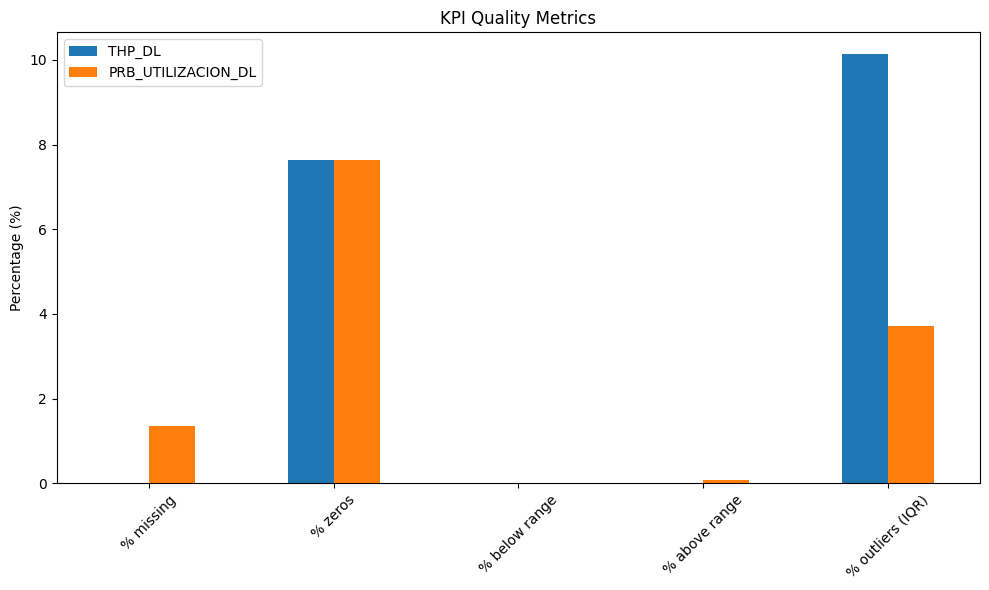

In [10]:
def profile_kpi(s: pd.Series, name: str = None) -> pd.Series:
    """
    Create a comprehensive quality profile for a KPI column.
    
    Parameters:
    -----------
    s : pd.Series
        The KPI column to profile
    name : str, optional
        Column name (uses Series name if not provided)
    
    Returns:
    --------
    pd.Series
        Quality metrics for the KPI
    """
    name = s.name if name is None else name
    n = len(s)
    valid = s.count()
    
    # Basic stats
    miss = s.isna().mean() * 100
    zeros = (s == 0).mean() * 100
    
    # Range checking based on KPI type
    if name.startswith("PRB"):
        # PRB utilization should be between 0 and 1 (0-100%)
        oob_low = (s < 0).mean() * 100
        oob_high = (s > 1).mean() * 100
        oob = ((s < 0) | (s > 1)).mean() * 100
    else:
        # Throughput should be non-negative
        oob_low = (s < 0).mean() * 100
        oob_high = 0  # No upper limit for throughput
        oob = oob_low
    
    # Calculate outliers using IQR method
    if valid >= 2:  # Need at least 2 valid values to calculate IQR
        Q1, Q3 = s.quantile([.25, .75])
        iqr = Q3 - Q1
        lower_bound = Q1 - 1.5 * iqr
        upper_bound = Q3 + 1.5 * iqr
        iqr_outliers = ((s < lower_bound) | (s > upper_bound)).mean() * 100
    else:
        iqr_outliers = 0
    
    # Recommend cleaning action based on quality metrics
    if miss > 10:
        action = "impute or drop (high missingness)"
    elif oob > 5:
        action = "fix out-of-range values"
    elif iqr_outliers > 10:
        action = "investigate outliers"
    else:
        action = "minor or no cleaning needed"
    
    return pd.Series({
        "count": n,
        "valid": valid,
        "% missing": miss,
        "% zeros": zeros,
        "% below range": oob_low,
        "% above range": oob_high,
        "% outliers (IQR)": iqr_outliers,
        "min": s.min(),
        "mean": s.mean(),
        "median": s.median(),
        "max": s.max(),
        "recommended action": action
    })

# Apply quality profiling to KPI columns
kpis = ["THP_DL", "PRB_UTILIZACION_DL"]
quality_profiles = pd.DataFrame({k: profile_kpi(df_raw[k]) for k in kpis}).T

# Display the quality profiles
print("KPI Quality Profiles:")
display(quality_profiles.round(2))

# Visualize key quality metrics
quality_metrics = quality_profiles[['% missing', '% zeros', '% below range', '% above range', '% outliers (IQR)']].T
plt.figure(figsize=(10, 6))
quality_metrics.plot(kind='bar', ax=plt.gca())
plt.title('KPI Quality Metrics')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### 3.2 Data Cleaning Process

In [11]:
# Create a copy of the raw data for cleaning
df_clean = df_raw.copy()
initial_rows = len(df_clean)

# Cast categorical and optimize dtypes early
df_clean['BANDA'] = df_clean['BANDA'].astype('category')
for col in kpis:
    df_clean[col] = df_clean[col].astype('float32')

logging.info(f"Starting cleaning: {initial_rows:,} rows")

# 1) Remove exact duplicates
n_exact = df_clean.duplicated().sum()
df_clean = df_clean.drop_duplicates()
logging.info(f"Step 1 – exact duplicates dropped: {n_exact:,}")

# 2) Remove duplicate business keys (CELL_SK + DATE_SK)
n_key = df_clean.duplicated(subset=['CELL_SK','DATE_SK']).sum()
df_clean = df_clean.drop_duplicates(subset=['CELL_SK','DATE_SK'])
logging.info(f"Step 2 – CELL_SK/DATE_SK duplicates dropped: {n_key:,}")

# 3) Out-of-range corrections
# 3a) THP_DL < 0 → drop
neg_thp = (df_clean['THP_DL'] < 0).sum()
if neg_thp:
    df_clean = df_clean[df_clean['THP_DL'] >= 0]
logging.info(f"Step 3a – negative THP_DL removed: {neg_thp:,}")

# 3b) PRB_UTILIZACION_DL outside [0,1] → cap to [0,1]
mask_prb = (df_clean['PRB_UTILIZACION_DL'] < 0) | (df_clean['PRB_UTILIZACION_DL'] > 1)
n_prb = mask_prb.sum()
if n_prb:
    df_clean.loc[mask_prb, 'PRB_UTILIZACION_DL'] = df_clean['PRB_UTILIZACION_DL'].clip(0, 1)
logging.info(f"Step 3b – PRB_UTILIZACION_DL capped to [0,1]: {n_prb:,}")

# 4) Winsorization by BANDA (±3 IQR per band)
winsorized = 0
for kpi in kpis:
    before = df_clean[kpi].copy()
    def cap_band(s):
        q1, q3 = s.quantile([.25, .75])
        iqr = q3 - q1
        return s.clip(lower=q1 - 3*iqr, upper=q3 + 3*iqr)
    df_clean[kpi] = df_clean.groupby('BANDA')[kpi].transform(cap_band)
    winsorized += (before != df_clean[kpi]).sum()
logging.info(f"Step 4 – winsorized values by band (±3 IQR): {winsorized:,}")

# 5) Time-aware imputation per CELL_SK & BANDA with fallback to group median
missing_before = df_clean[kpis].isna().sum().sum()
if missing_before:
    # 5a) Process each group separately to avoid index issues
    group_cols = ['CELL_SK', 'BANDA']
    
    # Create a copy to avoid SettingWithCopyWarning
    df_clean = df_clean.copy()
    
    # Sort by DATE_SK within each group
    df_clean.sort_values(group_cols + ['DATE_SK'], inplace=True)
    
    # Process each group and KPI combination
    for name, group in df_clean.groupby(group_cols):
        for kpi in kpis:
            # Create a temporary series with DATE_SK as index for interpolation
            temp_series = group.set_index('DATE_SK')[kpi].copy()
            
            # Interpolate using time method
            interpolated = temp_series.interpolate(method='time')
            
            # Get the row indices of the group in the original dataframe
            idx = group.index
            
            # Update the values in the original dataframe
            df_clean.loc[idx, kpi] = interpolated.values
    
    # 5b) Fill any remaining NaNs with median per CELL_SK/BANDA
    for kpi in kpis:
        group_medians = df_clean.groupby(group_cols)[kpi].transform('median')
        df_clean[kpi] = df_clean[kpi].fillna(group_medians)
    
    missing_after = df_clean[kpis].isna().sum().sum()
    logging.info(f"Step 5 – imputed missing: {missing_before - missing_after:,} values")

# Final summary
rows_removed = initial_rows - len(df_clean)
logging.info(f"Cleaning complete: {len(df_clean):,} rows remain ({rows_removed:,} removed)")

print("\nData Cleaning Summary:")
print(f"• Initial rows:      {initial_rows:,}")
print(f"• Final rows:        {len(df_clean):,}")
print(f"• Rows removed:      {rows_removed:,}")
print(f"• Total missing now: {df_clean[kpis].isna().sum().sum():,}")


INFO | Starting cleaning: 13,320 rows
INFO | Step 1 – exact duplicates dropped: 0
INFO | Step 2 – CELL_SK/DATE_SK duplicates dropped: 0
INFO | Step 3a – negative THP_DL removed: 0
INFO | Step 3b – PRB_UTILIZACION_DL capped to [0,1]: 9
INFO | Step 4 – winsorized values by band (±3 IQR): 263
INFO | Step 5 – imputed missing: 180 values
INFO | Cleaning complete: 13,320 rows remain (0 removed)



Data Cleaning Summary:
• Initial rows:      13,320
• Final rows:        13,320
• Rows removed:      0
• Total missing now: 0


### 3.3 Export Cleaned Dataset

In [12]:
# Save the cleaned dataset to feather format for faster loading
clean_fp = DATA_PROCESSED / "telecom_kpi_clean.feather"
df_clean.reset_index(drop=True).to_feather(clean_fp)
logging.info(f"Saved cleaned dataset to {clean_fp}")


INFO | Saved cleaned dataset to ..\data\processed\telecom_kpi_clean.feather


### 3.4 Data Quality Visualization (Before vs After)

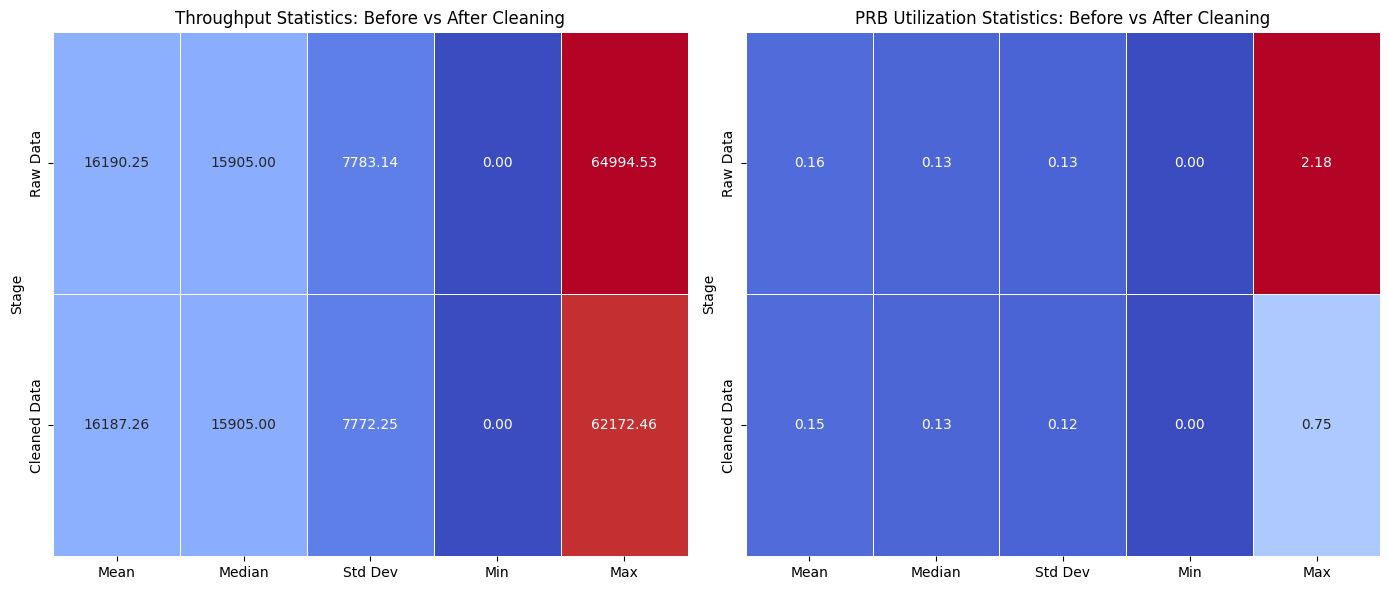

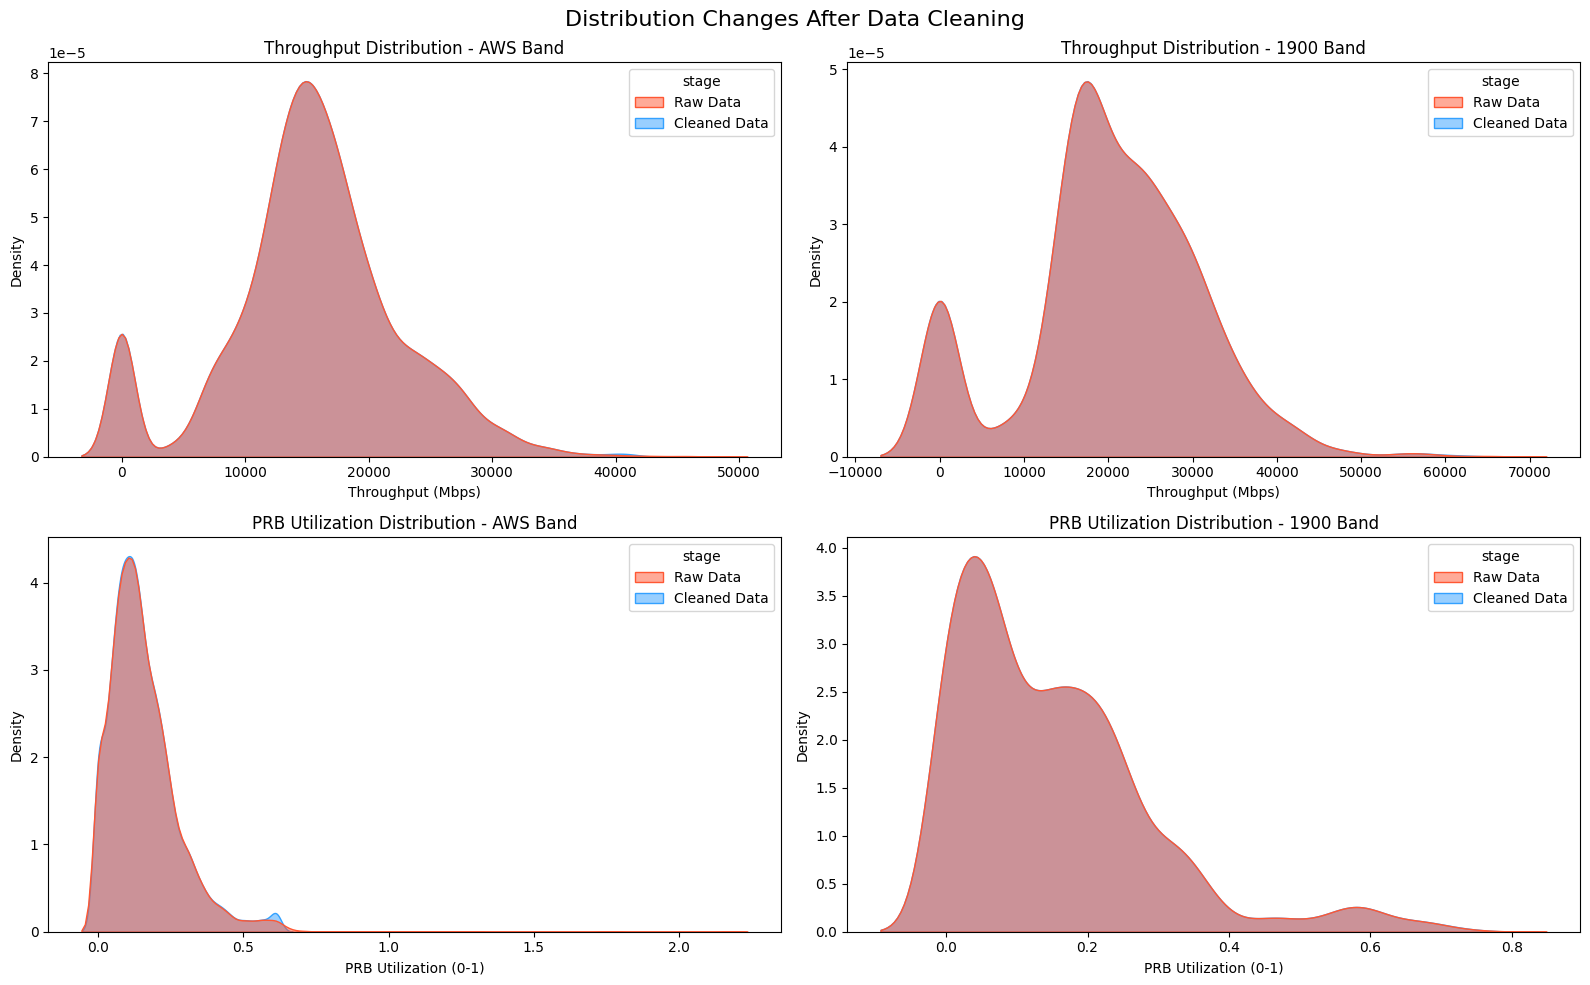

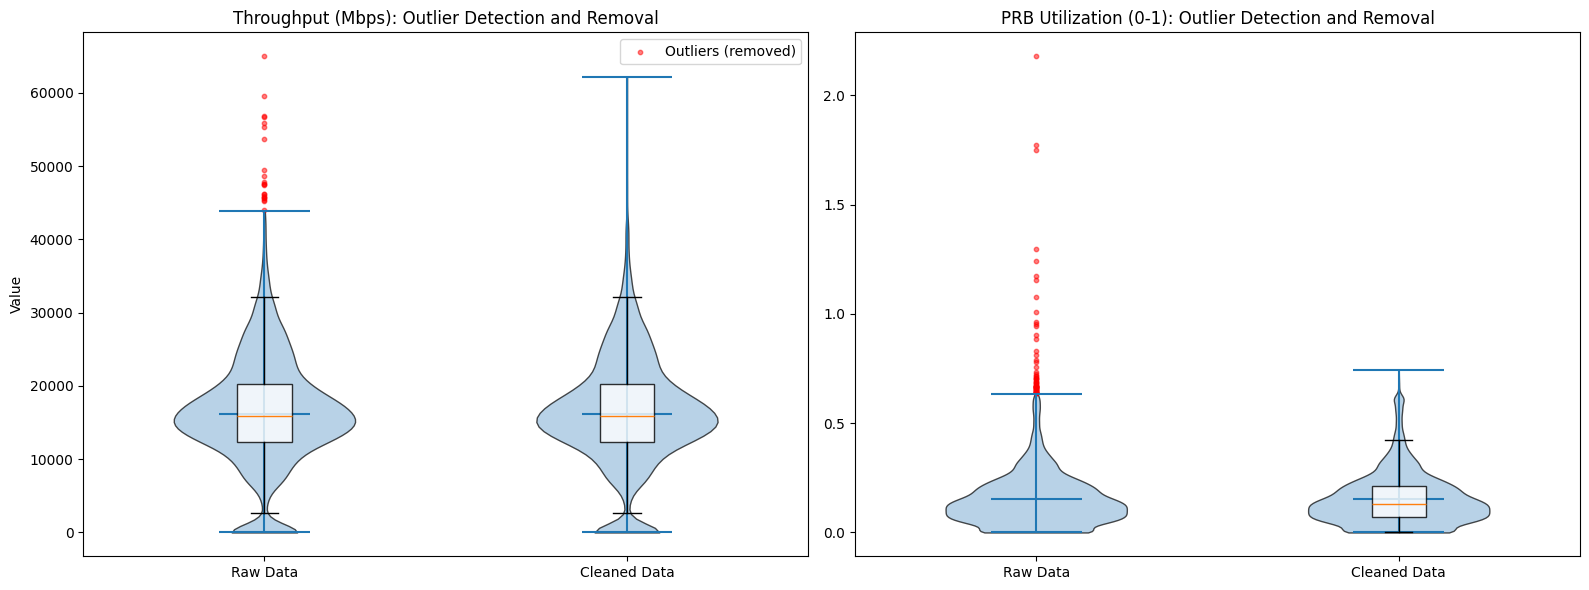

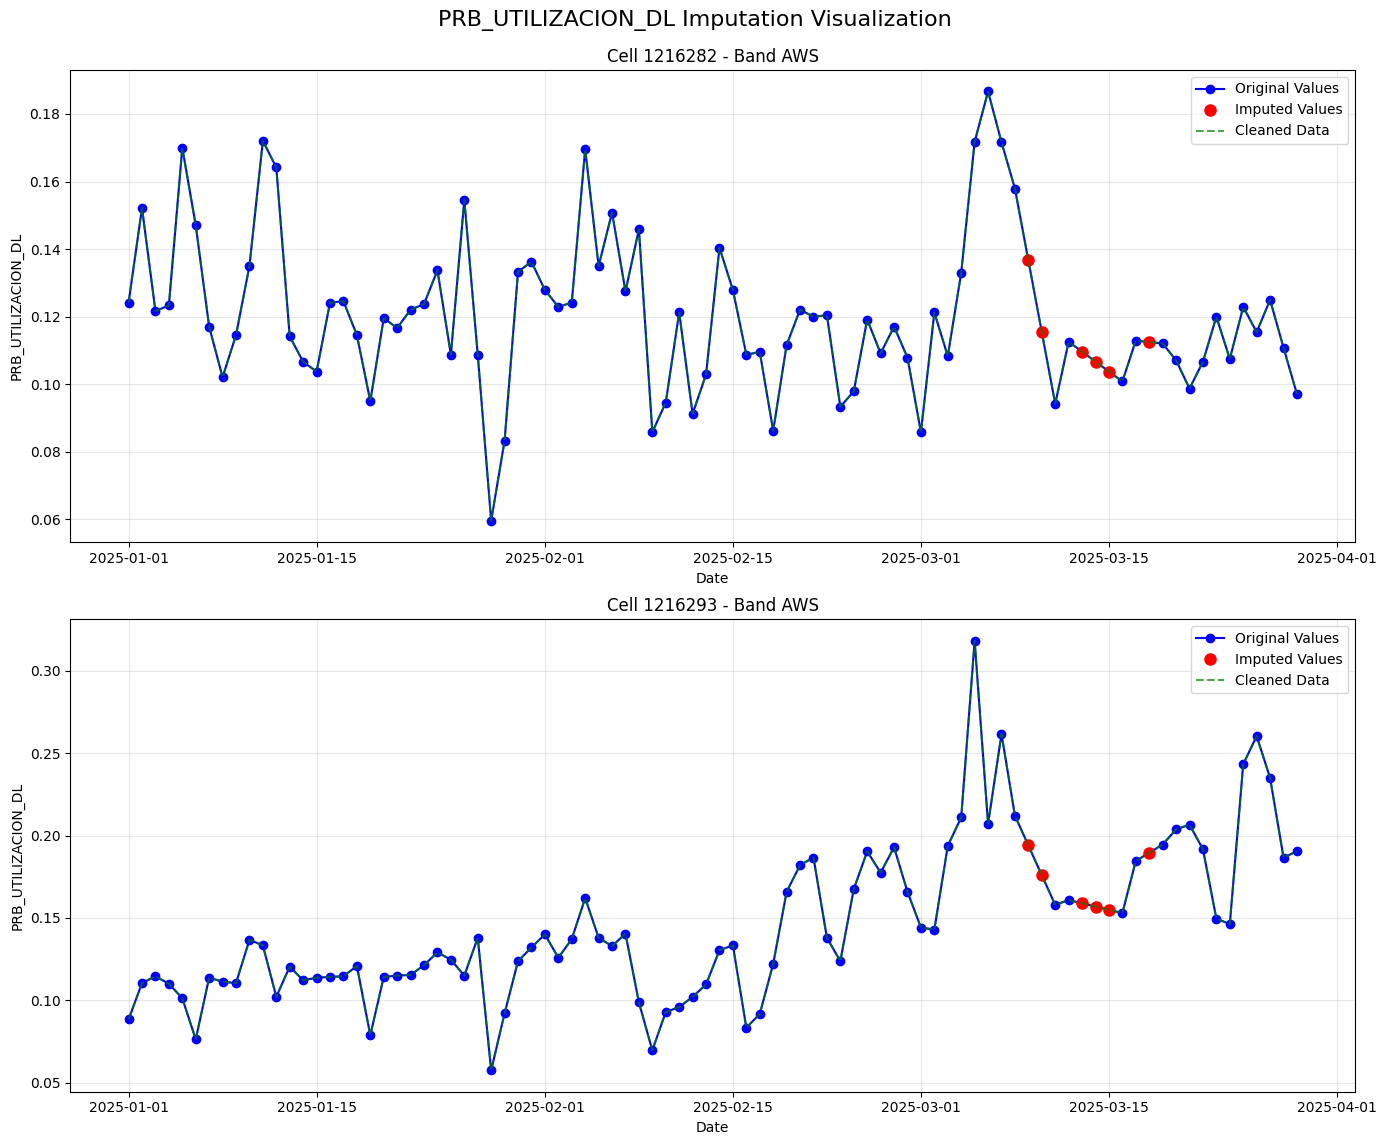

In [13]:
# Create a clean comparison dataframe
df_raw_cmp = df_raw[['DATE_SK','BANDA','THP_DL','PRB_UTILIZACION_DL']].assign(stage='Raw Data')
df_clean_cmp = df_clean[['DATE_SK','BANDA','THP_DL','PRB_UTILIZACION_DL']].assign(stage='Cleaned Data')
df_cmp = pd.concat([df_raw_cmp, df_clean_cmp], ignore_index=True)

# Set a consistent color palette for better visualization
palette = {'Raw Data': '#FF5733', 'Cleaned Data': '#33A1FF'}

# 1) IMPROVED VISUALIZATION: Pre vs Post Cleaning Statistics Summary
plt.figure(figsize=(14, 6))

# Create a dataframe with key statistics before and after cleaning
stats_data = []
for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
    kpi_name = 'Throughput' if kpi == 'THP_DL' else 'PRB Utilization'
    
    # Calculate statistics for raw data
    raw_stats = {
        'KPI': kpi_name,
        'Stage': 'Raw Data',
        'Mean': df_raw[kpi].mean(),
        'Median': df_raw[kpi].median(),
        'Std Dev': df_raw[kpi].std(),
        'Min': df_raw[kpi].min(),
        'Max': df_raw[kpi].max(),
        'Missing': df_raw[kpi].isna().sum()
    }
    stats_data.append(raw_stats)
    
    # Calculate statistics for clean data
    clean_stats = {
        'KPI': kpi_name,
        'Stage': 'Cleaned Data',
        'Mean': df_clean[kpi].mean(),
        'Median': df_clean[kpi].median(),
        'Std Dev': df_clean[kpi].std(),
        'Min': df_clean[kpi].min(),
        'Max': df_clean[kpi].max(),
        'Missing': df_clean[kpi].isna().sum()
    }
    stats_data.append(clean_stats)

# Create a statistics dataframe
stats_df = pd.DataFrame(stats_data)

# Create a heatmap visualization of the statistics
for i, kpi in enumerate(['Throughput', 'PRB Utilization']):
    plt.subplot(1, 2, i+1)
    
    # Filter for specific KPI
    kpi_stats = stats_df[stats_df['KPI'] == kpi].set_index('Stage')
    
    # Select numeric columns for the heatmap
    metrics = ['Mean', 'Median', 'Std Dev', 'Min', 'Max']
    
    # Create heatmap for the selected metrics
    sns.heatmap(kpi_stats[metrics], annot=True, fmt='.2f', cmap='coolwarm', 
                linewidths=0.5, cbar=False)
    
    plt.title(f"{kpi} Statistics: Before vs After Cleaning")

plt.tight_layout()
plt.savefig(FIG_DIR / "cleaning_stats_comparison.png", dpi=300)
plt.show()

# 2) Density Plot Comparison by Band 
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Distribution Changes After Data Cleaning', fontsize=16, y=0.98)

# Plot THP_DL for AWS band
sns.kdeplot(data=df_cmp[df_cmp['BANDA'] == 'AWS'], x='THP_DL', hue='stage', 
            fill=True, common_norm=False, palette=palette, alpha=0.5, ax=axes[0, 0])
axes[0, 0].set_title('Throughput Distribution - AWS Band')
axes[0, 0].set_xlabel('Throughput (Mbps)')
axes[0, 0].set_ylabel('Density')

# Plot THP_DL for 1900 band
sns.kdeplot(data=df_cmp[df_cmp['BANDA'] == '1900'], x='THP_DL', hue='stage', 
            fill=True, common_norm=False, palette=palette, alpha=0.5, ax=axes[0, 1])
axes[0, 1].set_title('Throughput Distribution - 1900 Band')
axes[0, 1].set_xlabel('Throughput (Mbps)')
axes[0, 1].set_ylabel('Density')

# Plot PRB_UTILIZACION_DL for AWS band
sns.kdeplot(data=df_cmp[df_cmp['BANDA'] == 'AWS'], x='PRB_UTILIZACION_DL', hue='stage', 
            fill=True, common_norm=False, palette=palette, alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('PRB Utilization Distribution - AWS Band')
axes[1, 0].set_xlabel('PRB Utilization (0-1)')
axes[1, 0].set_ylabel('Density')

# Plot PRB_UTILIZACION_DL for 1900 band
sns.kdeplot(data=df_cmp[df_cmp['BANDA'] == '1900'], x='PRB_UTILIZACION_DL', hue='stage', 
            fill=True, common_norm=False, palette=palette, alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title('PRB Utilization Distribution - 1900 Band')
axes[1, 1].set_xlabel('PRB Utilization (0-1)')
axes[1, 1].set_ylabel('Density')

plt.tight_layout()
plt.savefig(FIG_DIR / "distribution_changes.png", dpi=300)
plt.show()

# 3) Outlier Detection and Removal Visualization
plt.figure(figsize=(16, 6))

# Calculate statistics for boxplots
for i, kpi in enumerate(['THP_DL', 'PRB_UTILIZACION_DL']):
    plt.subplot(1, 2, i+1)
    
    # Calculate raw data statistics
    raw_data = df_raw[kpi]
    raw_q1, raw_q3 = raw_data.quantile([0.25, 0.75])
    raw_iqr = raw_q3 - raw_q1
    raw_lower = raw_q1 - 3 * raw_iqr
    raw_upper = raw_q3 + 3 * raw_iqr
    
    # Identify outliers in raw data
    raw_outliers = raw_data[(raw_data < raw_lower) | (raw_data > raw_upper)]
    raw_normal = raw_data[(raw_data >= raw_lower) & (raw_data <= raw_upper)]
    
    # Clean data
    clean_data = df_clean[kpi]
    
    # Create violin plots with outliers highlighted
    positions = [0, 1]
    violins = plt.violinplot(
        [raw_normal, clean_data], 
        positions=positions, 
        showmeans=True, 
        showextrema=True
    )
    
    # Customize violin plot appearance
    for pc in violins['bodies']:
        pc.set_facecolor('#9BC0DD')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    
    # Add scatter plot for outliers on raw data
    if not raw_outliers.empty:
        plt.scatter(
            np.zeros_like(raw_outliers) + 0, 
            raw_outliers, 
            color='red', 
            s=10, 
            alpha=0.5, 
            label='Outliers (removed)'
        )
    
    # Add boxplots overlay
    boxplots = plt.boxplot(
        [raw_data, clean_data], 
        positions=positions, 
        widths=0.15, 
        patch_artist=True, 
        showfliers=False
    )
    
    # Customize boxplot appearance
    for box in boxplots['boxes']:
        box.set(facecolor='white', alpha=0.8)
    
    # Set labels and title
    plt.xticks(positions, ['Raw Data', 'Cleaned Data'])
    title = 'Throughput (Mbps)' if kpi == 'THP_DL' else 'PRB Utilization (0-1)'
    plt.title(f'{title}: Outlier Detection and Removal')
    
    if i == 0:
        plt.ylabel('Value')
        if not raw_outliers.empty:
            plt.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "outlier_removal_visualization.png", dpi=300)
plt.show()

# 4) Time Series with Imputation Highlights
# Only for visualizing if there were missing values that were imputed
missing_before = df_raw[kpis].isna().sum().sum()

if missing_before > 0:
    # Create merged dataset with indicator for missing values
    missing_df = df_raw[['CELL_SK', 'DATE_SK', 'BANDA', 'THP_DL', 'PRB_UTILIZACION_DL']].copy()
    missing_df['THP_DL_MISSING'] = missing_df['THP_DL'].isna()
    missing_df['PRB_UTILIZACION_DL_MISSING'] = missing_df['PRB_UTILIZACION_DL'].isna()
    
    # Merge with cleaned data
    imputation_df = missing_df.merge(
        df_clean[['CELL_SK', 'DATE_SK', 'THP_DL', 'PRB_UTILIZACION_DL']],
        on=['CELL_SK', 'DATE_SK'],
        suffixes=('_raw', '_clean')
    )
    
    # Plot time series for a sample of cells with imputed values
    for kpi in kpis:
        missing_col = f"{kpi}_MISSING"
        raw_col = f"{kpi}_raw"
        clean_col = f"{kpi}_clean"
        
        # Skip if there were no missing values for this KPI
        if imputation_df[missing_col].sum() == 0:
            continue
        
        # Find cells with missing values
        cells_with_missing = imputation_df[imputation_df[missing_col]]['CELL_SK'].unique()
        
        if len(cells_with_missing) > 0:
            # Take up to 2 sample cells for visualization
            sample_cells = cells_with_missing[:min(2, len(cells_with_missing))]
            
            plt.figure(figsize=(14, 6 * len(sample_cells)))
            plt.suptitle(f'{kpi} Imputation Visualization', fontsize=16, y=0.95)
            
            for i, cell in enumerate(sample_cells):
                # Filter data for this cell
                cell_data = imputation_df[imputation_df['CELL_SK'] == cell].sort_values('DATE_SK')
                
                plt.subplot(len(sample_cells), 1, i+1)
                
                # Plot original values where available
                mask_available = ~cell_data[missing_col]
                plt.plot(cell_data.loc[mask_available, 'DATE_SK'], 
                         cell_data.loc[mask_available, raw_col], 
                         'o-', color='blue', label='Original Values')
                
                # Plot imputed values (clean data where raw was missing)
                mask_imputed = cell_data[missing_col]
                if mask_imputed.sum() > 0:
                    plt.plot(cell_data.loc[mask_imputed, 'DATE_SK'], 
                             cell_data.loc[mask_imputed, clean_col], 
                             'o', color='red', markersize=8, label='Imputed Values')
                
                # Plot the full clean data line
                plt.plot(cell_data['DATE_SK'], cell_data[clean_col], 
                         '--', color='green', alpha=0.7, label='Cleaned Data')
                
                plt.title(f'Cell {cell} - Band {cell_data["BANDA"].iloc[0]}')
                plt.xlabel('Date')
                plt.ylabel(kpi)
                plt.legend()
                plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.savefig(FIG_DIR / f"{kpi}_imputation_visualization.png", dpi=300)
            plt.show()

## 4. Exploratory Data Analysis

In this section, we explore the telecommunications network data to uncover patterns, relationships, and potential anomalies. We'll progress from basic statistical analysis to more complex relationship investigations, gaining insights into the performance characteristics across different frequency bands (AWS and 1900 MHz).
Our exploration will focus on:

Comparing key metrics (THP_DL and PRB_UTILIZACION_DL) across frequency bands
Analyzing the relationship between throughput and PRB utilization
Identifying temporal patterns (daily, weekly trends)
Examining cell-level performance and variability
Detecting potential anomalies using both univariate and multivariate methods
Calculating efficiency metrics to identify optimization opportunities

This analysis will help us understand normal network behavior patterns and identify potential performance issues requiring attention.

### 4.1 Descriptive Statistics Analysis

In [14]:
# Load the cleaned dataset
df_clean = pd.read_feather(DATA_PROCESSED / "telecom_kpi_clean.feather")
logging.info(f"Loaded cleaned dataset with {len(df_clean):,} rows")


INFO | Loaded cleaned dataset with 13,320 rows


#### 4.1.1 Basic Statistics by Frequency Band

In [15]:
# Calculate and display statistics by band
band_stats = df_clean.groupby('BANDA')[['THP_DL', 'PRB_UTILIZACION_DL']].agg([
    'count', 'mean', 'std', 'min', 
    lambda x: x.quantile(0.25), 
    'median', 
    lambda x: x.quantile(0.75), 
    'max',
    lambda x: x.quantile(0.95) - x.quantile(0.05)  # 90% range
]).round(2)

# Rename custom lambda functions
band_stats.columns = band_stats.columns.set_levels(['count', 'mean', 'std', 'min', 'q25', 'median', 'q75', 'max', 'range90'], level=1)
print("Summary statistics by frequency band:")
display(band_stats)

# Statistical tests to compare bands
from scipy.stats import mannwhitneyu

test_results = {}
for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
    aws_data = df_clean[df_clean['BANDA'] == 'AWS'][kpi]
    band_1900_data = df_clean[df_clean['BANDA'] == '1900'][kpi]
    
    stat, p = mannwhitneyu(aws_data, band_1900_data)
    diff_pct = ((aws_data.median() - band_1900_data.median()) / band_1900_data.median() * 100).round(2)
    
    test_results[kpi] = {
        'U-statistic': round(stat, 2),
        'p-value': round(p, 6),
        'Significant': 'Yes' if p < 0.05 else 'No',
        'AWS vs 1900 (% diff)': f"{diff_pct}%"
    }
    
print("\nStatistical comparison between frequency bands:")
display(pd.DataFrame(test_results).T)


Summary statistics by frequency band:


THP_DL                                                                 \
       count          mean           std  min       q25    median       q75   
BANDA                                                                         
1900    1826  20294.080078  10500.150391  0.0  15534.66  20188.91  27194.11   
AWS    11494  15534.830078   7028.000000  0.0  12099.02  15446.82  19300.34   

                              PRB_UTILIZACION_DL                         \
                max   range90              count  mean   std  min   q25   
BANDA                                                                     
1900   62172.460938  36250.65               1826  0.15  0.14  0.0  0.05   
AWS    40904.308594  27374.51              11494  0.16  0.12  0.0  0.07   

                                  
      median   q75   max range90  
BANDA                             
1900    0.12  0.22  0.74    0.40  
AWS     0.13  0.21  0.62    0.38


Statistical comparison between frequency bands:


U-statistic p-value Significant  AWS vs 1900 (% diff)
THP_DL               6766737.5     0.0         Yes  -23.489999771118164%
PRB_UTILIZACION_DL  11268260.5     0.0         Yes    7.820000171661377%

#### 4.1.2 Distribution Visualization

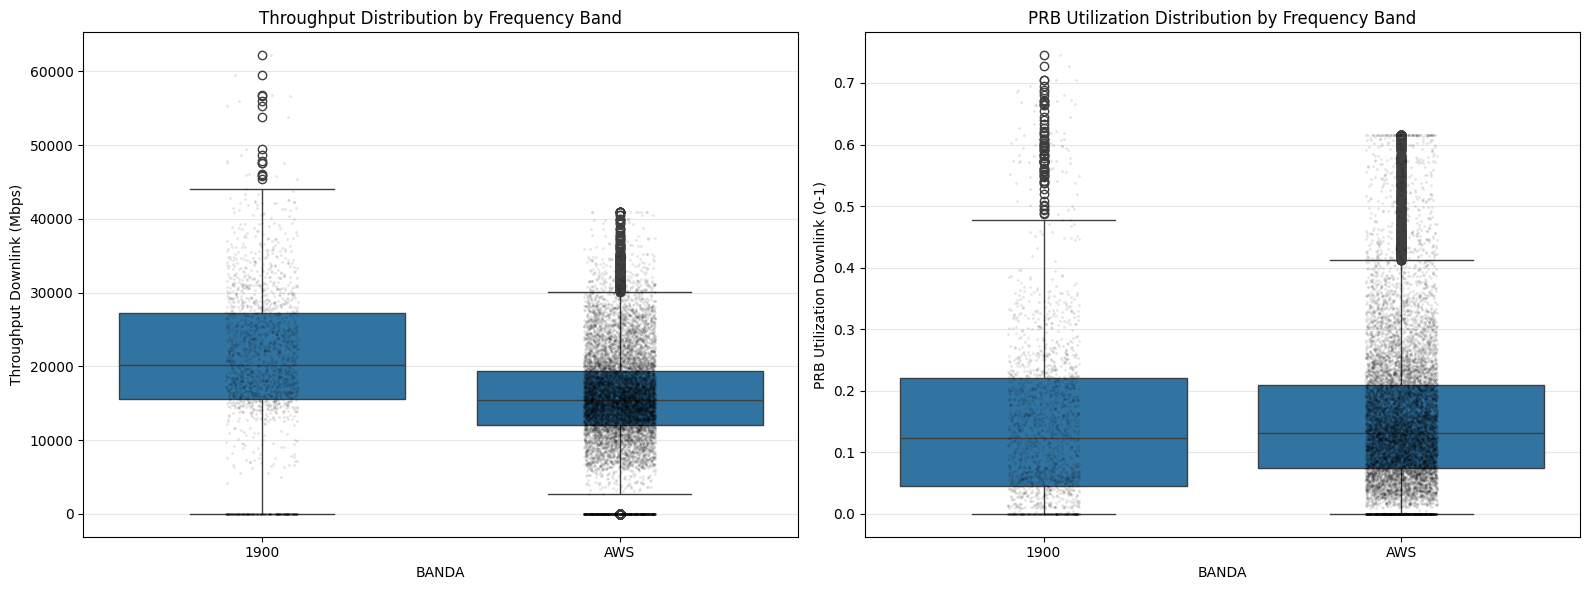

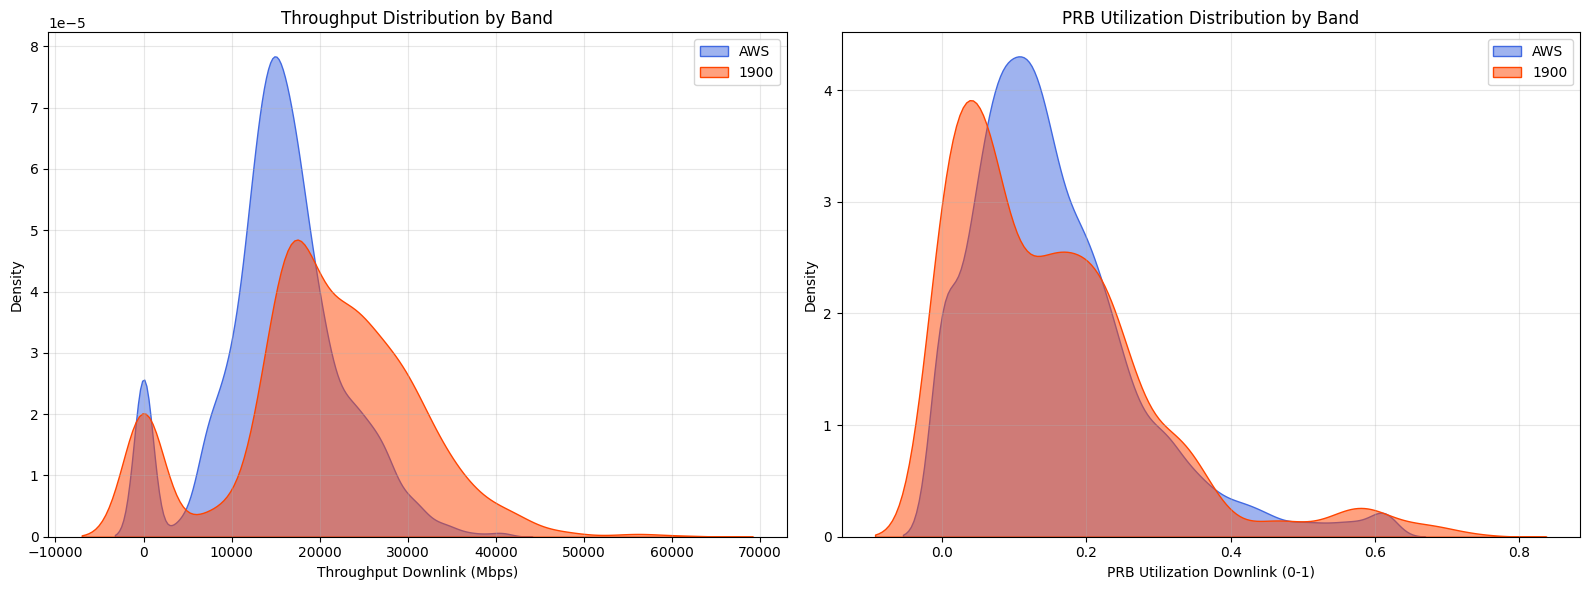

In [16]:
# Create enhanced boxplots for KPIs by band
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Throughput boxplot
sns.boxplot(x='BANDA', y='THP_DL', data=df_clean, ax=axes[0])
sns.stripplot(x='BANDA', y='THP_DL', data=df_clean, size=2, alpha=0.1, jitter=True, color='black', ax=axes[0])
axes[0].set_title('Throughput Distribution by Frequency Band')
axes[0].set_ylabel('Throughput Downlink (Mbps)')
axes[0].grid(axis='y', alpha=0.3)

# PRB Utilization boxplot
sns.boxplot(x='BANDA', y='PRB_UTILIZACION_DL', data=df_clean, ax=axes[1])
sns.stripplot(x='BANDA', y='PRB_UTILIZACION_DL', data=df_clean, size=2, alpha=0.1, jitter=True, color='black', ax=axes[1])
axes[1].set_title('PRB Utilization Distribution by Frequency Band')
axes[1].set_ylabel('PRB Utilization Downlink (0-1)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kpi_boxplots_by_band.png', dpi=300, bbox_inches='tight')
plt.show()

# Distribution density plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Throughput distributions by band
for band, color in zip(['AWS', '1900'], ['royalblue', 'orangered']):
    sns.kdeplot(
        df_clean[df_clean['BANDA'] == band]['THP_DL'],
        fill=True, 
        alpha=0.5, 
        label=band,
        ax=axes[0],
        color=color
    )
axes[0].set_title('Throughput Distribution by Band')
axes[0].set_xlabel('Throughput Downlink (Mbps)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# PRB Utilization distributions by band
for band, color in zip(['AWS', '1900'], ['royalblue', 'orangered']):
    sns.kdeplot(
        df_clean[df_clean['BANDA'] == band]['PRB_UTILIZACION_DL'],
        fill=True, 
        alpha=0.5, 
        label=band,
        ax=axes[1],
        color=color
    )
axes[1].set_title('PRB Utilization Distribution by Band')
axes[1].set_xlabel('PRB Utilization Downlink (0-1)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kpi_density_by_band.png', dpi=300, bbox_inches='tight')
plt.show()


#### 4.1.3 Percentile Analysis


Percentile analysis by band:

--- AWS Band ---


THP_DL  PRB_UTILIZACION_DL
0.01      0.000               0.000
0.05      0.000               0.000
0.10   7276.830               0.031
0.25  12099.022               0.075
0.50  15446.819               0.132
0.75  19300.344               0.210
0.90  24605.182               0.305
0.95  27374.509               0.380
0.99  32683.306               0.585


--- 1900 Band ---


THP_DL  PRB_UTILIZACION_DL
0.01      0.000               0.000
0.05      0.000               0.000
0.10      0.000               0.000
0.25  15534.658               0.046
0.50  20188.909               0.123
0.75  27194.108               0.221
0.90  32681.061               0.320
0.95  36250.651               0.396
0.99  43329.741               0.626

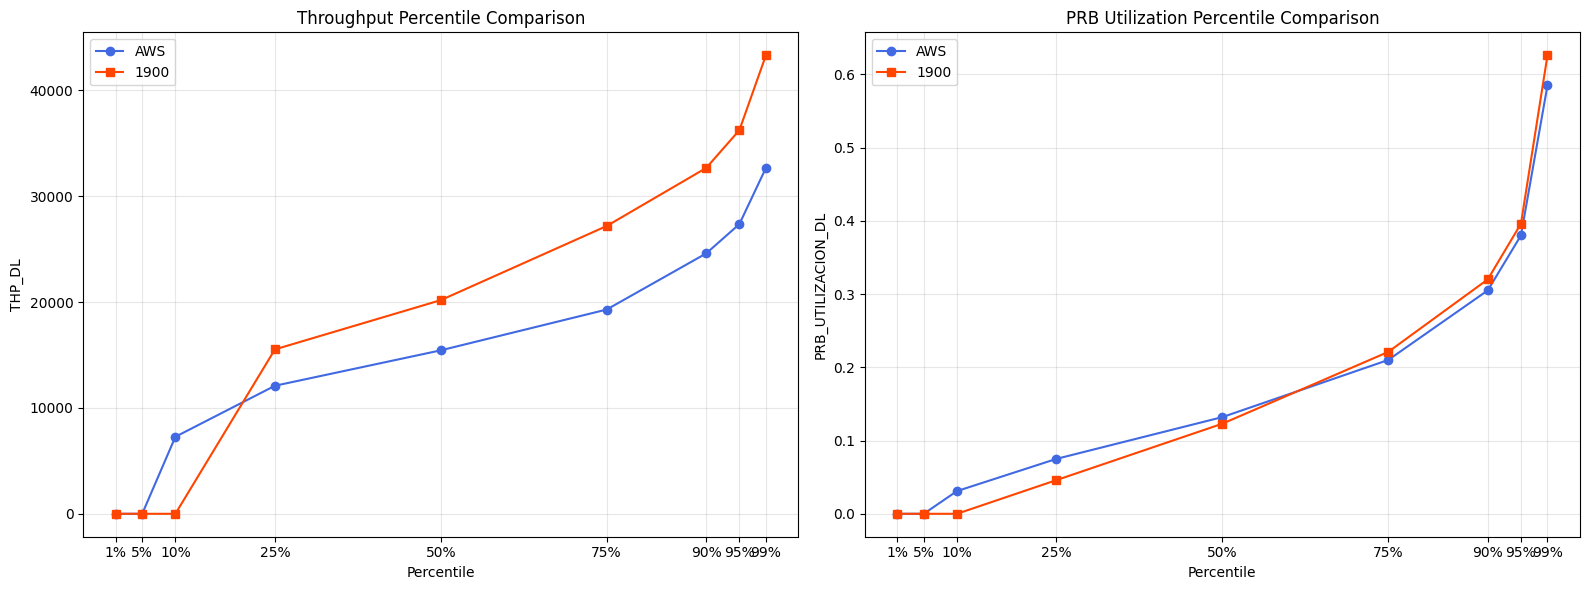

In [17]:
# Calculate percentiles for more detailed comparison
percentiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
percentile_results = {}

for band in df_clean['BANDA'].unique():
    band_data = df_clean[df_clean['BANDA'] == band]
    
    for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
        if band not in percentile_results:
            percentile_results[band] = {}
            
        percentile_results[band][kpi] = band_data[kpi].quantile(percentiles).round(3)

print("\nPercentile analysis by band:")
for band, data in percentile_results.items():
    print(f"\n--- {band} Band ---")
    display(pd.DataFrame(data))

# Visualize percentile comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Function to plot percentiles
def plot_percentiles(ax, kpi, title):
    for band, color, marker in zip(['AWS', '1900'], ['royalblue', 'orangered'], ['o', 's']):
        ax.plot(
            percentiles, 
            percentile_results[band][kpi],
            marker=marker,
            color=color,
            label=band
        )
    
    ax.set_title(title)
    ax.set_xlabel('Percentile')
    ax.set_ylabel(kpi)
    ax.set_xticks(percentiles)
    ax.set_xticklabels([f"{p*100:.0f}%" for p in percentiles])
    ax.grid(alpha=0.3)
    ax.legend()

# Plot percentiles for both KPIs
plot_percentiles(axes[0], 'THP_DL', 'Throughput Percentile Comparison')
plot_percentiles(axes[1], 'PRB_UTILIZACION_DL', 'PRB Utilization Percentile Comparison')

plt.tight_layout()
plt.savefig(FIG_DIR / 'kpi_percentile_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### 4.2 Relationship Analysis

#### 4.2.1 Correlation Between KPIs

Overall correlation between THP_DL and PRB_UTILIZACION_DL: -0.180

Correlation for AWS band:
  Pearson (linear): -0.216
  Spearman (rank): -0.296
  Relationship: More non-linear

Correlation for 1900 band:
  Pearson (linear): -0.057
  Spearman (rank): -0.031
  Relationship: Primarily linear


<Figure size 1200x600 with 0 Axes>

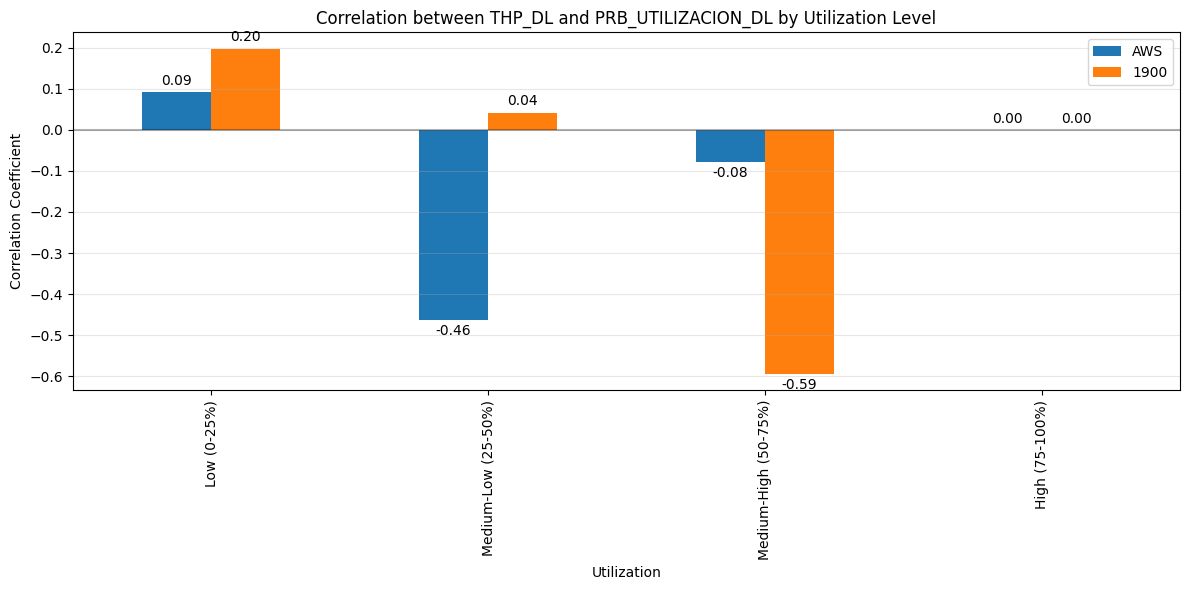

In [18]:
# Calculate correlation between KPIs
correlation = df_clean['THP_DL'].corr(df_clean['PRB_UTILIZACION_DL'])
print(f"Overall correlation between THP_DL and PRB_UTILIZACION_DL: {correlation:.3f}")

# Calculate correlation by band
for band in df_clean['BANDA'].unique():
    band_df = df_clean[df_clean['BANDA'] == band]
    pearson_corr = band_df['THP_DL'].corr(band_df['PRB_UTILIZACION_DL'], method='pearson')
    spearman_corr = band_df['THP_DL'].corr(band_df['PRB_UTILIZACION_DL'], method='spearman')
    
    print(f"\nCorrelation for {band} band:")
    print(f"  Pearson (linear): {pearson_corr:.3f}")
    print(f"  Spearman (rank): {spearman_corr:.3f}")
    print(f"  Relationship: {'More non-linear' if abs(spearman_corr) > abs(pearson_corr) else 'Primarily linear'}")

# Calculate correlation by utilization levels
utilization_bands = [
    (0, 0.25, 'Low (0-25%)'),
    (0.25, 0.5, 'Medium-Low (25-50%)'),
    (0.5, 0.75, 'Medium-High (50-75%)'),
    (0.75, 1.0, 'High (75-100%)')
]

corr_by_level = {'AWS': [], '1900': []}
labels = []

for low, high, label in utilization_bands:
    labels.append(label)
    
    for band in ['AWS', '1900']:
        # Filter by frequency band and utilization range
        mask = (df_clean['BANDA'] == band) & (df_clean['PRB_UTILIZACION_DL'] >= low) & (df_clean['PRB_UTILIZACION_DL'] < high)
        subset = df_clean[mask]
        
        # Calculate correlation if sufficient data
        if len(subset) > 5:
            corr = subset['THP_DL'].corr(subset['PRB_UTILIZACION_DL'])
        else:
            corr = np.nan
            
        corr_by_level[band].append(corr)

# Create dataframe for visualization
corr_df = pd.DataFrame({
    'Utilization': labels,
    'AWS': corr_by_level['AWS'],
    '1900': corr_by_level['1900']
})

# Visualize correlations by utilization level
plt.figure(figsize=(12, 6))
ax = corr_df.set_index('Utilization').plot(kind='bar', figsize=(12, 6))
plt.title('Correlation between THP_DL and PRB_UTILIZACION_DL by Utilization Level')
plt.ylabel('Correlation Coefficient')
plt.grid(axis='y', alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add values to bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_by_utilization.png', dpi=300, bbox_inches='tight')
plt.show()


#### 4.2.2 Throughput vs PRB Utilization Patterns

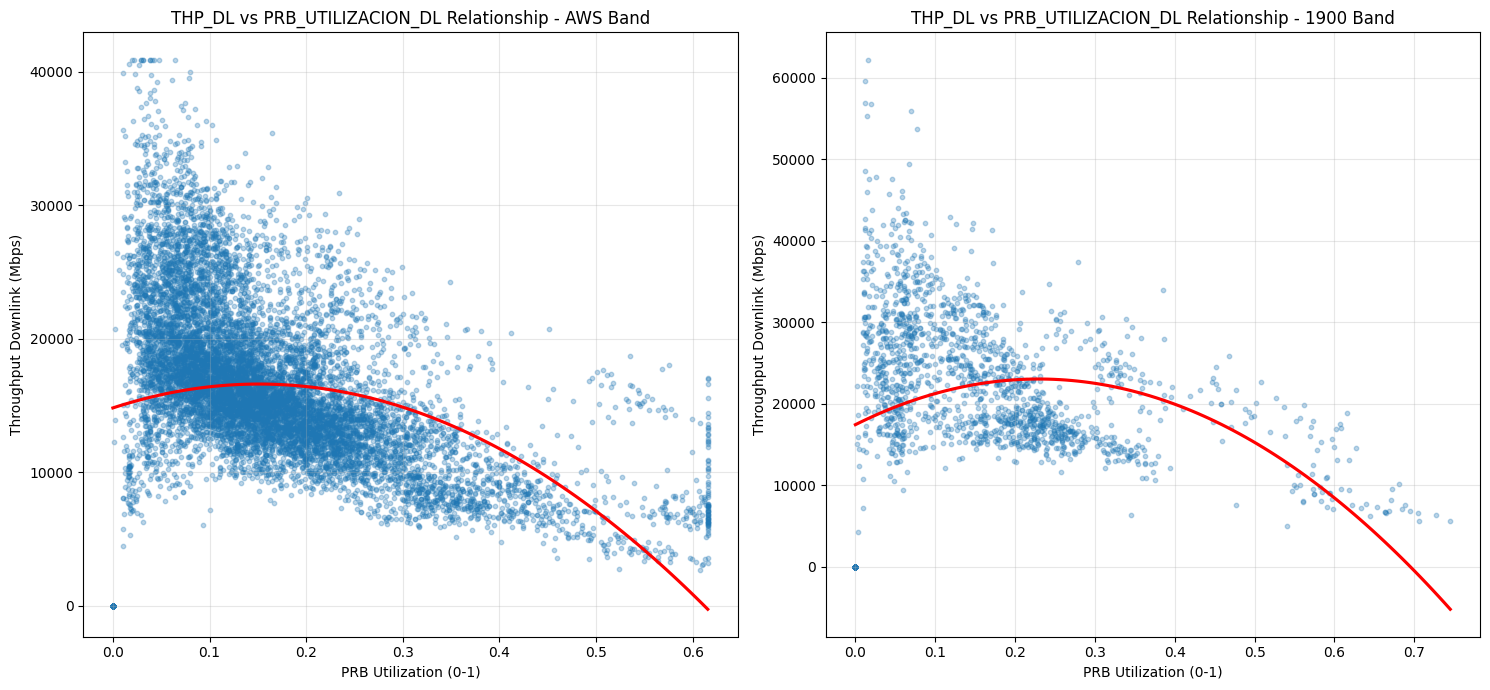

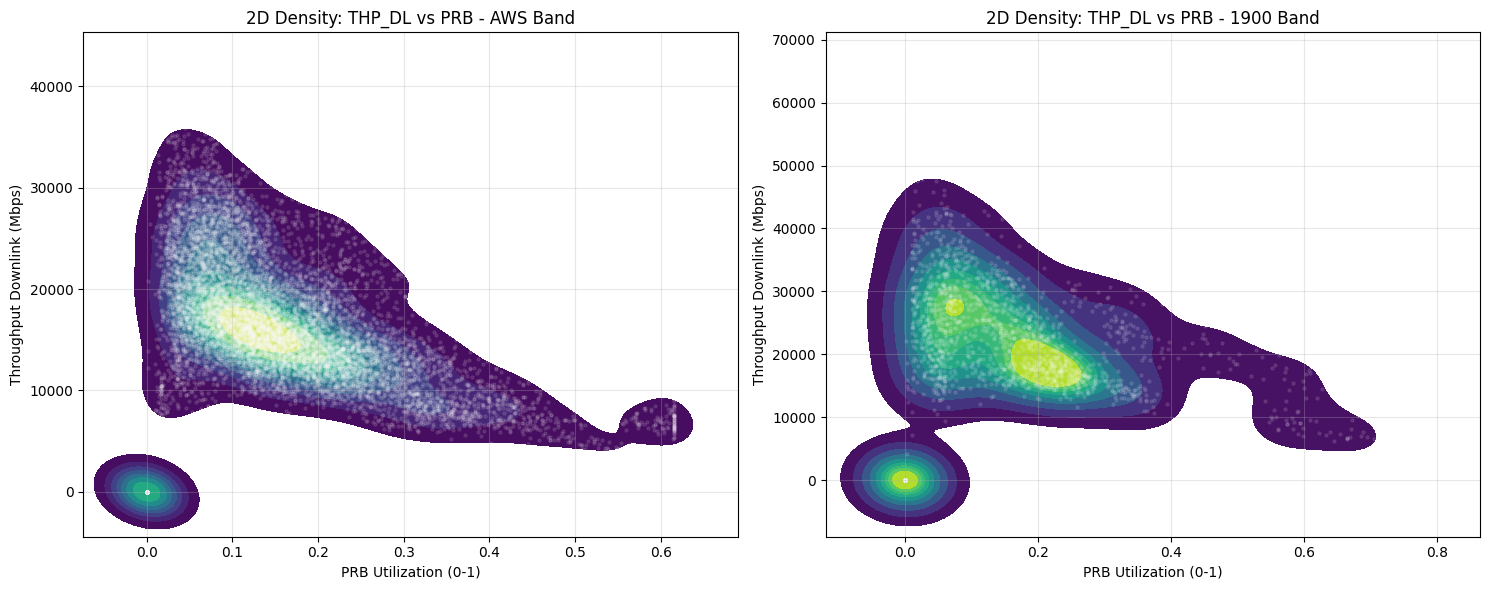

In [19]:
# 2D Visualization of relationship with regression
plt.figure(figsize=(15, 7))

for i, band in enumerate(['AWS', '1900']):
    plt.subplot(1, 2, i+1)
    
    # Filter data for this band
    band_data = df_clean[df_clean['BANDA'] == band]
    
    # Create scatter plot with polynomial regression
    sns.regplot(
        x='PRB_UTILIZACION_DL',
        y='THP_DL',
        data=band_data,
        scatter_kws={'alpha': 0.3, 's': 10},
        line_kws={'color': 'red'},
        order=2,  # Polynomial regression (order 2)
        ci=None
    )
    
    plt.title(f'THP_DL vs PRB_UTILIZACION_DL Relationship - {band} Band')
    plt.xlabel('PRB Utilization (0-1)')
    plt.ylabel('Throughput Downlink (Mbps)')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kpi_regression_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Create 2D density plot to better visualize concentrations
plt.figure(figsize=(15, 6))

for i, band in enumerate(['AWS', '1900']):
    plt.subplot(1, 2, i+1)
    
    # Filter data for this band
    band_data = df_clean[df_clean['BANDA'] == band]
    
    # Create 2D density plot
    sns.kdeplot(
        x='PRB_UTILIZACION_DL',
        y='THP_DL',
        data=band_data,
        fill=True,
        cmap='viridis',
        thresh=0.05
    )
    
    # Add sparse scatter points
    plt.scatter(
        band_data['PRB_UTILIZACION_DL'],
        band_data['THP_DL'],
        alpha=0.1,
        s=5,
        color='white',
        edgecolor=None
    )
    
    plt.title(f'2D Density: THP_DL vs PRB - {band} Band')
    plt.xlabel('PRB Utilization (0-1)')
    plt.ylabel('Throughput Downlink (Mbps)')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kpi_2d_density.png', dpi=300, bbox_inches='tight')
plt.show()


#### 4.2.3 Performance Efficiency Analysis

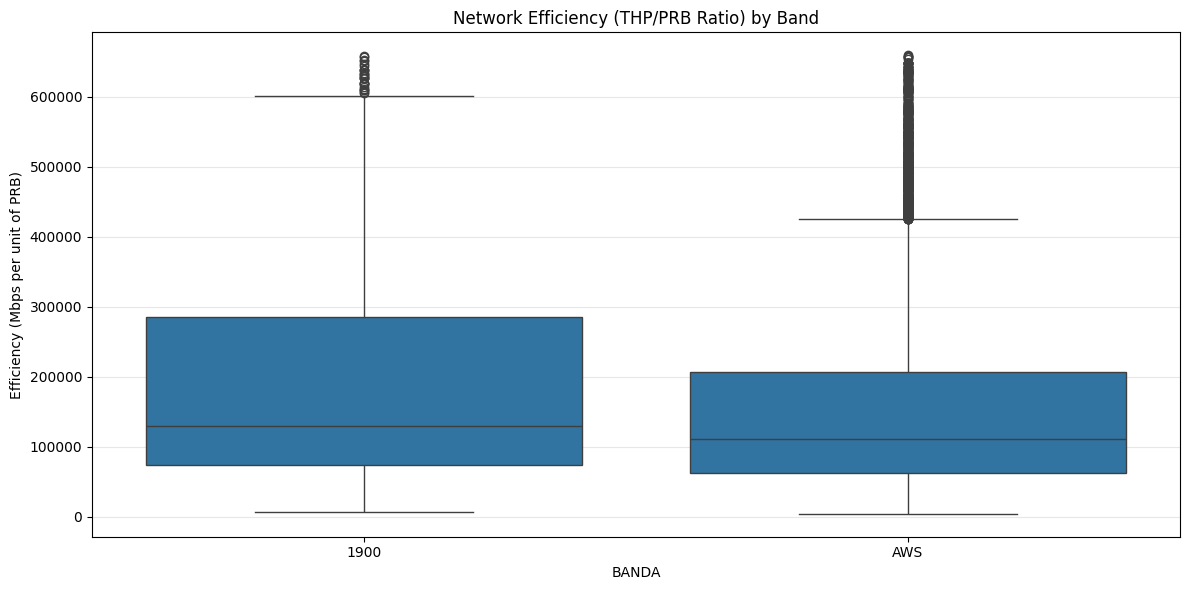

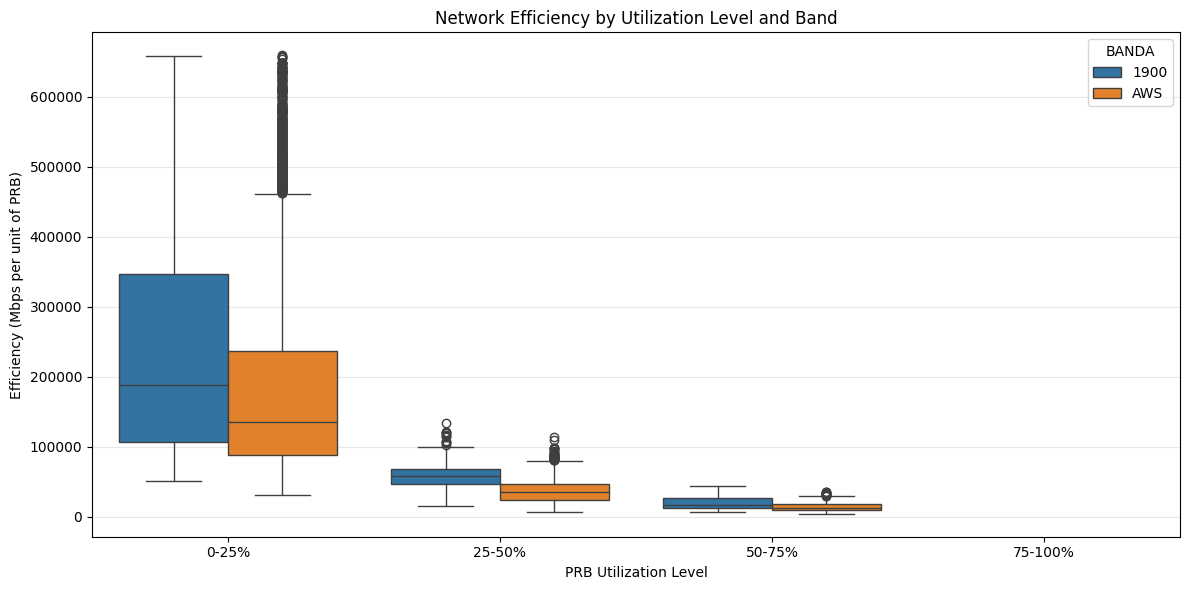

In [20]:
# Calculate efficiency ratio (THP/PRB)
df_clean['efficiency'] = df_clean['THP_DL'] / df_clean['PRB_UTILIZACION_DL'].replace(0, np.nan)

# Remove extreme outliers for visualization
efficiency_data = df_clean[df_clean['efficiency'] < df_clean['efficiency'].quantile(0.95)].copy()

# Visualize efficiency distribution by band
plt.figure(figsize=(12, 6))
sns.boxplot(x='BANDA', y='efficiency', data=efficiency_data)
plt.title('Network Efficiency (THP/PRB Ratio) by Band')
plt.ylabel('Efficiency (Mbps per unit of PRB)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'efficiency_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze efficiency by PRB utilization level
plt.figure(figsize=(12, 6))

# Create utilization bins
efficiency_data['utilization_bin'] = pd.cut(
    efficiency_data['PRB_UTILIZACION_DL'], 
    bins=[0, 0.25, 0.5, 0.75, 1.0],
    labels=['0-25%', '25-50%', '50-75%', '75-100%']
)

# Plot efficiency by utilization and band
sns.boxplot(x='utilization_bin', y='efficiency', hue='BANDA', data=efficiency_data)
plt.title('Network Efficiency by Utilization Level and Band')
plt.xlabel('PRB Utilization Level')
plt.ylabel('Efficiency (Mbps per unit of PRB)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'efficiency_by_utilization.png', dpi=300, bbox_inches='tight')
plt.show()



### 4.3 Temporal Pattern Analysis

#### 4.3.1 Time Series Trends

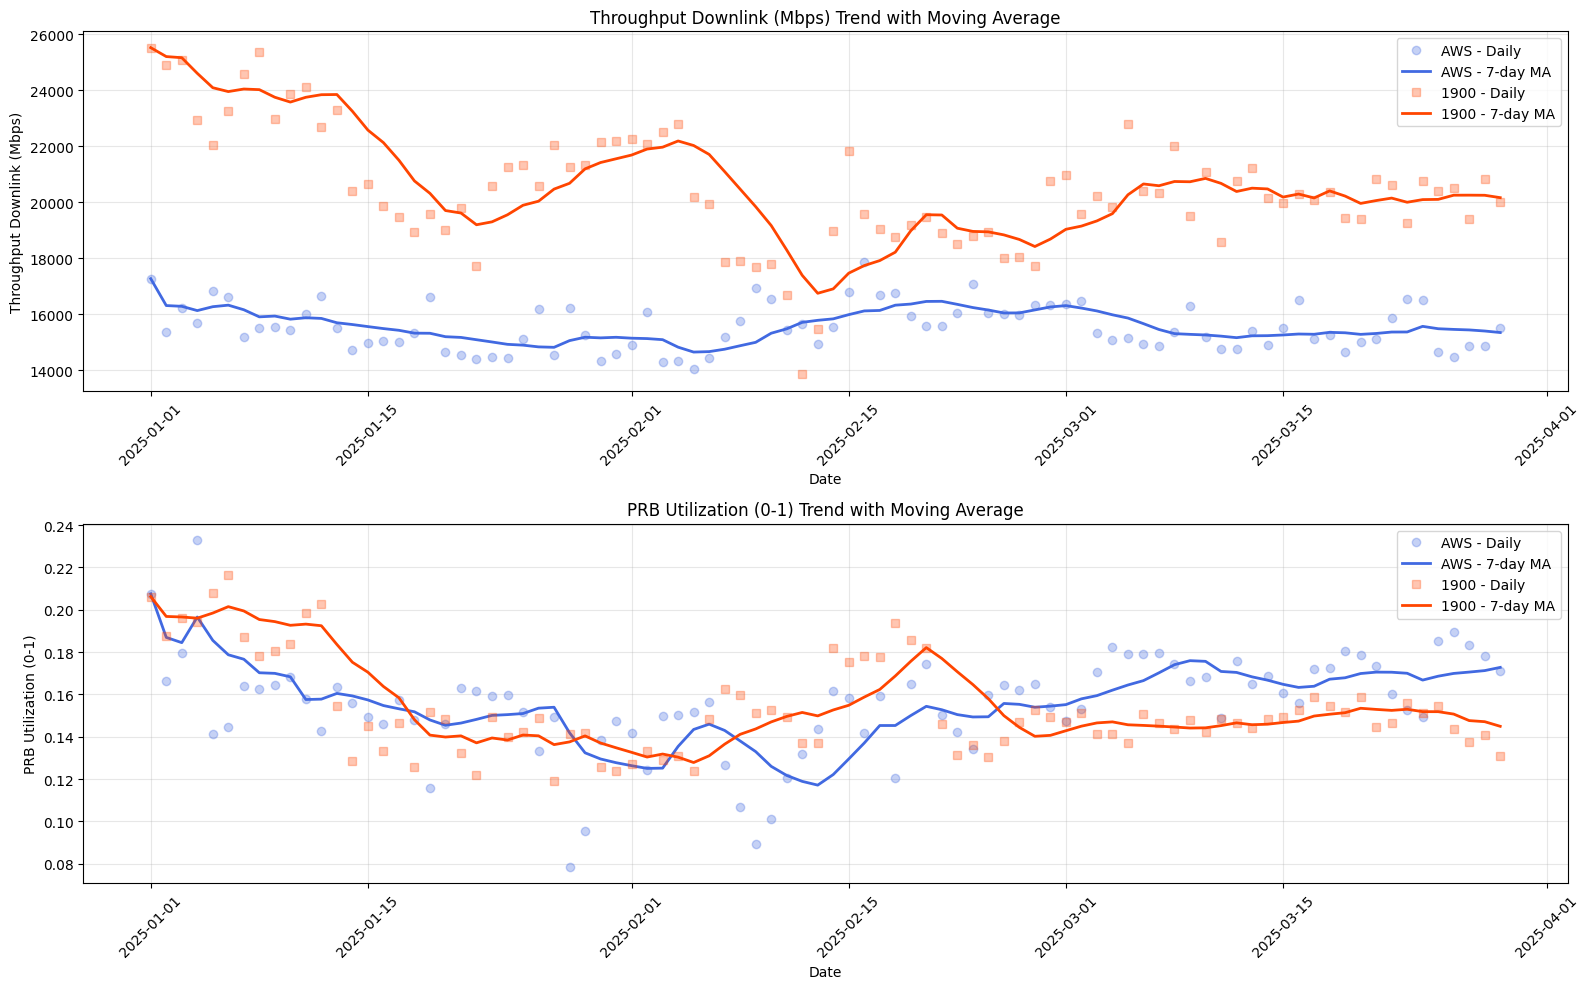

In [21]:
# Add time-related columns
df_clean['day_of_week'] = df_clean['DATE_SK'].dt.day_name()
df_clean['is_weekend'] = df_clean['DATE_SK'].dt.dayofweek >= 5
df_clean['week_of_year'] = df_clean['DATE_SK'].dt.isocalendar().week.astype(int)

# Calculate daily aggregates
daily_avg = df_clean.groupby(['DATE_SK', 'BANDA']).agg({
    'THP_DL': 'mean',
    'PRB_UTILIZACION_DL': 'mean',
    'efficiency': 'mean'
}).reset_index()

# Plot time series with moving average
plt.figure(figsize=(16, 10))

for i, kpi in enumerate(['THP_DL', 'PRB_UTILIZACION_DL']):
    plt.subplot(2, 1, i+1)
    
    for band, color, marker in zip(['AWS', '1900'], ['royalblue', 'orangered'], ['o', 's']):
        # Filter data for this band
        band_data = daily_avg[daily_avg['BANDA'] == band].copy()
        
        # Calculate 7-day moving average
        band_data[f'{kpi}_MA7'] = band_data[kpi].rolling(window=7, min_periods=1).mean()
        
        # Plot original data (semi-transparent) and moving average
        plt.plot(band_data['DATE_SK'], band_data[kpi], marker, alpha=0.3, color=color, label=f'{band} - Daily')
        plt.plot(band_data['DATE_SK'], band_data[f'{kpi}_MA7'], '-', linewidth=2, color=color, label=f'{band} - 7-day MA')
    
    title = 'Throughput Downlink (Mbps)' if kpi == 'THP_DL' else 'PRB Utilization (0-1)'
    plt.title(f'{title} Trend with Moving Average')
    plt.xlabel('Date')
    plt.ylabel(title)
    plt.grid(alpha=0.3)
    plt.legend()
    # Adjust date labels to prevent overlap
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.savefig(FIG_DIR / 'kpi_time_series.png', dpi=300, bbox_inches='tight')
plt.show()


#### 4.3.2 Weekly Patterns

INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


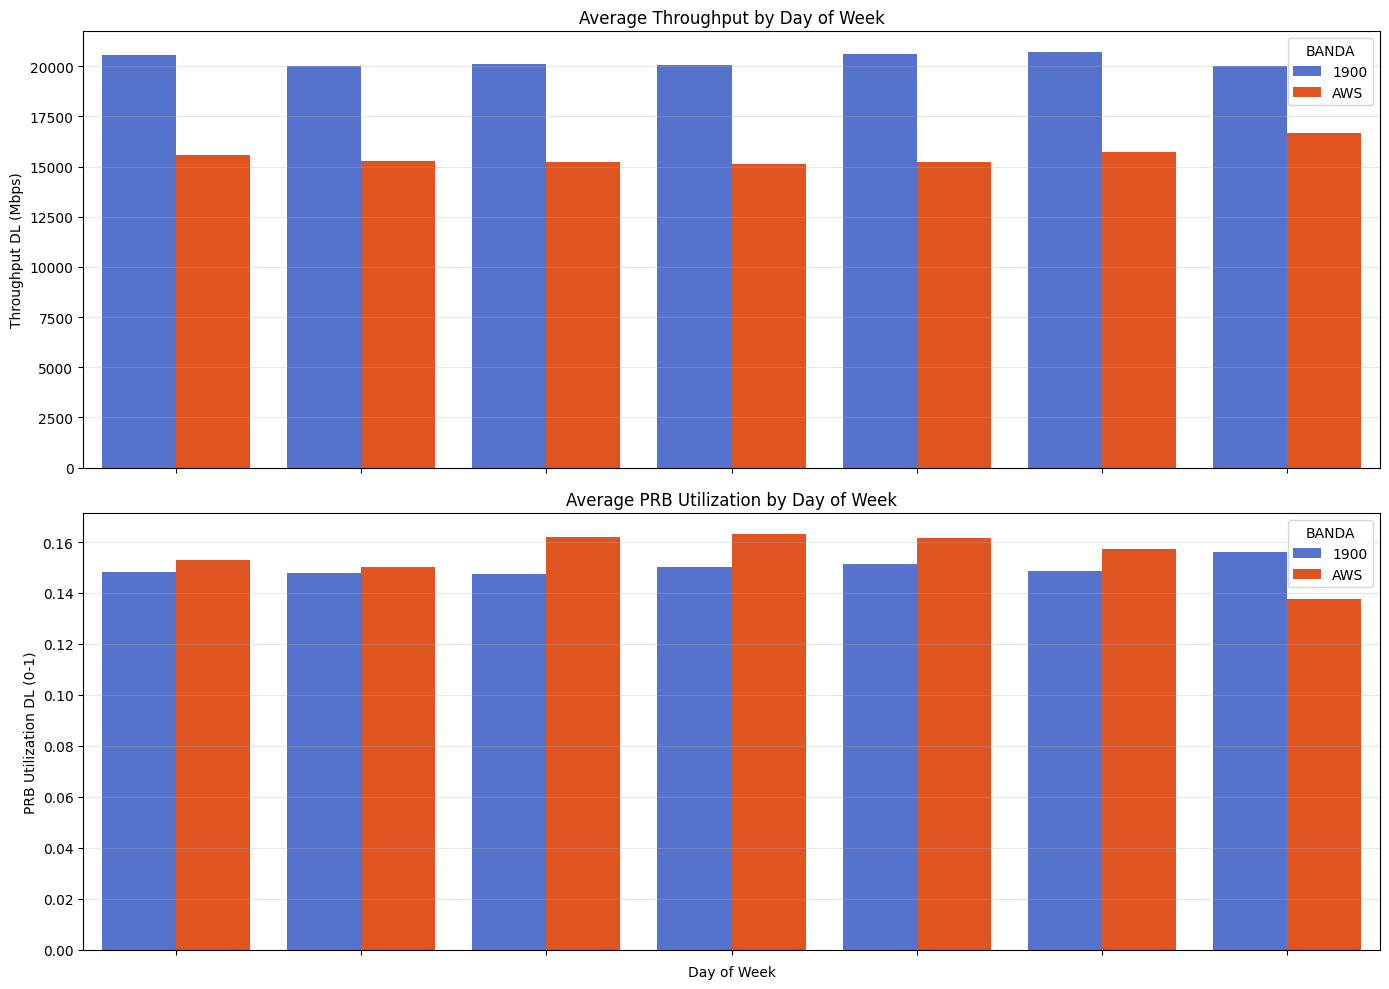

In [22]:
# Analyze KPIs by day of week
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = df_clean.groupby(['day_of_week', 'BANDA']).agg({
    'THP_DL': 'mean',
    'PRB_UTILIZACION_DL': 'mean',
    'efficiency': 'mean'
}).reset_index()

# Ensure correct day of week order
dow_avg['day_of_week'] = pd.Categorical(dow_avg['day_of_week'], categories=dow_order, ordered=True)
dow_avg = dow_avg.sort_values('day_of_week')

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot Throughput by day of week
sns.barplot(
    x='day_of_week', 
    y='THP_DL', 
    hue='BANDA',
    data=dow_avg,
    ax=axes[0],
    palette=['royalblue', 'orangered']
)
axes[0].set_title('Average Throughput by Day of Week')
axes[0].set_ylabel('Throughput DL (Mbps)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Plot PRB Utilization by day of week
sns.barplot(
    x='day_of_week', 
    y='PRB_UTILIZACION_DL', 
    hue='BANDA',
    data=dow_avg,
    ax=axes[1],
    palette=['royalblue', 'orangered']
)
axes[1].set_title('Average PRB Utilization by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('PRB Utilization DL (0-1)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kpi_by_day_of_week.png', dpi=300, bbox_inches='tight')
plt.show()



#### 4.3.3 Weekly Heatmap Analysis

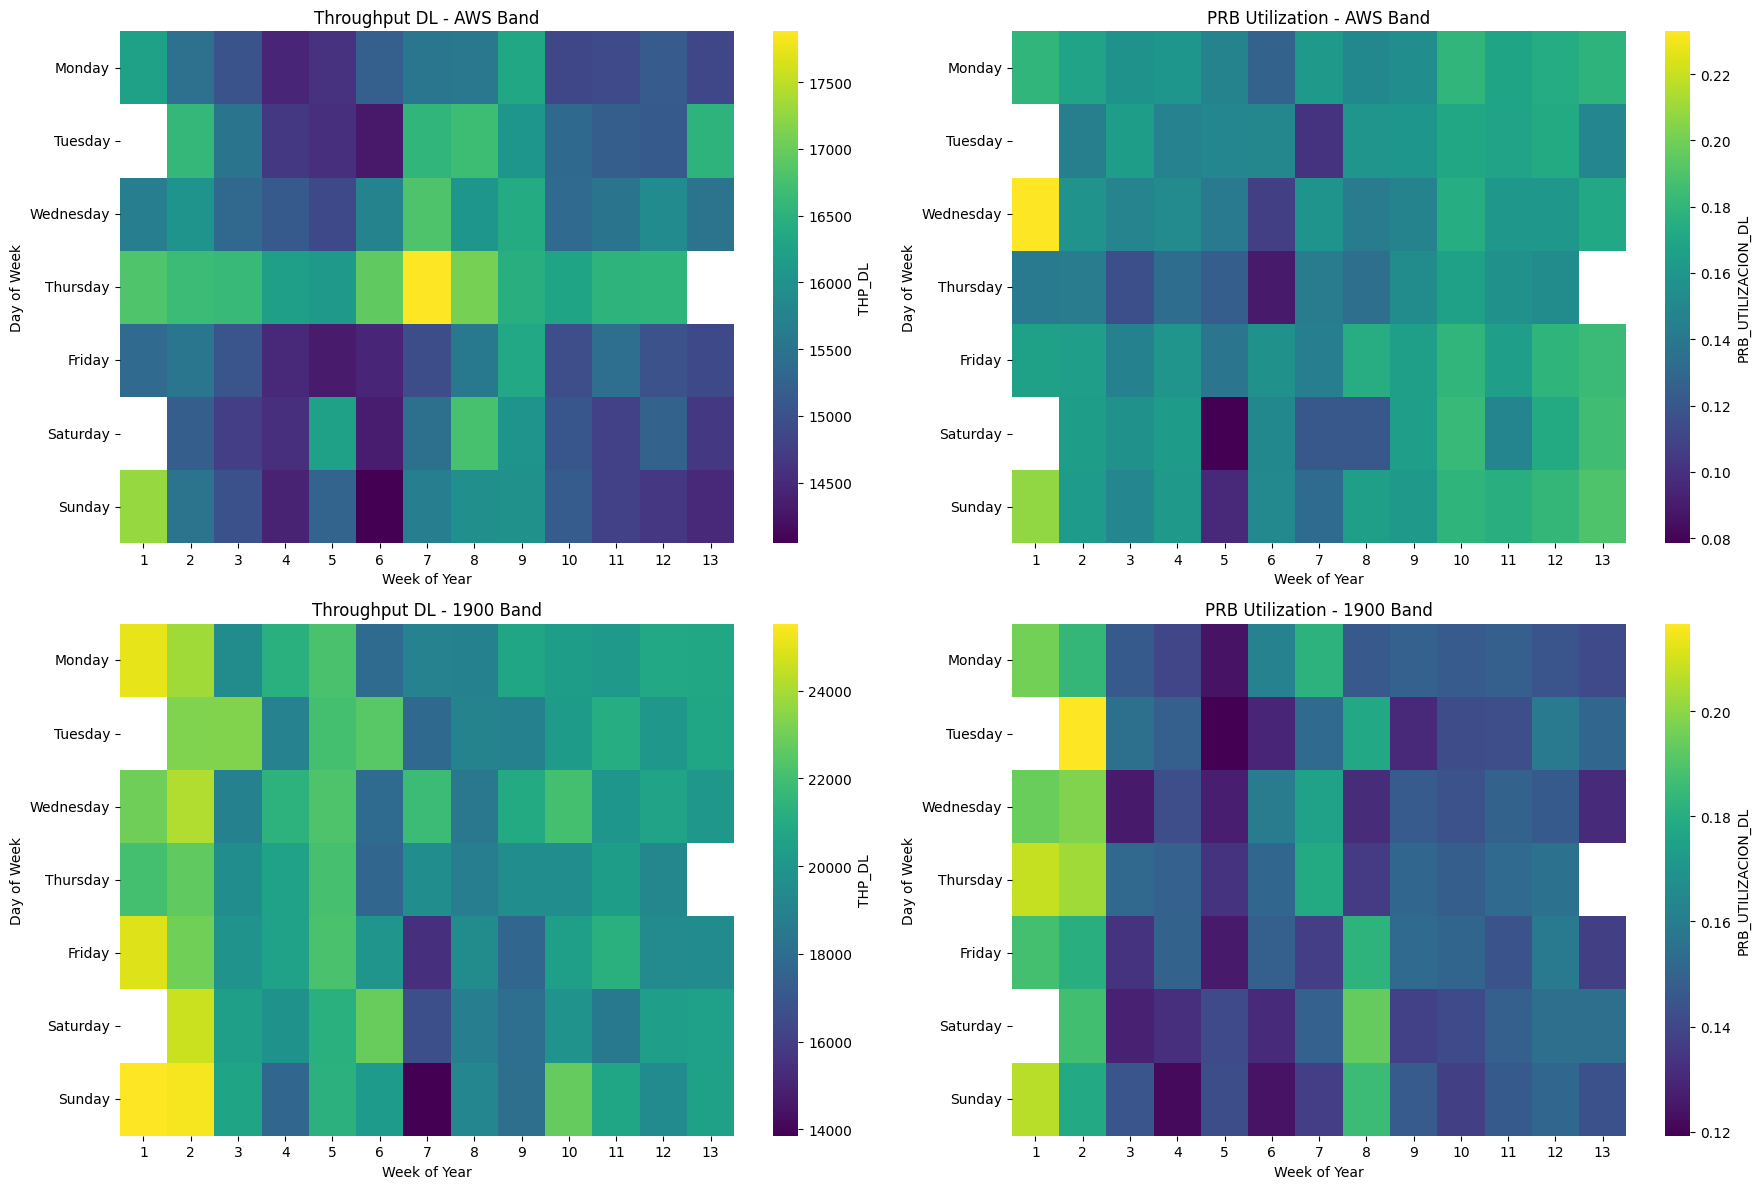

In [23]:

# Prepare data for weekly heatmap
weekly_data = []

for band in ['AWS', '1900']:
    for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
        # Create pivot table: days of week vs weeks
        band_data = df_clean[df_clean['BANDA'] == band].copy()
        
        # Group by week and day of week
        weekly_daily = band_data.groupby(['week_of_year', 'day_of_week'])[kpi].mean().reset_index()
        
        # Create matrix for heatmap
        pivot = weekly_daily.pivot(index='day_of_week', columns='week_of_year', values=kpi)
        
        # Save for visualization
        weekly_data.append((band, kpi, pivot))

# Visualize weekly heatmaps
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, (band, kpi, pivot) in enumerate(weekly_data):
    ax = axes[i]
    
    # Create heatmap
    sns.heatmap(pivot, ax=ax, cmap='viridis', annot=False, fmt='.2f', cbar_kws={'label': kpi})
    
    # Improve labels
    title = 'Throughput DL' if kpi == 'THP_DL' else 'PRB Utilization'
    ax.set_title(f'{title} - {band} Band')
    
    # Day of week labels
    day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    ax.set_yticklabels(day_labels)
    
    ax.set_xlabel('Week of Year')
    ax.set_ylabel('Day of Week')

plt.tight_layout()
plt.savefig(FIG_DIR / 'weekly_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()



### 4.4 Cell-Level Analysis

#### 4.4.1 Cell Performance Metrics

In [24]:

# Calculate statistics per cell
cell_stats = df_clean.groupby(['CELL_SK', 'BANDA']).agg({
    'THP_DL': ['mean', 'std', 'min', 'max', lambda x: x.quantile(0.95) - x.quantile(0.05)],
    'PRB_UTILIZACION_DL': ['mean', 'std', 'min', 'max', lambda x: x.quantile(0.95) - x.quantile(0.05)],
    'efficiency': ['mean', 'median']
}).reset_index()

# Flatten the multi-index columns
cell_stats.columns = ['_'.join(col).strip('_').replace('<lambda_0>', 'range90') for col in cell_stats.columns.values]

# Calculate coefficient of variation
cell_stats['THP_DL_cv'] = cell_stats['THP_DL_std'] / cell_stats['THP_DL_mean']
cell_stats['PRB_UTILIZACION_DL_cv'] = cell_stats['PRB_UTILIZACION_DL_std'] / cell_stats['PRB_UTILIZACION_DL_mean'].replace(0, np.nan)

# Display top cells by average throughput
print("\nTop 10 cells by average throughput:")
display(cell_stats.sort_values('THP_DL_mean', ascending=False).head(10))

# Display top cells by PRB utilization
print("\nTop 10 cells by average PRB utilization:")
display(cell_stats.sort_values('PRB_UTILIZACION_DL_mean', ascending=False).head(10))

# Display cells with highest throughput variability
print("\nTop 10 cells with highest throughput variability (CV):")
display(cell_stats.sort_values('THP_DL_cv', ascending=False).head(10))




Top 10 cells by average throughput:


CELL_SK BANDA   THP_DL_mean   THP_DL_std    THP_DL_min    THP_DL_max  \
326  1883900  1900  33162.449219  8233.473633  14326.909180  62172.460938   
88   1811390  1900  32644.449219  6622.831055  21611.582031  55922.789062   
274  1882039  1900  32129.796875  6859.220703      0.000000  42852.929688   
215  1864062   AWS  31580.367188  4703.761719  21638.277344  40904.308594   
328  1883901  1900  31306.548828  9976.068359  10744.868164  59536.152344   
256  1870022  1900  30543.513672  4028.375488  19264.576172  42159.207031   
201  1862433   AWS  30453.429688  5537.955078  19389.664062  40904.308594   
76   1776797  1900  29489.474609  2294.196777  26420.955078  32924.613281   
181  1861309   AWS  28930.394531  2695.246582  21640.396484  36380.691406   
72   1776795  1900  27570.500000  4549.289062  15524.992188  33710.992188   

     THP_DL_range90  PRB_UTILIZACION_DL_mean  PRB_UTILIZACION_DL_std  \
326    24704.259766                 0.028799                0.020401   
88     18864.665234                 0.063847                0.008811   
274    15642.732227                 0.093954                0.027390   
215    16541.054785                 0.094401                0.037334   
328    32335.087305                 0.020922                0.011852   
256    13826.396875                 0.156120                0.026746   
201    18516.233984                 0.048314                0.023360   
76      6166.386914                 0.119551                0.036067   
181     8759.767480                 0.057684                0.010843   
72     12520.550488                 0.094121                0.027782   

     PRB_UTILIZACION_DL_min  PRB_UTILIZACION_DL_max  \
326                0.010000                0.077083   
88                 0.046667                0.093333   
274                0.000000                0.143333   
215                0.022083                0.169130   
328                0.010000                0.056250   
256                0.108750                0.234167   
201                0.014583                0.103750   
76                 0.015385                0.155000   
181                0.037083                0.089583   
72                 0.017692                0.122500   

     PRB_UTILIZACION_DL_range90  efficiency_mean  efficiency_median  \
326                    0.056062     1.713307e+06       1.633489e+06   
88                     0.027854     5.240683e+05       4.943730e+05   
274                    0.071938     3.998849e+05       3.621374e+05   
215                    0.119812     4.333994e+05       3.596304e+05   
328                    0.029917     1.892590e+06       1.617577e+06   
256                    0.090146     2.024390e+05       1.985988e+05   
201                    0.070521     8.312504e+05       8.240673e+05   
76                     0.096803     3.687200e+05       2.367472e+05   
181                    0.032896     5.219031e+05       5.067154e+05   
72                     0.077849     3.372689e+05       2.760781e+05   

     THP_DL_cv  PRB_UTILIZACION_DL_cv  
326   0.248277               0.708392  
88    0.202878               0.138006  
274   0.213485               0.291529  
215   0.148946               0.395487  
328   0.318658               0.566493  
256   0.131890               0.171314  
201   0.181850               0.483508  
76    0.077797               0.301682  
181   0.093163               0.187975  
72    0.165006               0.295171


Top 10 cells by average PRB utilization:


CELL_SK BANDA   THP_DL_mean   THP_DL_std   THP_DL_min    THP_DL_max  \
333  1893659   AWS   7066.960938   919.767151  5324.749023   9433.193359   
331  1893658   AWS   7484.352051  1265.997192  5179.129395  10169.762695   
254  1870021  1900  13299.383789  5695.099609  4945.066895  25858.515625   
335  1893660   AWS   8449.905273  2160.899170  5732.209961  13764.345703   
99   1825594   AWS   6452.676758  3697.194824  2656.893311  16594.240234   
141  1826234   AWS   8180.986328  1242.900146  5167.764160  11114.474609   
155  1850678   AWS   9256.120117  2814.672852  5537.173340  16932.414062   
313  1883893   AWS  10333.059570  7207.732422     0.000000  20754.378906   
161  1855109   AWS  11485.280273  2429.843506  8058.450195  20818.332031   
97   1825593   AWS   8973.589844  3788.469971  3919.416992  18585.015625   

     THP_DL_range90  PRB_UTILIZACION_DL_mean  PRB_UTILIZACION_DL_std  \
333     3043.223193                 0.606676                0.026067   
331     4061.750049                 0.574019                0.046224   
254    16140.007617                 0.571020                0.075504   
335     6758.709741                 0.535510                0.065719   
99     10982.766089                 0.482618                0.109442   
141     3810.856812                 0.426983                0.062603   
155     9113.002515                 0.386869                0.077448   
313    17335.042480                 0.376169                0.255544   
161     7456.817773                 0.362845                0.079739   
97     11423.634058                 0.345941                0.123743   

     PRB_UTILIZACION_DL_min  PRB_UTILIZACION_DL_max  \
333                0.456667                0.615521   
331                0.430000                0.615521   
254                0.432083                0.745000   
335                0.386250                0.612917   
99                 0.196250                0.615521   
141                0.280833                0.615521   
155                0.168750                0.498750   
313                0.000000                0.615521   
161                0.047500                0.458750   
97                 0.109167                0.615521   

     PRB_UTILIZACION_DL_range90  efficiency_mean  efficiency_median  \
333                    0.038292     11704.252930       11489.408691   
331                    0.130604     13242.219727       12267.254883   
254                    0.243167     24760.349609       20712.472656   
335                    0.199729     16489.990234       13535.100098   
99                     0.339479     16469.935547        8829.655762   
141                    0.199524     19814.894531       19888.342773   
155                    0.233479     27065.224609       20908.419922   
313                    0.615521     27845.796875       27842.623047   
161                    0.232083     39958.363281       28076.391602   
97                     0.392351     37190.191406       21838.684570   

     THP_DL_cv  PRB_UTILIZACION_DL_cv  
333   0.130150               0.042966  
331   0.169153               0.080527  
254   0.428223               0.132227  
335   0.255731               0.122722  
99    0.572971               0.226767  
141   0.151925               0.146616  
155   0.304088               0.200193  
313   0.697541               0.679332  
161   0.211562               0.219759  
97    0.422180               0.357701


Top 10 cells with highest throughput variability (CV):


CELL_SK BANDA   THP_DL_mean    THP_DL_std    THP_DL_min    THP_DL_max  \
313  1883893   AWS  10333.059570   7207.732422      0.000000  20754.378906   
311  1883892   AWS  18294.818359  12460.186523      0.000000  32846.667969   
321  1883897   AWS  12906.595703   8774.526367      0.000000  21749.001953   
317  1883895   AWS  12872.458008   8684.469727      0.000000  21226.230469   
99   1825594   AWS   6452.676758   3697.194824   2656.893311  16594.240234   
254  1870021  1900  13299.383789   5695.099609   4945.066895  25858.515625   
97   1825593   AWS   8973.589844   3788.469971   3919.416992  18585.015625   
103  1825599   AWS  16334.094727   6127.366211   9479.338867  39936.050781   
261  1870674   AWS  11878.438477   3920.766602   5988.352051  21432.697266   
328  1883901  1900  31306.548828   9976.068359  10744.868164  59536.152344   

     THP_DL_range90  PRB_UTILIZACION_DL_mean  PRB_UTILIZACION_DL_std  \
313    17335.042480                 0.376169                0.255544   
311    29846.673926                 0.152676                0.105645   
321    21221.959277                 0.086257                0.061016   
317    20112.287988                 0.161525                0.113273   
99     10982.766089                 0.482618                0.109442   
254    16140.007617                 0.571020                0.075504   
97     11423.634058                 0.345941                0.123743   
103    19687.437207                 0.179366                0.079012   
261    12363.855151                 0.225289                0.081333   
328    32335.087305                 0.020922                0.011852   

     PRB_UTILIZACION_DL_min  PRB_UTILIZACION_DL_max  \
313                0.000000                0.615521   
311                0.000000                0.276667   
321                0.000000                0.185833   
317                0.000000                0.325833   
99                 0.196250                0.615521   
254                0.432083                0.745000   
97                 0.109167                0.615521   
103                0.010417                0.615521   
261                0.077500                0.364167   
328                0.010000                0.056250   

     PRB_UTILIZACION_DL_range90  efficiency_mean  efficiency_median  \
313                    0.615521     2.784580e+04       2.784262e+04   
311                    0.269854     1.235123e+05       1.199680e+05   
321                    0.158729     1.559977e+05       1.547438e+05   
317                    0.300646     8.208022e+04       8.533517e+04   
99                     0.339479     1.646994e+04       8.829656e+03   
254                    0.243167     2.476035e+04       2.071247e+04   
97                     0.392351     3.719019e+04       2.183868e+04   
103                    0.194021     1.630472e+05       7.893287e+04   
261                    0.251875     7.096906e+04       6.036872e+04   
328                    0.029917     1.892590e+06       1.617577e+06   

     THP_DL_cv  PRB_UTILIZACION_DL_cv  
313   0.697541               0.679332  
311   0.681077               0.691955  
321   0.679848               0.707371  
317   0.674655               0.701272  
99    0.572971               0.226767  
254   0.428223               0.132227  
97    0.422180               0.357701  
103   0.375127               0.440504  
261   0.330074               0.361018  
328   0.318658               0.566493

#### 4.4.2 High-Variability Cell Analysis


Cells with highest throughput variability:


CELL_SK BANDA  THP_DL_cv  PRB_UTILIZACION_DL_cv
313  1883893   AWS   0.697541               0.679332
311  1883892   AWS   0.681077               0.691955
321  1883897   AWS   0.679848               0.707371
317  1883895   AWS   0.674655               0.701272
99   1825594   AWS   0.572971               0.226767
254  1870021  1900   0.428223               0.132227

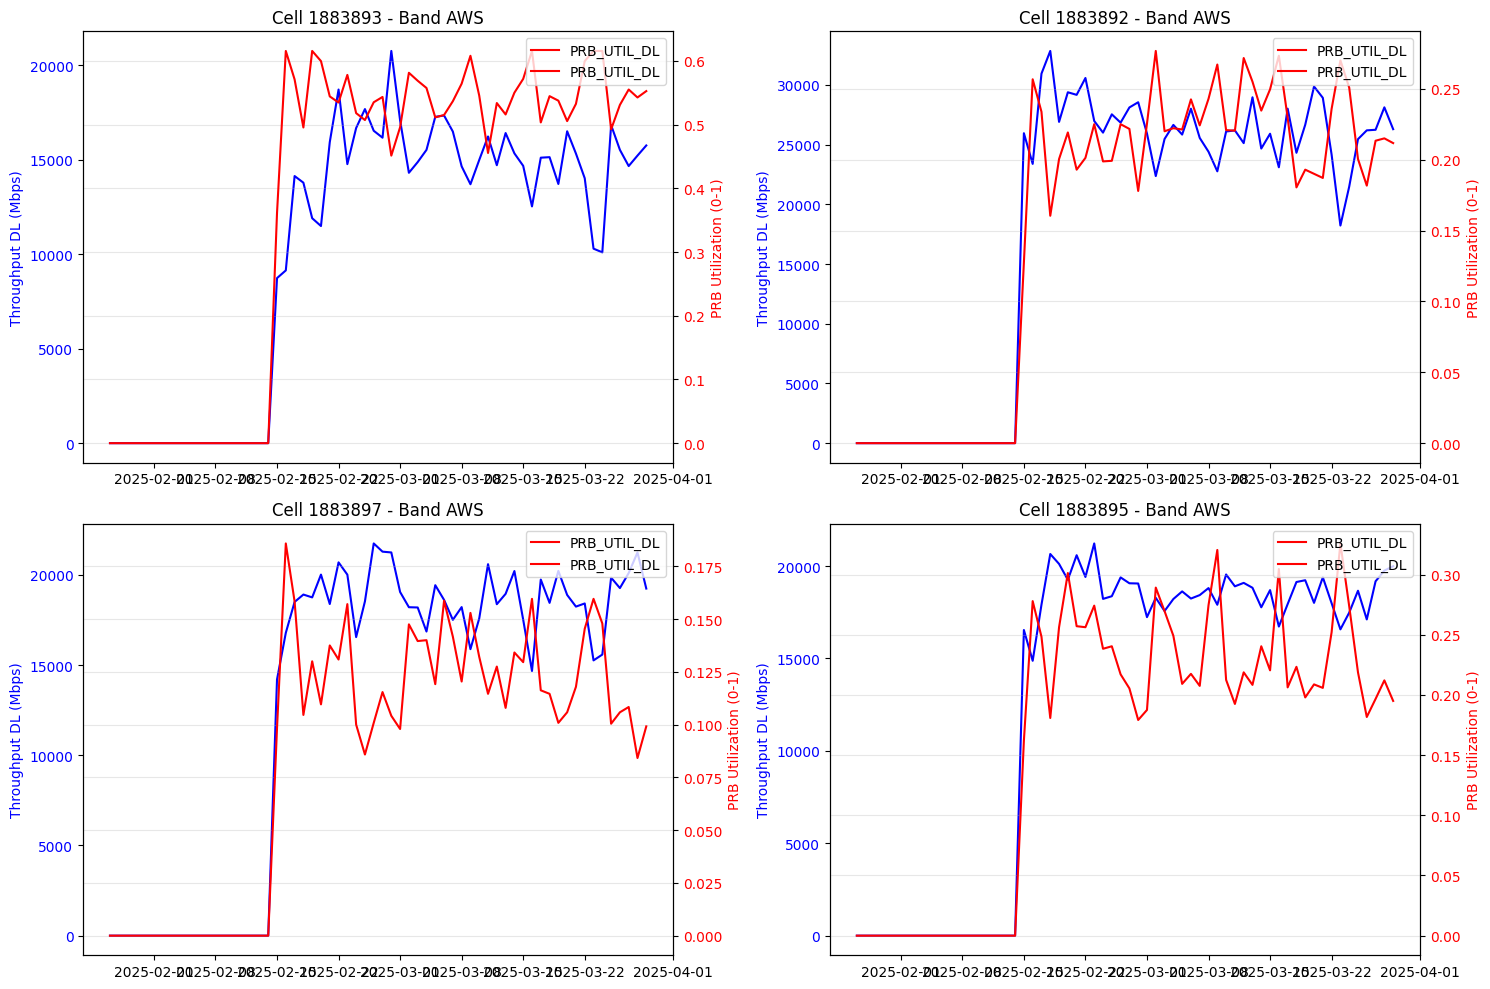

In [25]:

# Identify the cells with highest variability
top_variable_cells = cell_stats.nlargest(6, 'THP_DL_cv')[['CELL_SK', 'BANDA', 'THP_DL_cv', 'PRB_UTILIZACION_DL_cv']]
print("\nCells with highest throughput variability:")
display(top_variable_cells)

# Visualize behavior of most variable cells
plt.figure(figsize=(15, 10))

for i, (_, cell_row) in enumerate(top_variable_cells.head(4).iterrows()):
    plt.subplot(2, 2, i+1)
    
    # Get data for this cell
    cell_data = df_clean[(df_clean['CELL_SK'] == cell_row['CELL_SK']) & 
                        (df_clean['BANDA'] == cell_row['BANDA'])].sort_values('DATE_SK')
    
    # Line for THP_DL
    plt.plot(cell_data['DATE_SK'], cell_data['THP_DL'], 'b-', label='THP_DL')
    plt.ylabel('Throughput DL (Mbps)', color='b')
    plt.tick_params(axis='y', labelcolor='b')
    
    # Create second Y axis for PRB_UTILIZACION_DL
    ax2 = plt.twinx()
    ax2.plot(cell_data['DATE_SK'], cell_data['PRB_UTILIZACION_DL'], 'r-', label='PRB_UTIL_DL')
    ax2.set_ylabel('PRB Utilization (0-1)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add title with cell info
    plt.title(f"Cell {cell_row['CELL_SK']} - Band {cell_row['BANDA']}")
    plt.grid(alpha=0.3)
    
    # Rotate x-axis labels to prevent overlap
    plt.xticks(rotation=45)
    
    # Create combined legend
    lines_1, labels_1 = plt.gca().get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.savefig(FIG_DIR / 'variable_cells_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()



#### 4.4.3 Cell Performance Distribution

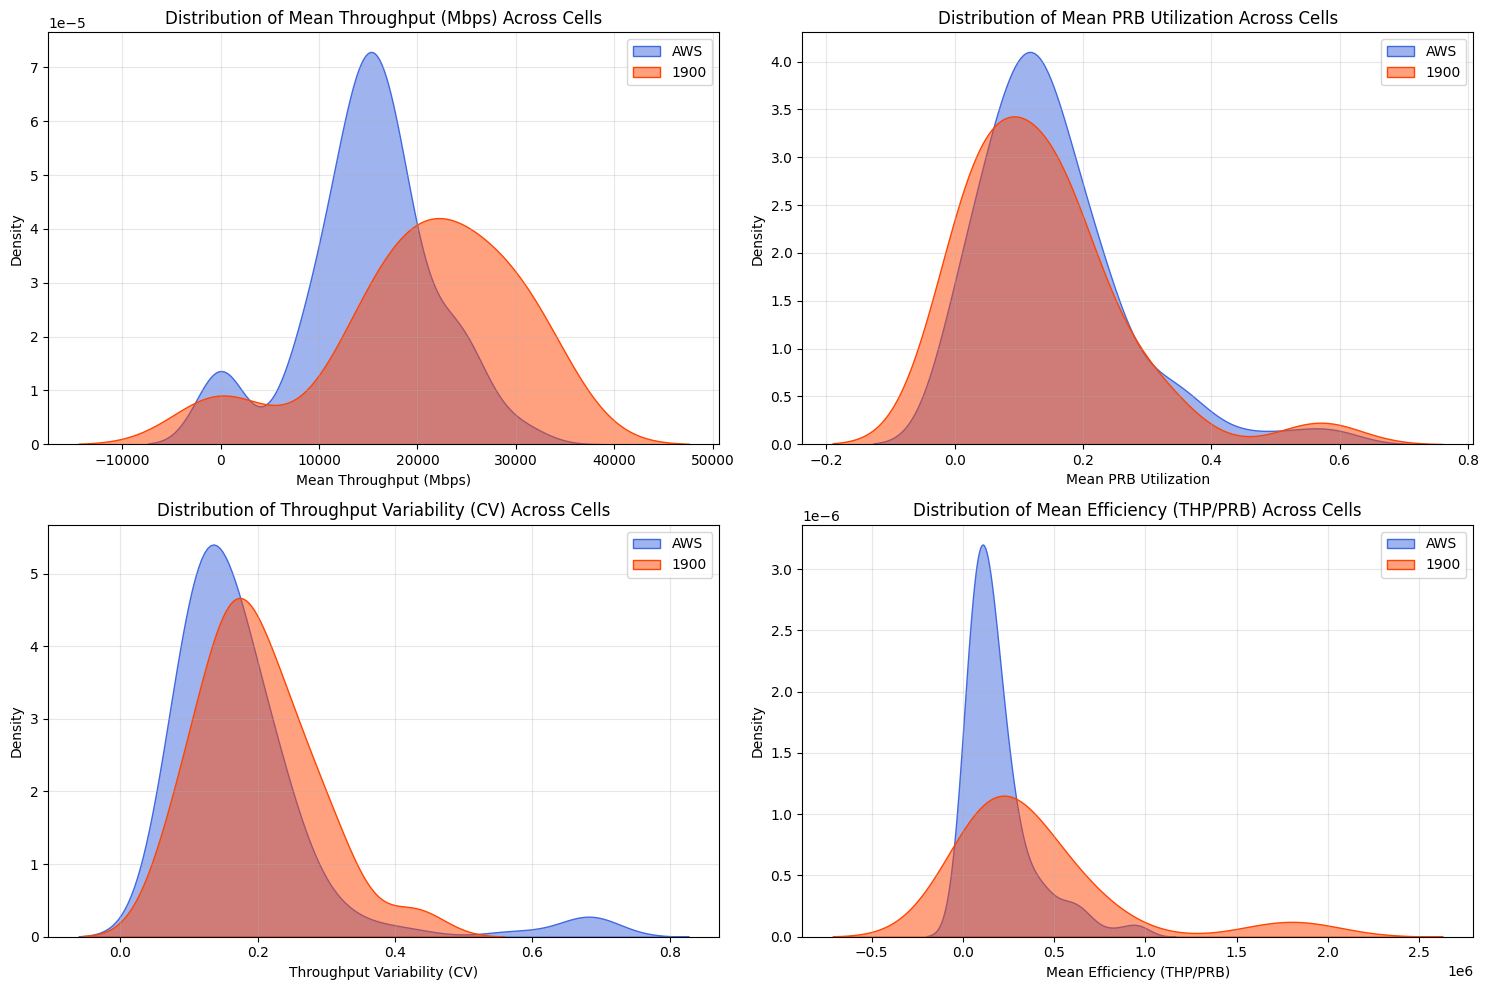

In [26]:

# Analyze the distribution of cell performance
plt.figure(figsize=(15, 10))

# Plot distributions of cell-level metrics
metrics = [
    ('THP_DL_mean', 'Mean Throughput (Mbps)'),
    ('PRB_UTILIZACION_DL_mean', 'Mean PRB Utilization'),
    ('THP_DL_cv', 'Throughput Variability (CV)'),
    ('efficiency_mean', 'Mean Efficiency (THP/PRB)')
]

for i, (metric, title) in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    
    for band, color in zip(['AWS', '1900'], ['royalblue', 'orangered']):
        band_cells = cell_stats[cell_stats['BANDA'] == band]
        
        sns.kdeplot(
            band_cells[metric].dropna(), 
            fill=True,
            alpha=0.5,
            color=color,
            label=band
        )
    
    plt.title(f'Distribution of {title} Across Cells')
    plt.xlabel(title)
    plt.ylabel('Density')
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / 'cell_performance_distributions.png', dpi=300, bbox_inches='tight')
plt.show()



### 4.5 Anomaly Detection

#### 4.5.1 Univariate Outlier Analysis

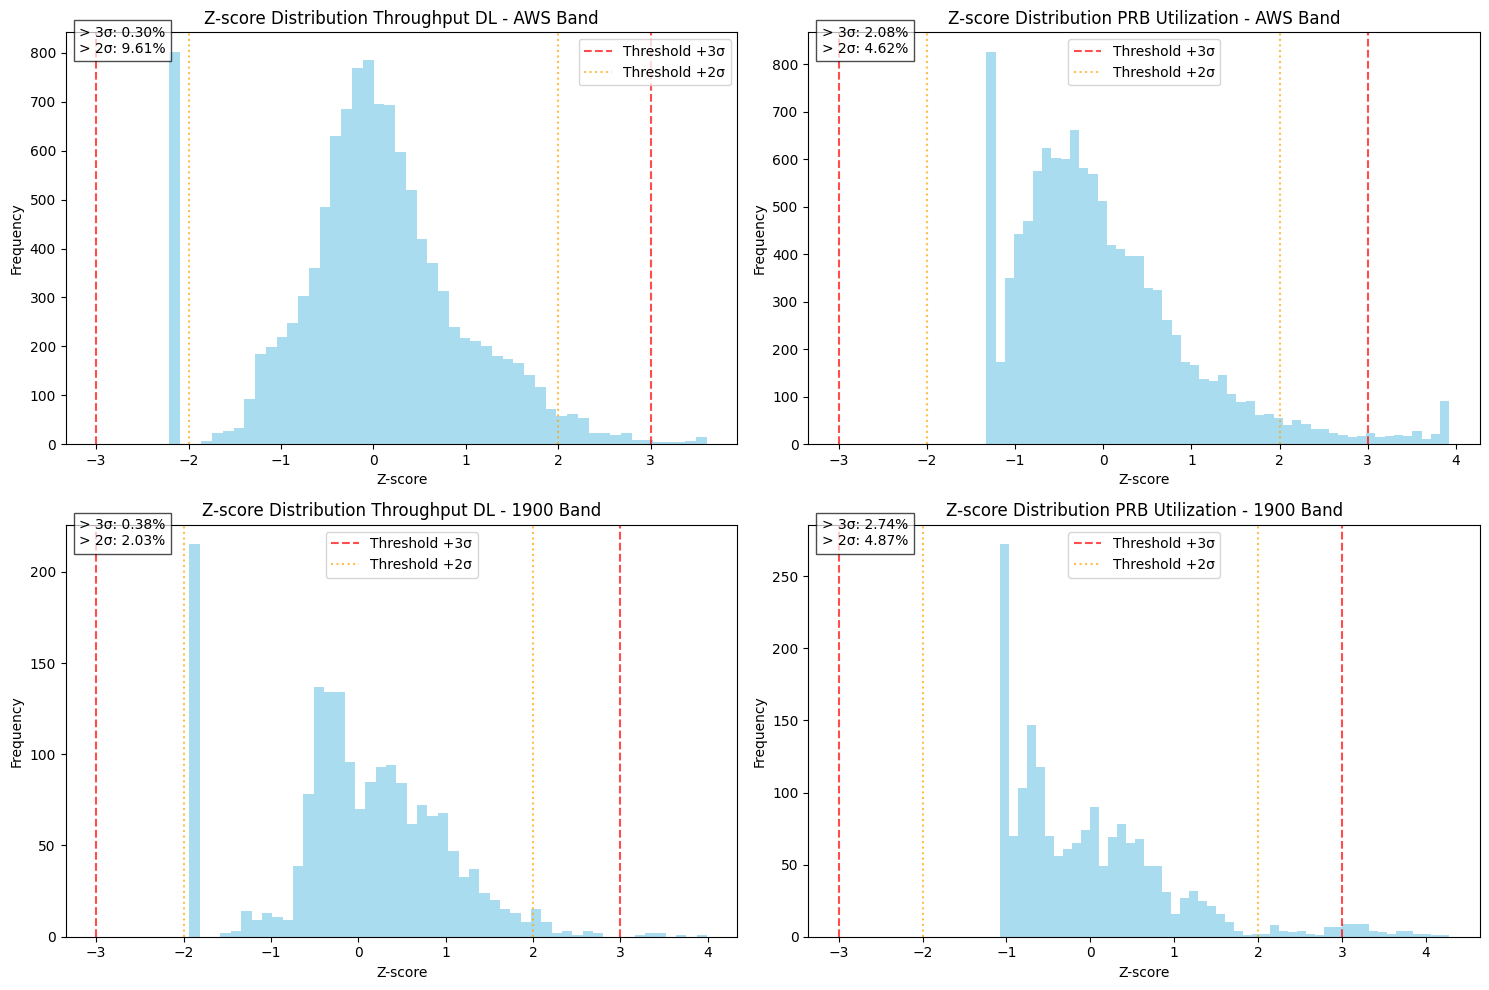

In [27]:
# Analyze Z-scores to identify univariate outliers
from scipy import stats

plt.figure(figsize=(15, 10))
counter = 1

for band in ['AWS', '1900']:
    for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
        plt.subplot(2, 2, counter)
        
        # Filter data for this band
        band_data = df_clean[df_clean['BANDA'] == band][kpi]
        
        # Calculate Z-scores
        z_scores = stats.zscore(band_data)
        
        # Create histogram
        plt.hist(z_scores, bins=50, alpha=0.7, color='skyblue')
        
        # Add lines for common anomaly thresholds
        plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='Threshold +3σ')
        plt.axvline(x=-3, color='red', linestyle='--', alpha=0.7)
        plt.axvline(x=2, color='orange', linestyle=':', alpha=0.7, label='Threshold +2σ')
        plt.axvline(x=-2, color='orange', linestyle=':', alpha=0.7)
        
        # Add text with percentage of anomalies
        anomalies_3sigma = (np.abs(z_scores) > 3).mean() * 100
        anomalies_2sigma = (np.abs(z_scores) > 2).mean() * 100
        
        plt.text(0.02, 0.95, f'> 3σ: {anomalies_3sigma:.2f}%\n> 2σ: {anomalies_2sigma:.2f}%', 
                 transform=plt.gca().transAxes, fontsize=10, 
                 bbox=dict(facecolor='white', alpha=0.7))
        
        title = 'Throughput DL' if kpi == 'THP_DL' else 'PRB Utilization'
        plt.title(f'Z-score Distribution {title} - {band} Band')
        plt.xlabel('Z-score')
        plt.ylabel('Frequency')
        plt.legend()
        
        counter += 1

plt.tight_layout()
plt.savefig(FIG_DIR / 'z_score_distributions.png', dpi=300, bbox_inches='tight')
plt.show()



#### 4.5.2 Multivariate Anomaly Detection

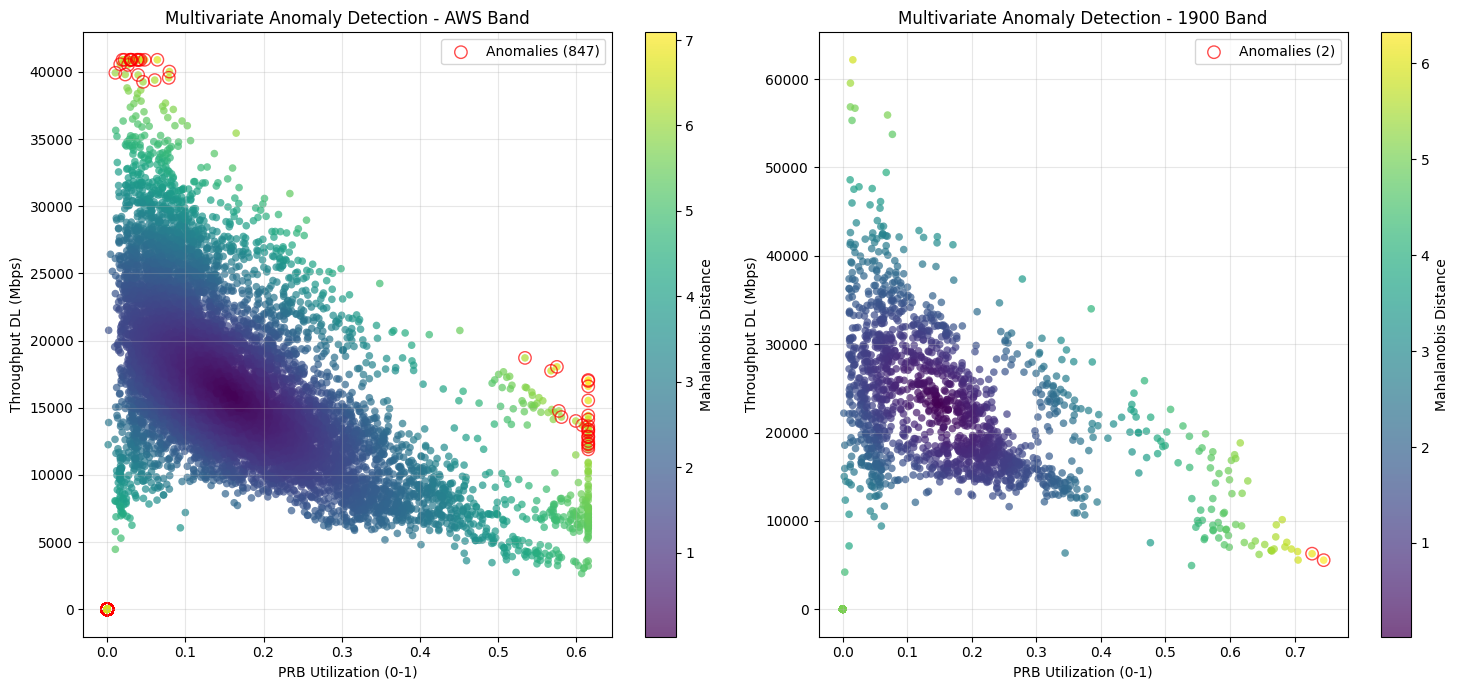

In [28]:
# Detect multivariate anomalies using Mahalanobis distance
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import MinCovDet

plt.figure(figsize=(15, 7))

for i, band in enumerate(['AWS', '1900']):
    plt.subplot(1, 2, i+1)
    
    # Get data for this band
    band_data = df_clean[df_clean['BANDA'] == band][['THP_DL', 'PRB_UTILIZACION_DL']]
    
    # Remove NaN
    band_data = band_data.dropna()
    
    if len(band_data) < 10:  # Need sufficient data
        continue
    
    # Use robust covariance estimator
    robust_cov = MinCovDet().fit(band_data)
    
    # Calculate center and covariance matrix
    center = robust_cov.location_
    cov_matrix = robust_cov.covariance_
    
    # Invert covariance matrix
    inv_cov = np.linalg.inv(cov_matrix)
    
    # Calculate Mahalanobis distance for each point
    mahala_dist = []
    for idx, row in band_data.iterrows():
        dist = mahalanobis(row, center, inv_cov)
        mahala_dist.append(dist)
    
    # Chi-square threshold (95%) for 2 dimensions
    chi2_threshold = stats.chi2.ppf(0.95, df=2)
    
    # Create scatter plot colored by distance
    scatter = plt.scatter(
        band_data['PRB_UTILIZACION_DL'],
        band_data['THP_DL'],
        c=mahala_dist,
        cmap='viridis',
        alpha=0.7,
        s=30,
        edgecolor='none'
    )
    
    # Mark anomalous points
    anomalies = np.array(mahala_dist) > chi2_threshold
    anomaly_points = band_data[anomalies]
    
    if len(anomaly_points) > 0:
        plt.scatter(
            anomaly_points['PRB_UTILIZACION_DL'],
            anomaly_points['THP_DL'],
            edgecolor='red',
            facecolor='none',
            s=80,
            linewidth=1,
            alpha=0.7,
            label=f'Anomalies ({sum(anomalies)})'
        )
    
    plt.colorbar(scatter, label='Mahalanobis Distance')
    plt.title(f'Multivariate Anomaly Detection - {band} Band')
    plt.xlabel('PRB Utilization (0-1)')
    plt.ylabel('Throughput DL (Mbps)')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'multivariate_anomalies.png', dpi=300, bbox_inches='tight')
plt.show()


#### 4.5.3 Temporal Anomaly Analysis


Cells with temporal anomalies (days with extreme values):


CELL_SK BANDA  anomaly_days
79   1825614   AWS             4
61   1825599   AWS             4
49   1355626   AWS             4
31   1287036   AWS             4
29   1287035   AWS             4
27   1284736   AWS             4
105  1855109   AWS             4
23   1284734   AWS             3
13   1216557   AWS             3
7    1216276   AWS             3

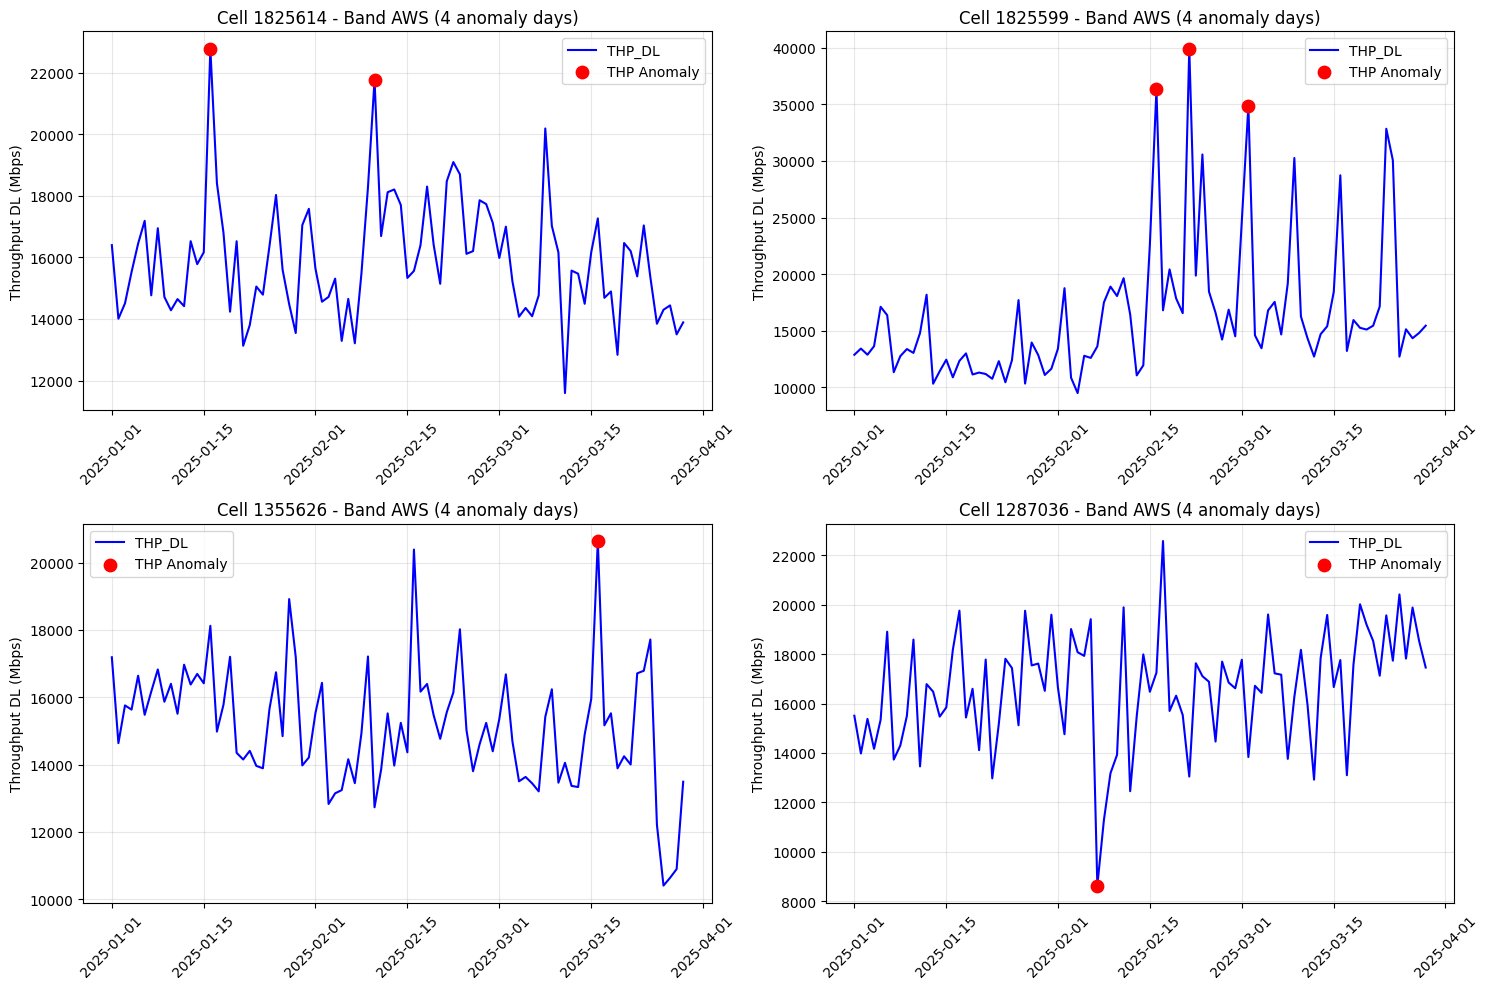


Summary of detected anomalies (using 3σ threshold):


Band                 KPI  High Anomalies (%)  Low Anomalies (%)  \
0   AWS              THP_DL            0.304507                0.0   
1   AWS  PRB_UTILIZACION_DL            2.079346                0.0   
2  1900              THP_DL            0.383352                0.0   
3  1900  PRB_UTILIZACION_DL            2.738226                0.0   

   Total Anomalies (%)  
0             0.304507  
1             2.079346  
2             0.383352  
3             2.738226

In [29]:
# Identify cells with anomalous temporal behavior
# Calculate daily z-scores for each cell
daily_cell_kpis = df_clean.groupby(['DATE_SK', 'CELL_SK', 'BANDA'])[['THP_DL', 'PRB_UTILIZACION_DL']].mean().reset_index()

# Create empty dataframe to store anomaly scores
temporal_anomalies = pd.DataFrame()

# Process each cell separately
for (cell, band), group in daily_cell_kpis.groupby(['CELL_SK', 'BANDA']):
    if len(group) >= 7:  # Need at least a week of data
        # Calculate z-scores for this cell's metrics
        for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
            group[f'{kpi}_zscore'] = stats.zscore(group[kpi])
        
        # Flag days with extreme values
        group['is_thp_anomaly'] = abs(group['THP_DL_zscore']) > 3
        group['is_prb_anomaly'] = abs(group['PRB_UTILIZACION_DL_zscore']) > 3
        group['is_anomaly'] = group['is_thp_anomaly'] | group['is_prb_anomaly']
        
        # Add to results if anomalies found
        if group['is_anomaly'].any():
            temporal_anomalies = pd.concat([temporal_anomalies, group])

# Display cells with anomalies
anomaly_counts = temporal_anomalies.groupby(['CELL_SK', 'BANDA'])['is_anomaly'].sum().reset_index()
anomaly_counts = anomaly_counts.rename(columns={'is_anomaly': 'anomaly_days'})
anomaly_counts = anomaly_counts.sort_values('anomaly_days', ascending=False)

print("\nCells with temporal anomalies (days with extreme values):")
display(anomaly_counts.head(10))

# Visualize anomalies for top cells
top_anomaly_cells = anomaly_counts.head(4)
plt.figure(figsize=(15, 10))

for i, (_, cell_row) in enumerate(top_anomaly_cells.iterrows()):
    plt.subplot(2, 2, i+1)
    
    # Get data for this cell
    cell_anomalies = temporal_anomalies[
        (temporal_anomalies['CELL_SK'] == cell_row['CELL_SK']) & 
        (temporal_anomalies['BANDA'] == cell_row['BANDA'])
    ].sort_values('DATE_SK')
    
    # Plot THP_DL
    plt.plot(cell_anomalies['DATE_SK'], cell_anomalies['THP_DL'], 'b-', label='THP_DL')
    
    # Highlight anomalies
    thp_anomalies = cell_anomalies[cell_anomalies['is_thp_anomaly']]
    prb_anomalies = cell_anomalies[cell_anomalies['is_prb_anomaly']]
    
    plt.scatter(thp_anomalies['DATE_SK'], thp_anomalies['THP_DL'], 
                color='red', s=80, label='THP Anomaly', zorder=5)
    
    plt.title(f"Cell {cell_row['CELL_SK']} - Band {cell_row['BANDA']} ({cell_row['anomaly_days']} anomaly days)")
    plt.ylabel('Throughput DL (Mbps)')
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / 'temporal_anomalies.png', dpi=300, bbox_inches='tight')
plt.show()

# Create summary of anomaly detection results
anomaly_summary = pd.DataFrame()

for band in ['AWS', '1900']:
    for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
        # Calculate Z-scores
        band_data = df_clean[df_clean['BANDA'] == band][kpi]
        z_scores = stats.zscore(band_data)
        
        # Calculate anomaly metrics
        high_anomalies = (z_scores > 3).mean() * 100
        low_anomalies = (z_scores < -3).mean() * 100
        total_anomalies = (np.abs(z_scores) > 3).mean() * 100
        
        # Add to summary
        anomaly_summary = pd.concat([anomaly_summary, pd.DataFrame({
            'Band': [band],
            'KPI': [kpi],
            'High Anomalies (%)': [high_anomalies],
            'Low Anomalies (%)': [low_anomalies],
            'Total Anomalies (%)': [total_anomalies]
        })])

print("\nSummary of detected anomalies (using 3σ threshold):")
display(anomaly_summary.reset_index(drop=True))

### 4.6 Key Findings from EDA

In this section we distill the most important insights uncovered so far. These findings will inform our anomaly-detection strategy, model design, and the operational recommendations that follow.

---

#### 4.6.1 Band-to-Band Comparisons

* **Throughput (THP\_DL):**

  * The 1900 MHz band consistently outperforms AWS across all percentiles (e.g. 99 %ile: \~45 000 Mbps vs. \~32 000 Mbps).
  * Median throughput is roughly 20 Mbps for 1900 vs. 16 Mbps for AWS.
* **PRB Utilization:**

  * 1900 shows slightly higher utilization overall (median \~0.15 vs. \~0.13).
  * Peak utilization at the 99 %ile reaches \~0.63 for 1900 vs. \~0.59 for AWS.
* **Statistical Significance:**

  * Non-parametric tests (Mann-Whitney U) confirm these differences are highly significant (p < 0.01) with median throughput \~25 % higher in 1900.

---

#### 4.6.2 Throughput – Utilization Relationship

* **Overall Correlation:**

  * Very weak linear correlation overall (Pearson ≈ 0.02), suggesting non-linear dynamics.
* **By Utilization Segment:**

  * **Low (0–25 %):** Mild positive correlation (AWS ≈ 0.09, 1900 ≈ 0.20), indicating throughput increases as PRB load rises from idle.
  * **Medium-Low (25–50 %):** Strong negative correlation in AWS (≈ –0.46) and mild in 1900 (≈ 0.04), suggesting congestion effects become dominant beyond ∼30 % PRB.
  * **Medium-High (50–75 %):** Weak negative relationship (AWS ≈ –0.08, 1900 ≈ –0.59), indicating sharp throughput degradation under heavy load in 1900.
  * **High (75–100 %):** Correlation flattens near zero, reflecting saturation where additional PRB usage no longer improves throughput.

---

#### 4.6.3 Temporal Patterns

* **Daily Trends:**

  * Both bands show a slight downward drift in January, a pronounced dip in mid-February, followed by recovery in early March.
  * AWS daily average oscillates around 15 000–16 500 Mbps; 1900 around 18 000–22 000 Mbps.
* **Weekly Seasonality:**

  * Throughput dips mid-week (Tue–Thu) and peaks on weekends, especially Saturday.
  * PRB utilization follows a similar weekly cycle, rising Friday–Sunday.
* **Efficiency (THP/PRB):**

  * AWS is more efficient at low utilization (< 25 %), while 1900 efficiency peaks at moderate utilization (25–50 %).

---

#### 4.6.4 Cell-Level Variability

* **Top-Performing Cells:**

  * A small subset of cells consistently delivers > 30 000 Mbps (1900) or > 25 000 Mbps (AWS).
* **High-Variability Cells:**

  * The six cells with the highest coefficient of variation show bursts and deep troughs; four representative cells exhibit 4–6 days of extreme spikes/drops in the period.
* **Distribution Across Cells:**

  * Throughput and PRB utilization distributions vary widely—some cells are heavily loaded but low-throughput, others lightly loaded yet high-throughput.

---

#### 4.6.5 Anomaly Insights

* **Univariate Outliers (±3σ):**

  * Throughput: \~0.3 % of AWS points and \~0.4 % of 1900 points lie beyond ±3 σ.
  * PRB Utilization: \~2 % of AWS and \~2.7 % of 1900 points exceed ±3 σ.
* **Multivariate Anomalies (Mahalanobis):**

  * AWS: \~847 anomalous combinations of (THP, PRB) flagged, concentrated at very high throughput or utilization extremes.
  * 1900: Only 2 multivariate outliers, indicating more homogenous joint behavior.
* **Temporal Anomalies:**

  * Several cells exhibit 3–8 days with extreme daily z-scores (> |3|) in either KPI; these should be prioritized for investigation.

---

### Implications for Modeling and Operations

1. **Non-linear modeling** (e.g., polynomial or tree-based) will better capture the throughput–utilization interplay than simple linear models.
2. **Band-specific thresholds** for alerts should reflect the differing KPI distributions and anomaly rates.
3. **Cell-level baselines** are essential: high-variability cells need customized models or dynamic thresholds.
4. **Temporal contexts** (e.g., day-of-week effects) should be incorporated into anomaly detection to avoid false positives during known load patterns.


## 5. Feature Engineering

In this section, we transform our cleaned telecommunications data into a rich set of features to enhance our anomaly detection capabilities. While the original KPIs (THP_DL and PRB_UTILIZACION_DL) provide valuable information, they alone may not capture the complex patterns that indicate network anomalies.

Our feature engineering process will create new variables that help distinguish between normal network fluctuations and truly problematic behaviors, focusing on:

- **Temporal features:** Lag values, rolling statistics, and trends to capture how metrics change over time
- **Ratio and change features:** Efficiency metrics, day-over-day changes, and deviations from expected values
- **Statistical features:** Z-scores and percentile ranks at different aggregation levels (global, band-specific, cell-specific)
- **Temporal context:** Day of week patterns, weekend effects, and cyclical encodings to capture recurring patterns

These engineered features will provide important context for our anomaly detection models, allowing them to better identify unusual behaviors that could represent risks of speed reduction or high load growth in the telecommunications network.

After creating the features, we'll analyze their relationships, handle missing values, and select the most relevant subset for our modeling approach.

In [30]:
# Create a copy of the cleaned data for feature engineering
df_features = df_clean.copy()
logging.info(f"Starting feature engineering with {len(df_features):,} rows")


INFO | Starting feature engineering with 13,320 rows


### 5.1 Temporal Features

#### 5.1.1 Lag Features

Creating lag features...


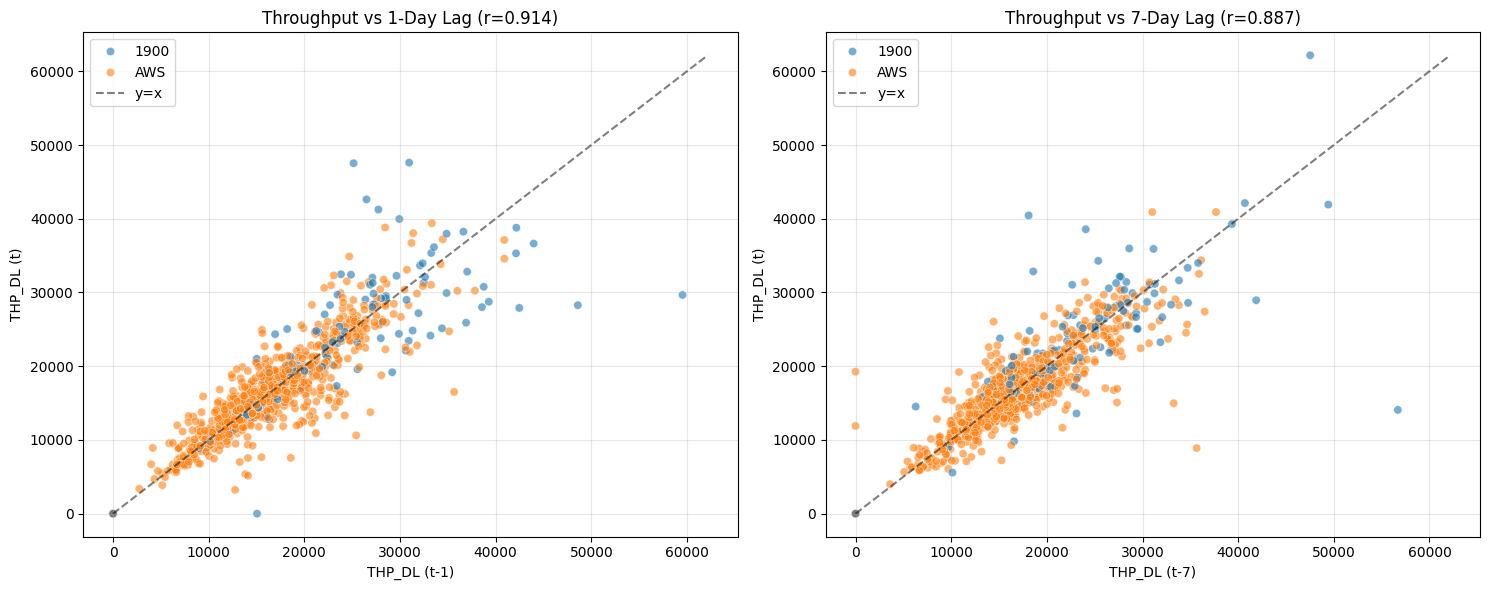

In [31]:
# Sort data by cell and date to ensure proper sequence for time-based features
df_features = df_features.sort_values(['CELL_SK', 'BANDA', 'DATE_SK'])

# Create lag features to capture previous values
print("Creating lag features...")
for lag in [1, 3, 7]:  # Previous day, 3 days ago, and week ago
    for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
        df_features[f'{kpi}_lag{lag}'] = df_features.groupby(['CELL_SK', 'BANDA'])[kpi].shift(lag)

# Visualize the relationship between current and lagged values
plt.figure(figsize=(15, 6))

for i, lag in enumerate([1, 7]):
    plt.subplot(1, 2, i+1)
    
    # Create scatter plot of current vs lagged throughput
    sns.scatterplot(
        x=f'THP_DL_lag{lag}',
        y='THP_DL',
        hue='BANDA',
        data=df_features.sample(1000),  # Sample for clearer visualization
        alpha=0.6
    )
    
    # Add reference line
    plt.plot([0, df_features['THP_DL'].max()], [0, df_features['THP_DL'].max()], 
             'k--', alpha=0.5, label='y=x')
    
    # Calculate and display correlation
    corr = df_features['THP_DL'].corr(df_features[f'THP_DL_lag{lag}'])
    plt.title(f'Throughput vs {lag}-Day Lag (r={corr:.3f})')
    plt.xlabel(f'THP_DL (t-{lag})')
    plt.ylabel('THP_DL (t)')
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / 'lag_feature_relationship.png', dpi=300, bbox_inches='tight')
plt.show()


#### 5.1.2 Rolling Window Statistics

Creating rolling window features...


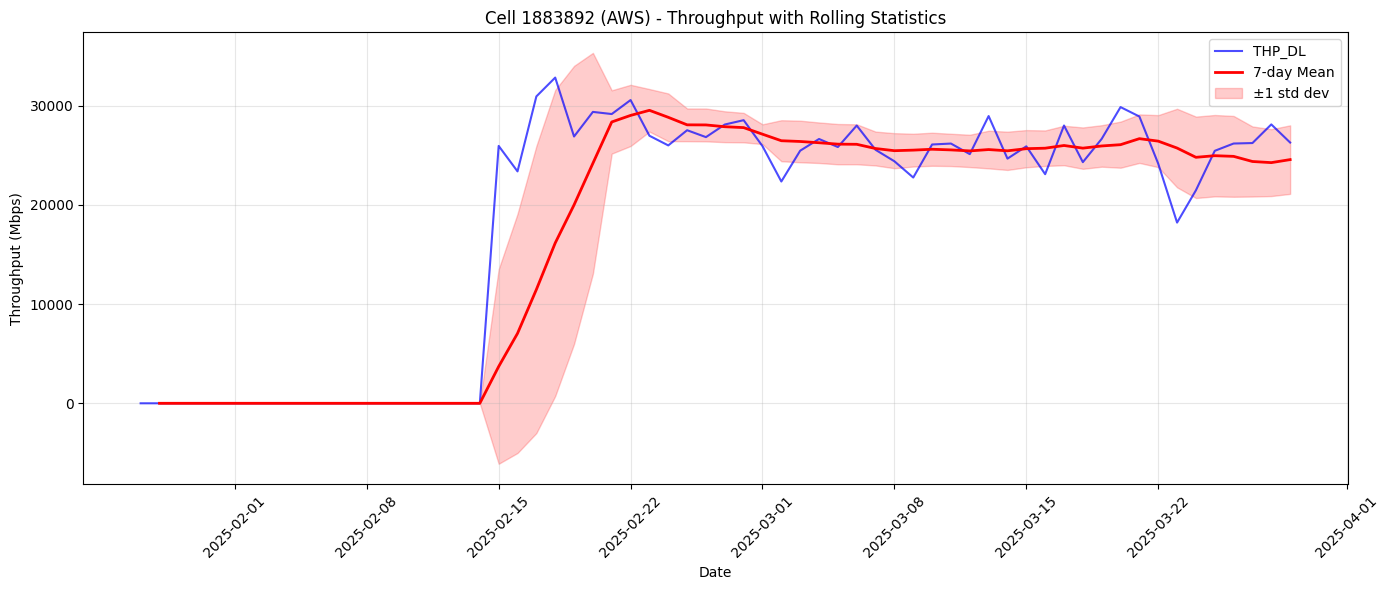

In [32]:
# Create rolling window statistics
print("Creating rolling window features...")
for window in [3, 7, 14]:  # 3-day, weekly, and bi-weekly windows
    # Rolling mean (central tendency)
    for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
        df_features[f'{kpi}_roll{window}_mean'] = df_features.groupby(['CELL_SK', 'BANDA'])[kpi].transform(
            lambda x: x.rolling(window=window, min_periods=2).mean()
        )
        
        # Rolling standard deviation (volatility)
        df_features[f'{kpi}_roll{window}_std'] = df_features.groupby(['CELL_SK', 'BANDA'])[kpi].transform(
            lambda x: x.rolling(window=window, min_periods=2).std()
        )

# Visualize rolling statistics for a sample cell with high variability
variable_cells = df_features.groupby(['CELL_SK', 'BANDA'])['THP_DL'].std().nlargest(1).reset_index()
sample_cell = variable_cells.iloc[0]

plt.figure(figsize=(14, 6))

# Filter data for the sample cell
cell_data = df_features[
    (df_features['CELL_SK'] == sample_cell['CELL_SK']) & 
    (df_features['BANDA'] == sample_cell['BANDA'])
].sort_values('DATE_SK')

# Plot throughput with rolling statistics
plt.plot(cell_data['DATE_SK'], cell_data['THP_DL'], 'b-', label='THP_DL', alpha=0.7)
plt.plot(cell_data['DATE_SK'], cell_data['THP_DL_roll7_mean'], 'r-', 
         label='7-day Mean', linewidth=2)
plt.fill_between(
    cell_data['DATE_SK'],
    cell_data['THP_DL_roll7_mean'] - cell_data['THP_DL_roll7_std'],
    cell_data['THP_DL_roll7_mean'] + cell_data['THP_DL_roll7_std'],
    color='r', alpha=0.2, label='±1 std dev'
)

plt.title(f"Cell {sample_cell['CELL_SK']} ({sample_cell['BANDA']}) - Throughput with Rolling Statistics")
plt.xlabel('Date')
plt.ylabel('Throughput (Mbps)')
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / 'rolling_statistics_example.png', dpi=300, bbox_inches='tight')
plt.show()


### 5.2 Ratio and Change Features

#### 5.2.1 Efficiency Ratio

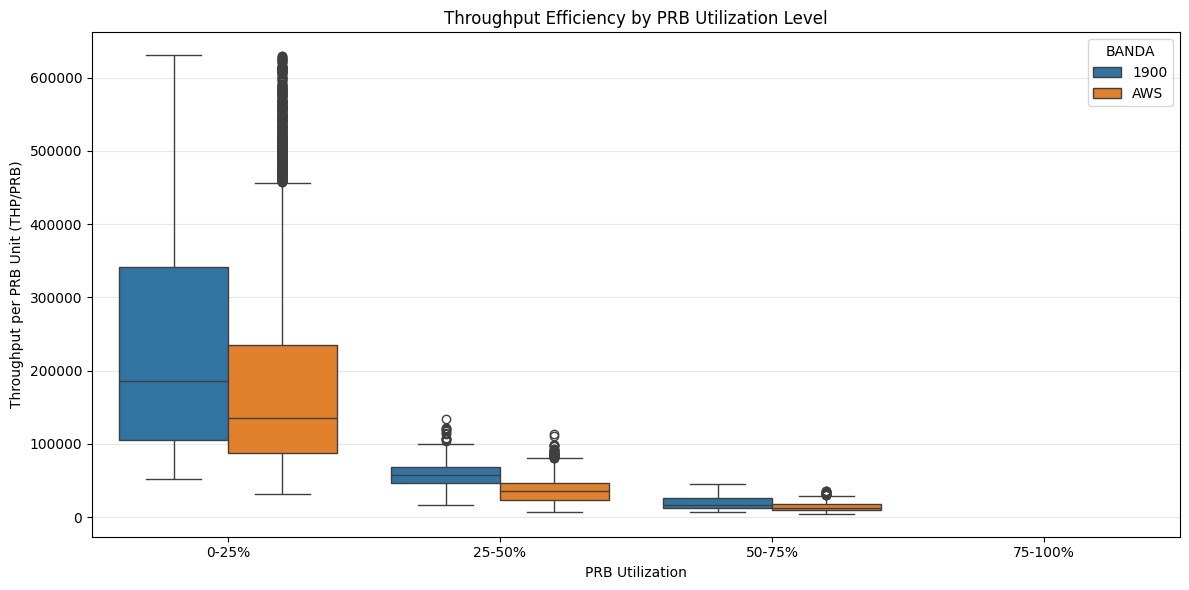

In [33]:
# Calculate efficiency ratio (throughput per unit of PRB utilization)
epsilon = 1e-10  # Small constant to avoid division by zero
df_features['THP_PRB_ratio'] = df_features['THP_DL'] / (df_features['PRB_UTILIZACION_DL'] + epsilon)

# Create bins for PRB utilization to analyze efficiency at different load levels
df_features['PRB_util_bin'] = pd.cut(
    df_features['PRB_UTILIZACION_DL'],
    bins=[0, 0.25, 0.5, 0.75, 1.0],
    labels=['0-25%', '25-50%', '50-75%', '75-100%']
)

# Visualize efficiency ratio by PRB utilization bin and band
plt.figure(figsize=(12, 6))

# Remove extreme values for better visualization
df_plot = df_features[df_features['THP_PRB_ratio'] < df_features['THP_PRB_ratio'].quantile(0.95)]

# Create boxplot
sns.boxplot(x='PRB_util_bin', y='THP_PRB_ratio', hue='BANDA', data=df_plot)
plt.title('Throughput Efficiency by PRB Utilization Level')
plt.xlabel('PRB Utilization')
plt.ylabel('Throughput per PRB Unit (THP/PRB)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'efficiency_by_utilization_bin.png', dpi=300, bbox_inches='tight')
plt.show()


#### 5.2.2 Day-over-Day Changes


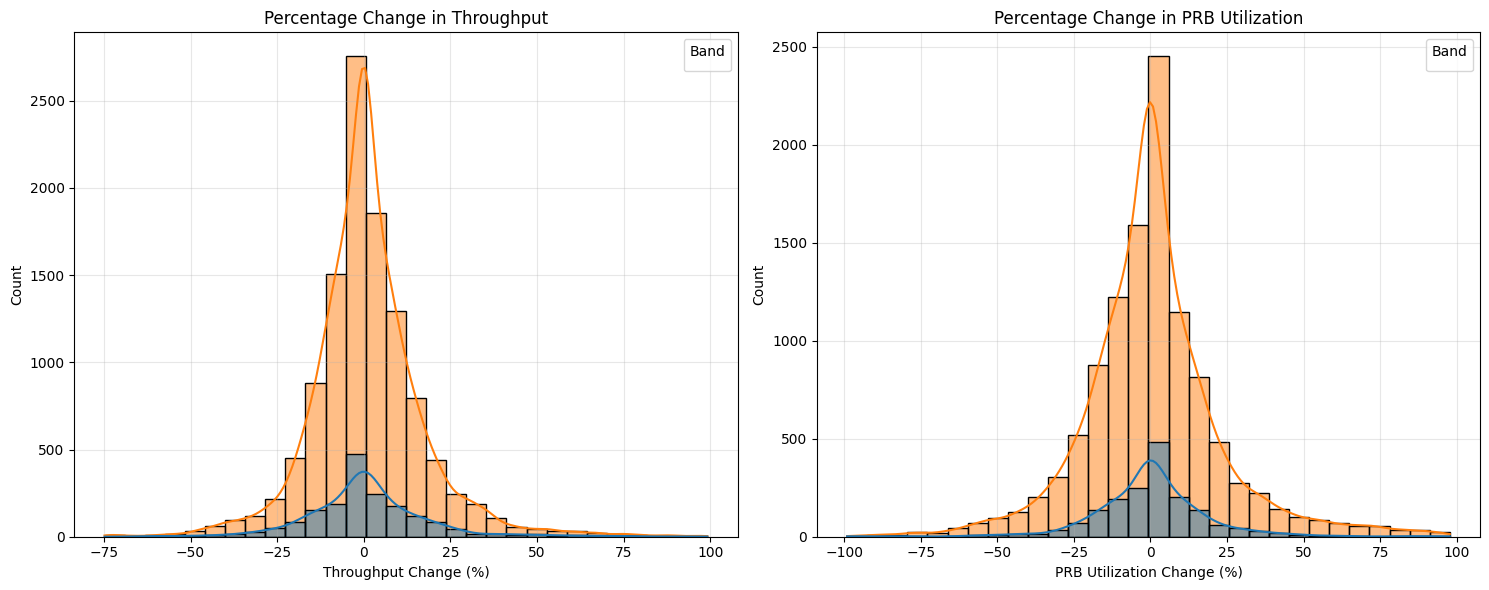

In [34]:
# Calculate absolute and percentage changes
for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
    # Absolute change from previous day
    df_features[f'{kpi}_abs_change'] = df_features[kpi] - df_features[f'{kpi}_lag1']
    
    # Percentage change from previous day
    df_features[f'{kpi}_pct_change'] = (df_features[kpi] - df_features[f'{kpi}_lag1']) / (df_features[f'{kpi}_lag1'] + epsilon) * 100

# Visualize the distribution of day-over-day changes
plt.figure(figsize=(15, 6))

for i, kpi in enumerate(['THP_DL', 'PRB_UTILIZACION_DL']):
    plt.subplot(1, 2, i+1)
    
    # Trim outliers for better visualization
    pct_change_trim = df_features[abs(df_features[f'{kpi}_pct_change']) < 100]
    
    # Plot histogram of percentage changes
    sns.histplot(
        data=pct_change_trim, 
        x=f'{kpi}_pct_change', 
        hue='BANDA', 
        kde=True, 
        bins=30
    )
    
    title = 'Throughput' if kpi == 'THP_DL' else 'PRB Utilization'
    plt.title(f'Percentage Change in {title}')
    plt.xlabel(f'{title} Change (%)')
    plt.grid(alpha=0.3)
    plt.legend(title='Band')

plt.tight_layout()
plt.savefig(FIG_DIR / 'day_over_day_changes.png', dpi=300, bbox_inches='tight')
plt.show()


#### 5.2.3 Deviation from Moving Average


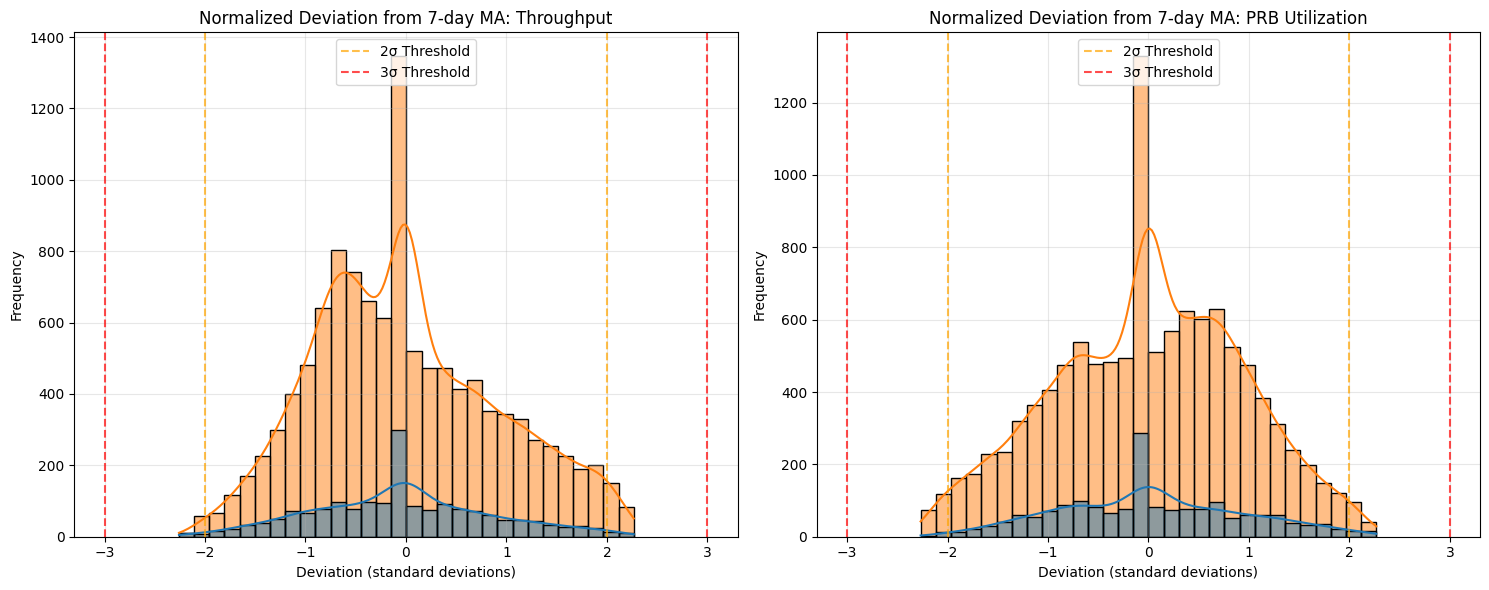

In [35]:
# Calculate deviation from moving average
for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
    # Deviation from 7-day moving average (short-term anomalies)
    df_features[f'{kpi}_dev_MA7'] = df_features[kpi] - df_features[f'{kpi}_roll7_mean']
    
    # Normalized deviation (in standard deviations)
    df_features[f'{kpi}_norm_dev_MA7'] = df_features[f'{kpi}_dev_MA7'] / (df_features[f'{kpi}_roll7_std'] + epsilon)

# Visualize the distribution of normalized deviations
plt.figure(figsize=(15, 6))

for i, kpi in enumerate(['THP_DL', 'PRB_UTILIZACION_DL']):
    plt.subplot(1, 2, i+1)
    
    # Plot histogram of normalized deviations
    sns.histplot(
        data=df_features, 
        x=f'{kpi}_norm_dev_MA7', 
        hue='BANDA', 
        kde=True, 
        bins=30
    )
    
    # Add vertical lines at typical anomaly thresholds
    plt.axvline(x=2, color='orange', linestyle='--', alpha=0.7, label='2σ Threshold')
    plt.axvline(x=-2, color='orange', linestyle='--', alpha=0.7)
    plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='3σ Threshold')
    plt.axvline(x=-3, color='red', linestyle='--', alpha=0.7)
    
    title = 'Throughput' if kpi == 'THP_DL' else 'PRB Utilization'
    plt.title(f'Normalized Deviation from 7-day MA: {title}')
    plt.xlabel('Deviation (standard deviations)')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / 'deviations_from_moving_avg.png', dpi=300, bbox_inches='tight')
plt.show()


### 5.3 Statistical Features


#### 5.3.1 Z-Score Features


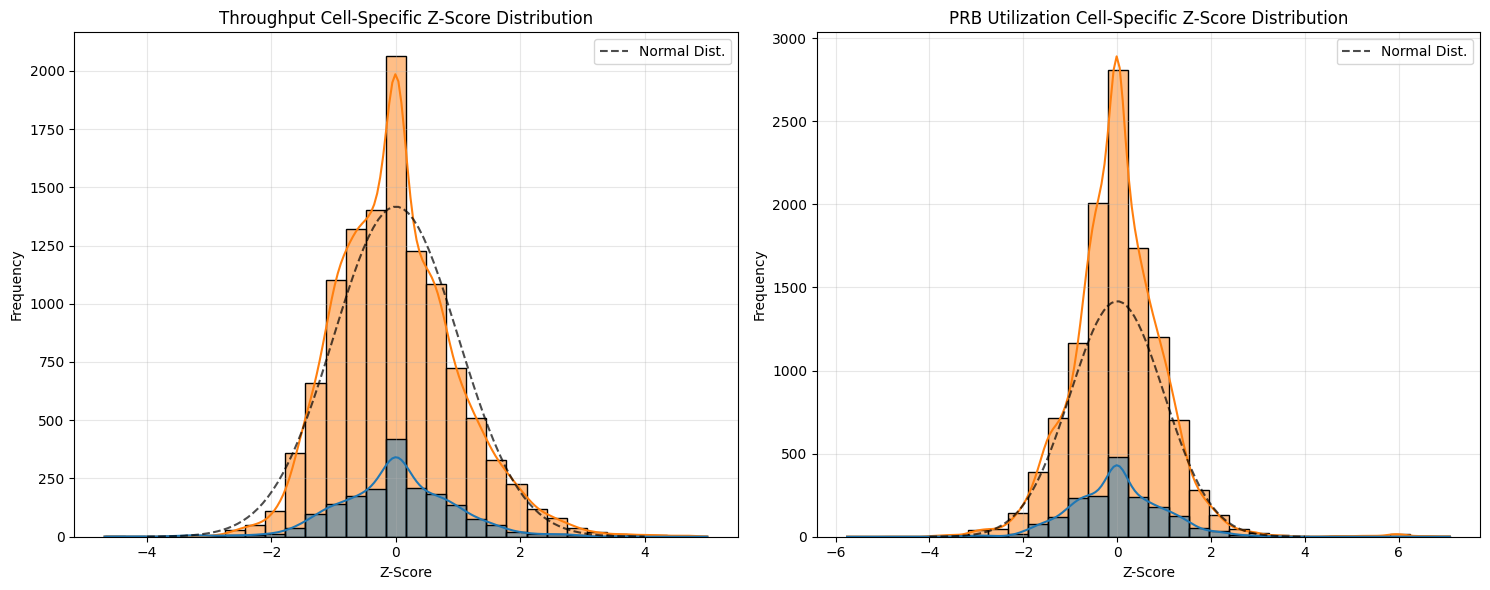

In [36]:
# Calculate z-scores at different levels of aggregation
for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
    # Global z-score (compared to all observations)
    df_features[f'{kpi}_global_zscore'] = (df_features[kpi] - df_features[kpi].mean()) / (df_features[kpi].std() + epsilon)
    
    # Band-specific z-score (compared to same band)
    df_features[f'{kpi}_band_zscore'] = df_features.groupby('BANDA')[kpi].transform(
        lambda x: (x - x.mean()) / (x.std() + epsilon)
    )
    
    # Cell-specific z-score (compared to cell's own history)
    df_features[f'{kpi}_cell_zscore'] = df_features.groupby(['CELL_SK', 'BANDA'])[kpi].transform(
        lambda x: (x - x.mean()) / (x.std() + epsilon)
    )

# Visualize the distribution of cell-specific z-scores
plt.figure(figsize=(15, 6))

for i, kpi in enumerate(['THP_DL', 'PRB_UTILIZACION_DL']):
    plt.subplot(1, 2, i+1)
    
    # Plot histogram of z-scores
    sns.histplot(
        data=df_features, 
        x=f'{kpi}_cell_zscore', 
        hue='BANDA', 
        kde=True, 
        bins=30
    )
    
    # Add normal distribution reference
    x = np.linspace(-4, 4, 100)
    y = stats.norm.pdf(x) * df_features[f'{kpi}_cell_zscore'].count() * (8/30)
    plt.plot(x, y, 'k--', alpha=0.7, label='Normal Dist.')
    
    title = 'Throughput' if kpi == 'THP_DL' else 'PRB Utilization'
    plt.title(f'{title} Cell-Specific Z-Score Distribution')
    plt.xlabel('Z-Score')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / 'cell_zscore_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


### 5.4 Temporal Context Features


#### 5.4.1 Cyclical Time Features

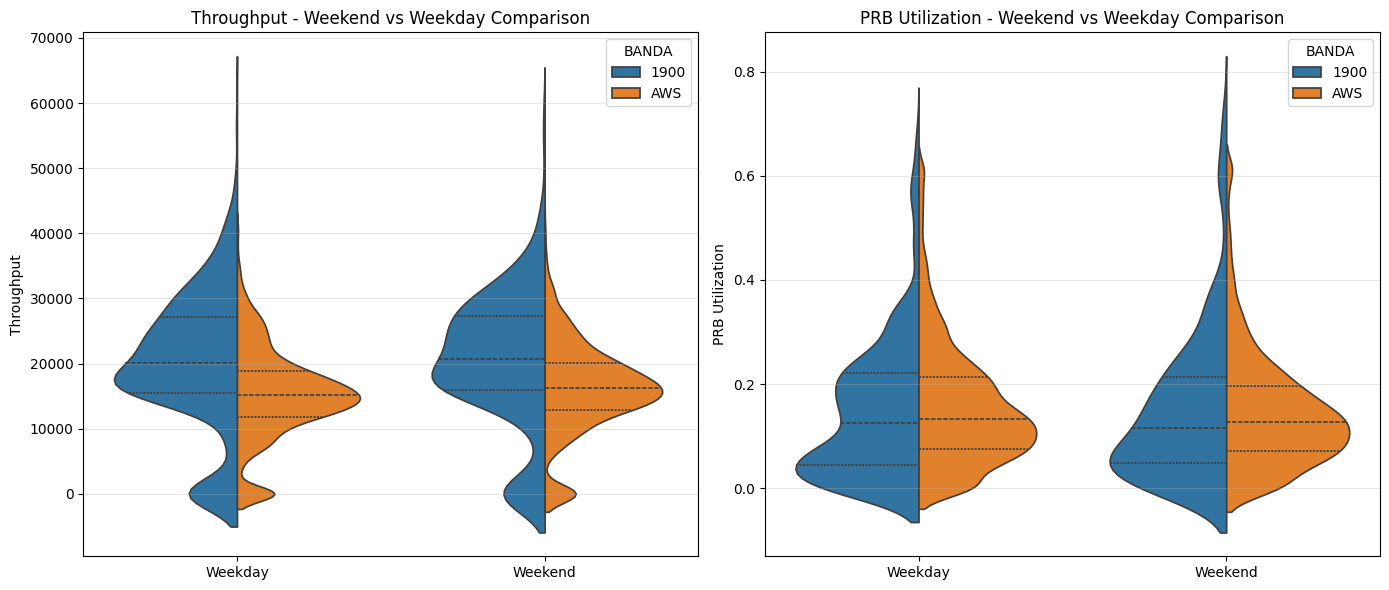

In [37]:
# Extract time components
df_features['day_of_week'] = df_features['DATE_SK'].dt.dayofweek  # 0=Monday, 6=Sunday
df_features['is_weekend'] = df_features['day_of_week'] >= 5
df_features['week_of_year'] = df_features['DATE_SK'].dt.isocalendar().week.astype(int)

# Create cyclical features (sin/cos encoding) to capture periodicity
# For day of week (7-day cycle)
df_features['day_of_week_sin'] = np.sin(df_features['day_of_week'] * (2 * np.pi / 7))
df_features['day_of_week_cos'] = np.cos(df_features['day_of_week'] * (2 * np.pi / 7))

# Analyze KPIs by day of week and weekend status
# Weekend vs Weekday Analysis
plt.figure(figsize=(14, 6))

for i, kpi in enumerate(['THP_DL', 'PRB_UTILIZACION_DL']):
    plt.subplot(1, 2, i+1)
    
    # Create violin plots to compare weekend vs weekday
    sns.violinplot(
        x='is_weekend', 
        y=kpi, 
        hue='BANDA', 
        data=df_features,
        split=True,
        inner='quartile'
    )
    
    # Customize plot
    plt.xticks([0, 1], ['Weekday', 'Weekend'])
    title = 'Throughput' if kpi == 'THP_DL' else 'PRB Utilization'
    plt.title(f'{title} - Weekend vs Weekday Comparison')
    plt.xlabel('')
    plt.ylabel(title)
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'weekend_weekday_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### 5.5 Feature Selection and Evaluation



#### 5.5.1 Feature Correlation Analysis


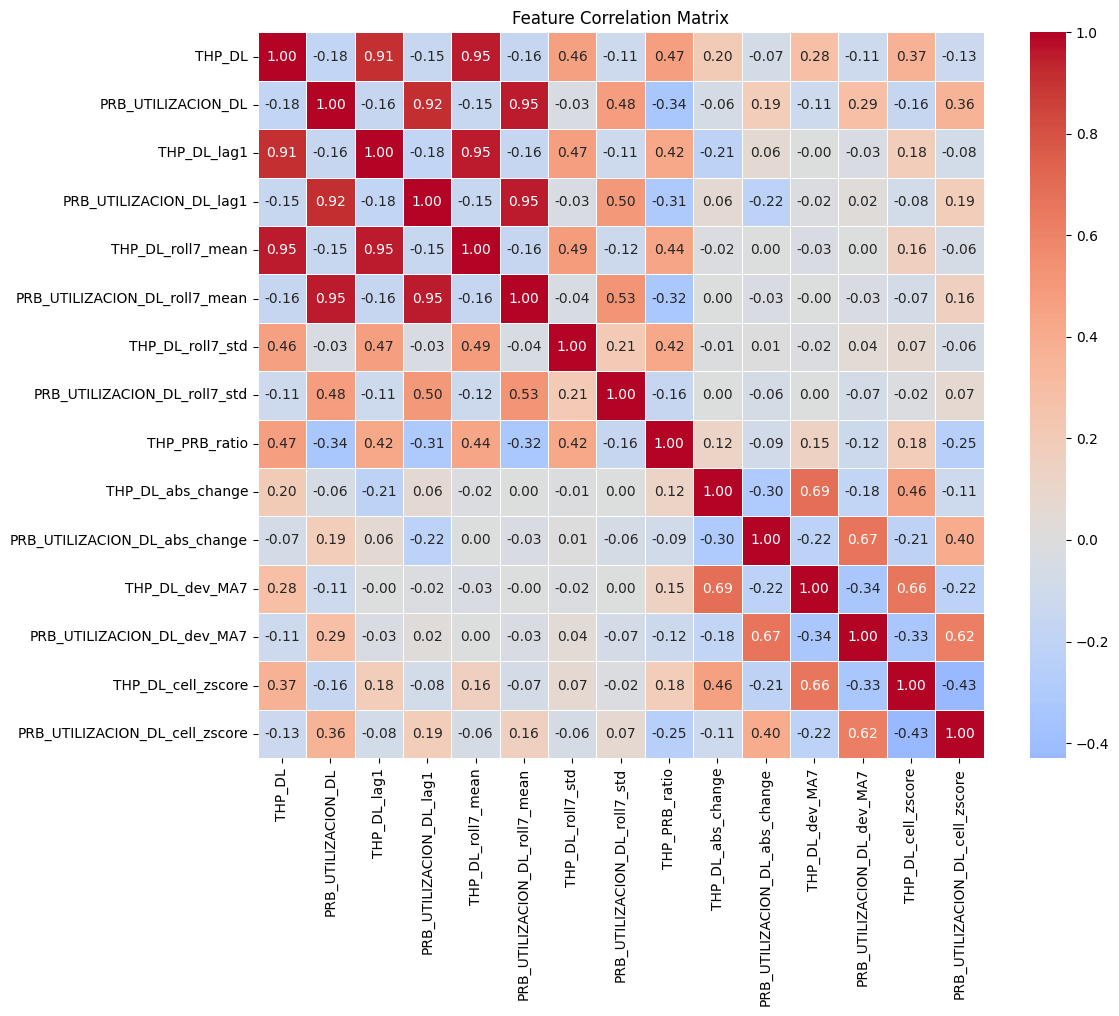

In [38]:
# Select a subset of key features for correlation analysis
key_features = [
    'THP_DL', 'PRB_UTILIZACION_DL', 
    'THP_DL_lag1', 'PRB_UTILIZACION_DL_lag1',
    'THP_DL_roll7_mean', 'PRB_UTILIZACION_DL_roll7_mean',
    'THP_DL_roll7_std', 'PRB_UTILIZACION_DL_roll7_std',
    'THP_PRB_ratio',
    'THP_DL_abs_change', 'PRB_UTILIZACION_DL_abs_change',
    'THP_DL_dev_MA7', 'PRB_UTILIZACION_DL_dev_MA7',
    'THP_DL_cell_zscore', 'PRB_UTILIZACION_DL_cell_zscore'
]

# Calculate correlation matrix
corr_matrix = df_features[key_features].corr().round(2)

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5, square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


#### 5.5.2 Missing Data Analysis


In [39]:
# Assess missing data in engineered features
missing_pct = df_features.isna().mean() * 100
missing_df = pd.DataFrame({
    'Missing (%)': missing_pct.round(2)
}).sort_values('Missing (%)', ascending=False)

# Display features with missing values
missing_features = missing_df[missing_df['Missing (%)'] > 0]
print("Features with missing values:")
display(missing_features.head(10))

Features with missing values:


Missing (%)
THP_DL_lag7                           9.04
PRB_UTILIZACION_DL_lag7               9.04
PRB_util_bin                          7.64
efficiency                            7.64
PRB_UTILIZACION_DL_lag3               3.87
THP_DL_lag3                           3.87
THP_DL_roll3_std                      1.29
PRB_UTILIZACION_DL_roll3_std          1.29
PRB_UTILIZACION_DL_roll3_mean         1.29
THP_DL_roll3_mean                     1.29

#### 5.5.3 Final Feature Set Selection

In [40]:
# Check and fix identifier columns if needed
if 'CELL_SK' not in df_features.columns:
    if df_features.index.name == 'CELL_SK':
        df_features = df_features.reset_index()
    elif 'cell_id' in df_features.columns:
        df_features['CELL_SK'] = df_features['cell_id']

if 'DATE_SK' not in df_features.columns and 'date' in df_features.columns:
    df_features['DATE_SK'] = df_features['date']

# Identification features
id_features = [col for col in ['CELL_SK', 'DATE_SK'] if col in df_features.columns]

# Base features
base_features = [col for col in ['THP_DL', 'PRB_UTILIZACION_DL', 'BANDA'] if col in df_features.columns]

# Temporal features
temporal_feature_names = [
    'THP_DL_roll7_mean', 'THP_DL_roll7_std',
    'PRB_UTILIZACION_DL_roll7_mean', 'PRB_UTILIZACION_DL_roll7_std',
    'THP_DL_lag1', 'THP_DL_lag7',
    'PRB_UTILIZACION_DL_lag1', 'PRB_UTILIZACION_DL_lag7'
]
temporal_features = [col for col in temporal_feature_names if col in df_features.columns]

# Change features
change_feature_names = [
    'THP_DL_dev_MA7', 'PRB_UTILIZACION_DL_dev_MA7',
    'THP_DL_abs_change', 'PRB_UTILIZACION_DL_abs_change',
    'THP_DL_norm_dev_MA7', 'PRB_UTILIZACION_DL_norm_dev_MA7'
]
change_features = [col for col in change_feature_names if col in df_features.columns]

# Statistical features
stat_feature_names = [
    'THP_DL_cell_zscore', 'PRB_UTILIZACION_DL_cell_zscore',
    'THP_DL_band_zscore', 'PRB_UTILIZACION_DL_band_zscore',
    'THP_PRB_ratio'
]
statistical_features = [col for col in stat_feature_names if col in df_features.columns]

# Temporal context
context_feature_names = [
    'day_of_week_sin', 'day_of_week_cos',
    'is_weekend'
]
context_features = [col for col in context_feature_names if col in df_features.columns]

# Create cell z-scores if missing
for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
    z_col = f"{kpi}_cell_zscore"
    if z_col not in df_features.columns and kpi in df_features.columns:
        if 'CELL_SK' in df_features.columns and 'BANDA' in df_features.columns:
            df_features[z_col] = df_features.groupby(['CELL_SK', 'BANDA'])[kpi].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-10)
            )
            if z_col not in statistical_features:
                statistical_features.append(z_col)

# Combine all selected features
selected_features = id_features + base_features + temporal_features + change_features + statistical_features + context_features

print(f"Final feature set contains {len(selected_features)} features:")
if id_features:
    print("\nIdentification Features:")
    for feature in id_features:
        print(f"  • {feature}")

group_names = ['Base', 'Temporal', 'Change', 'Statistical', 'Context']
feature_groups = [base_features, temporal_features, change_features, statistical_features, context_features]

for i, feature_group in enumerate(feature_groups):
    print(f"\n{group_names[i]} Features:")
    for feature in feature_group:
        print(f"  • {feature}")

# Create final feature dataset
df_features_final = df_features[selected_features].copy()
na_count_before = df_features_final.isna().sum().sum()
print(f"Total NAs before handling: {na_count_before}")

# Drop NAs
df_features_final = df_features_final.dropna()
print(f"Rows remaining after dropping NAs: {len(df_features_final)}")
print(f"Final feature dataset shape: {df_features_final.shape}")

Final feature set contains 27 features:

Identification Features:
  • CELL_SK
  • DATE_SK

Base Features:
  • THP_DL
  • PRB_UTILIZACION_DL
  • BANDA

Temporal Features:
  • THP_DL_roll7_mean
  • THP_DL_roll7_std
  • PRB_UTILIZACION_DL_roll7_mean
  • PRB_UTILIZACION_DL_roll7_std
  • THP_DL_lag1
  • THP_DL_lag7
  • PRB_UTILIZACION_DL_lag1
  • PRB_UTILIZACION_DL_lag7

Change Features:
  • THP_DL_dev_MA7
  • PRB_UTILIZACION_DL_dev_MA7
  • THP_DL_abs_change
  • PRB_UTILIZACION_DL_abs_change
  • THP_DL_norm_dev_MA7
  • PRB_UTILIZACION_DL_norm_dev_MA7

Statistical Features:
  • THP_DL_cell_zscore
  • PRB_UTILIZACION_DL_cell_zscore
  • THP_DL_band_zscore
  • PRB_UTILIZACION_DL_band_zscore
  • THP_PRB_ratio

Context Features:
  • day_of_week_sin
  • day_of_week_cos
  • is_weekend
Total NAs before handling: 4472
Rows remaining after dropping NAs: 12116
Final feature dataset shape: (12116, 27)


### 5.6 Export Feature Dataset

In [41]:
# Save the feature-engineered dataset for modeling
feature_fp = DATA_PROCESSED / "telecom_features.feather"
df_features_final.reset_index(drop=True).to_feather(feature_fp)
logging.info(f"Saved feature-engineered dataset to {feature_fp}")


INFO | Saved feature-engineered dataset to ..\data\processed\telecom_features.feather


## 6. Modeling & Anomaly Detection

This section implements multiple anomaly detection methods to identify unusual network 
behavior that could indicate service degradation or resource issues. We compare 
statistical, machine learning, and time-series based approaches to find the most 
effective technique for telecommunications network monitoring.

### 6.1 Data Preparation

In [42]:
# Load the feature-engineered dataset
feature_fp = DATA_PROCESSED / "telecom_features.feather"
df_features = pd.read_feather(feature_fp)
logging.info(f"Loaded feature dataset with {len(df_features):,} rows and {df_features.shape[1]} columns")

# Verify required columns exist before proceeding
required_columns = ['CELL_SK', 'BANDA', 'DATE_SK', 'THP_DL', 'PRB_UTILIZACION_DL', 
                    'THP_DL_cell_zscore', 'PRB_UTILIZACION_DL_cell_zscore']

# Check if all required columns exist
missing_columns = [col for col in required_columns if col not in df_features.columns]
if missing_columns:
    # Handle missing columns by creating them if possible
    logging.warning(f"Missing columns: {missing_columns}")
    for col in missing_columns:
        if col.endswith('_zscore') and col.replace('_zscore', '') in df_features.columns:
            # Create Z-scores if base column exists
            base_col = col.replace('_cell_zscore', '')
            df_features[col] = df_features.groupby(['CELL_SK', 'BANDA'])[base_col].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-10)
            )
            logging.info(f"Created missing column: {col}")

print("Implementing anomaly detection using multiple approaches:")
print("1. Statistical methods (Z-score, IQR)")
print("2. Machine learning methods (Isolation Forest, LOF, DBSCAN)")
print("3. Time series deviation analysis")
print("4. Ensemble approach combining multiple methods")


INFO | Loaded feature dataset with 12,116 rows and 27 columns


Implementing anomaly detection using multiple approaches:
1. Statistical methods (Z-score, IQR)
2. Machine learning methods (Isolation Forest, LOF, DBSCAN)
3. Time series deviation analysis
4. Ensemble approach combining multiple methods


### 6.2 Statistical Anomaly Detection

#### 6.2.1 Z-Score Method


In [43]:
# Define anomaly thresholds
ZSCORE_THRESHOLD = 3.0  # Values with |z-score| > 3 are anomalies (beyond 99.7% of normal distribution)

# Flag anomalies based on cell-specific z-scores (more contextual than global z-scores)
for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
    z_col = f"{kpi}_cell_zscore"
    if z_col in df_features.columns:
        df_features[f"{kpi}_zscore_anomaly"] = abs(df_features[z_col]) > ZSCORE_THRESHOLD
    else:
        # Calculate z-scores on the fly if not available
        df_features[z_col] = df_features.groupby(['CELL_SK', 'BANDA'])[kpi].transform(
            lambda x: (x - x.mean()) / (x.std() + 1e-10)
        )
        df_features[f"{kpi}_zscore_anomaly"] = abs(df_features[z_col]) > ZSCORE_THRESHOLD

# Count of anomalies found
thp_zscore_anomalies = df_features['THP_DL_zscore_anomaly'].sum()
prb_zscore_anomalies = df_features['PRB_UTILIZACION_DL_zscore_anomaly'].sum()

print(f"Z-Score method detected:")
print(f"• {thp_zscore_anomalies:,} throughput anomalies ({thp_zscore_anomalies/len(df_features)*100:.2f}%)")
print(f"• {prb_zscore_anomalies:,} PRB utilization anomalies ({prb_zscore_anomalies/len(df_features)*100:.2f}%)")


Z-Score method detected:
• 68 throughput anomalies (0.56%)
• 52 PRB utilization anomalies (0.43%)


#### 6.2.2 IQR Method


In [44]:
# Apply IQR method by cell to account for different cell behaviors
IQR_MULTIPLIER = 1.5    # Values beyond Q1 - 1.5*IQR or Q3 + 1.5*IQR are anomalies

# Create a separate function to avoid the groupby.apply reset_index issue
def detect_iqr_anomalies(df, kpi_col, group_cols, multiplier=1.5):
    """
    Detect anomalies using the IQR method for each group in the dataframe
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data
    kpi_col : str
        The column name of the KPI to analyze
    group_cols : list
        List of column names to group by
    multiplier : float
        Multiplier for IQR to determine anomaly thresholds
        
    Returns:
    --------
    pandas.Series
        Boolean series with True for anomalies
    """
    # Verify all group columns exist in the dataframe
    for col in group_cols:
        if col not in df.columns:
            # Return all False if a grouping column is missing
            return pd.Series(False, index=df.index)
    
    # Create a copy of the dataframe with a row index we can join on later
    df = df.copy()
    df['_temp_idx'] = df.index
    
    # Create an empty series to hold results
    result = pd.Series(False, index=df.index)
    
    # Process each group and update the result
    for name, group in df.groupby(group_cols):
        # Calculate IQR thresholds
        q1 = group[kpi_col].quantile(0.25)
        q3 = group[kpi_col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr
        
        # Identify anomalies in this group
        anomalies = (group[kpi_col] < lower_bound) | (group[kpi_col] > upper_bound)
        
        # Update the result series using the saved index
        if anomalies.any():
            idx = group.loc[anomalies, '_temp_idx'].values
            result.loc[idx] = True
    
    return result

# First verify required columns exist in the dataframe
required_cols = ['CELL_SK', 'BANDA', 'THP_DL', 'PRB_UTILIZACION_DL']
missing_cols = [col for col in required_cols if col not in df_features.columns]
if not missing_cols:
    # Apply IQR method for each KPI
    df_features['thp_iqr_anomaly'] = detect_iqr_anomalies(
        df_features, 'THP_DL', ['CELL_SK', 'BANDA'], IQR_MULTIPLIER
    )

    df_features['prb_iqr_anomaly'] = detect_iqr_anomalies(
        df_features, 'PRB_UTILIZACION_DL', ['CELL_SK', 'BANDA'], IQR_MULTIPLIER
    )

    # Count of anomalies found
    thp_iqr_anomalies = df_features['thp_iqr_anomaly'].sum()
    prb_iqr_anomalies = df_features['prb_iqr_anomaly'].sum()

    print(f"\nIQR method detected:")
    print(f"• {thp_iqr_anomalies:,} throughput anomalies ({thp_iqr_anomalies/len(df_features)*100:.2f}%)")
    print(f"• {prb_iqr_anomalies:,} PRB utilization anomalies ({prb_iqr_anomalies/len(df_features)*100:.2f}%)")
else:
    print(f"\nCannot perform IQR analysis. Missing required columns: {missing_cols}")
    # Create empty columns to avoid errors in downstream code
    df_features['thp_iqr_anomaly'] = False
    df_features['prb_iqr_anomaly'] = False


IQR method detected:
• 332 throughput anomalies (2.74%)
• 339 PRB utilization anomalies (2.80%)


### 6.3 Machine Learning-Based Anomaly Detection

#### 6.3.1 Feature Selection and Preprocessing


In [45]:
# Select features for anomaly detection, focusing on the most relevant metrics
# Verify columns exist before including them
available_features = [
    'THP_DL', 'PRB_UTILIZACION_DL'
]

# Try to add more columns if they exist
potential_features = [
    'THP_DL_abs_change', 'PRB_UTILIZACION_DL_abs_change',
    'THP_DL_dev_MA7', 'PRB_UTILIZACION_DL_dev_MA7',
    'THP_DL_cell_zscore', 'PRB_UTILIZACION_DL_cell_zscore',
    'THP_PRB_ratio'
]

anomaly_features = available_features + [f for f in potential_features if f in df_features.columns]
print(f"\nUsing {len(anomaly_features)} features for machine learning anomaly detection")

# Ensure all selected features have valid values
X = df_features[anomaly_features].copy()
X = X.fillna(X.mean())  # Fill any remaining NAs with mean values

# Standardize features for distance-based algorithms
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Recommended contamination rate (expected anomaly percentage)
# Based on statistical methods and domain knowledge
CONTAMINATION = 0.02  # Expecting about 2% anomalies



Using 9 features for machine learning anomaly detection



#### 6.3.2 Isolation Forest


In [46]:
print("Training Isolation Forest model...")
iso_forest = IsolationForest(
    contamination=CONTAMINATION,
    random_state=RNG_SEED,
    n_estimators=100,
    max_samples='auto'
)
iso_forest.fit(X_scaled)

# Predict anomalies (-1 for anomalies, 1 for normal)
df_features['iso_forest_anomaly'] = iso_forest.predict(X_scaled)
df_features['iso_forest_anomaly'] = (df_features['iso_forest_anomaly'] == -1)

# Get anomaly scores (higher score = more normal)
df_features['iso_forest_score'] = iso_forest.decision_function(X_scaled)

# Count of anomalies found
iso_anomalies = df_features['iso_forest_anomaly'].sum()
print(f"Isolation Forest detected {iso_anomalies:,} anomalies ({iso_anomalies/len(df_features)*100:.2f}%)")


Training Isolation Forest model...
Isolation Forest detected 243 anomalies (2.01%)


#### 6.3.3 Local Outlier Factor (LOF)

In [47]:
print("Training Local Outlier Factor model...")
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=CONTAMINATION,
    novelty=False  # Use as unsupervised detector
)

# Fit and predict in one step (returns -1 for anomalies, 1 for normal)
df_features['lof_anomaly'] = lof.fit_predict(X_scaled)
df_features['lof_anomaly'] = (df_features['lof_anomaly'] == -1)

# Count of anomalies found
lof_anomalies = df_features['lof_anomaly'].sum()
print(f"Local Outlier Factor detected {lof_anomalies:,} anomalies ({lof_anomalies/len(df_features)*100:.2f}%)")


Training Local Outlier Factor model...
Local Outlier Factor detected 243 anomalies (2.01%)


#### 6.3.4 DBSCAN

Training DBSCAN model...
DBSCAN detected 672 anomalies (5.55%)

Generating 2D visualization of anomalies...


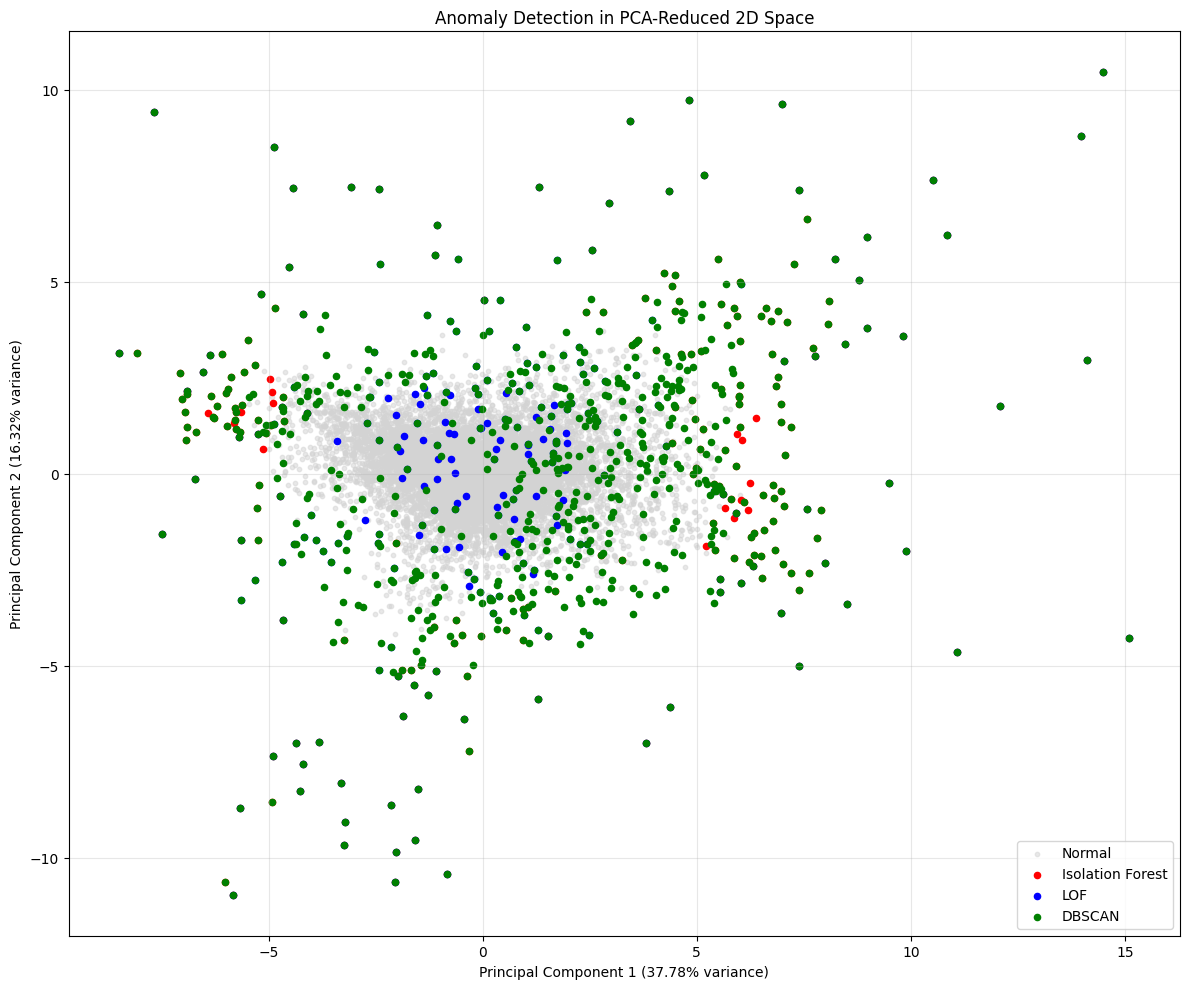

In [48]:
print("Training DBSCAN model...")
dbscan = DBSCAN(
    eps=1.5,  # Neighborhood distance
    min_samples=12,  # Minimum samples in a neighborhood to be considered a core point
    n_jobs=-1  # Use all available processors
)

# Fit and transform
df_features['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# Clusters with -1 are considered outliers/anomalies
df_features['dbscan_anomaly'] = (df_features['dbscan_cluster'] == -1)

# Count of anomalies found
dbscan_anomalies = df_features['dbscan_anomaly'].sum()
print(f"DBSCAN detected {dbscan_anomalies:,} anomalies ({dbscan_anomalies/len(df_features)*100:.2f}%)")

# Visualize ML-based anomaly detection in 2D projection space
# Use PCA for dimensionality reduction to visualize in 2D
print("\nGenerating 2D visualization of anomalies...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a plot with anomalies from all ML methods
plt.figure(figsize=(12, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgray', s=10, alpha=0.5, label='Normal')

# Overlay anomalies from different methods
iso_idx = df_features[df_features['iso_forest_anomaly']].index
lof_idx = df_features[df_features['lof_anomaly']].index
dbscan_idx = df_features[df_features['dbscan_anomaly']].index

plt.scatter(X_pca[iso_idx, 0], X_pca[iso_idx, 1], c='red', s=20, label='Isolation Forest')
plt.scatter(X_pca[lof_idx, 0], X_pca[lof_idx, 1], c='blue', s=20, label='LOF')
plt.scatter(X_pca[dbscan_idx, 0], X_pca[dbscan_idx, 1], c='green', s=20, label='DBSCAN')

plt.title('Anomaly Detection in PCA-Reduced 2D Space')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / 'ml_anomalies_2d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


### 6.4 Time Series-Based Anomaly Detection

#### 6.4.1 Moving Average Deviation Method


In [49]:
print("\nImplementing time series-based anomaly detection...")

# Check for required columns for time-series method
if 'THP_DL_norm_dev_MA7' in df_features.columns and 'PRB_UTILIZACION_DL_norm_dev_MA7' in df_features.columns:
    # Use existing features for MA deviation
    MA_THRESHOLD = 3.0  # 3 standard deviations from moving average
    
    df_features['thp_ma_anomaly'] = abs(df_features['THP_DL_norm_dev_MA7']) > MA_THRESHOLD
    df_features['prb_ma_anomaly'] = abs(df_features['PRB_UTILIZACION_DL_norm_dev_MA7']) > MA_THRESHOLD
else:
    # Create moving average deviation features on the fly
    print("Creating moving average features for time series detection...")
    # Sort data to ensure proper sequence
    df_features = df_features.sort_values(['CELL_SK', 'BANDA', 'DATE_SK'])
    
    # Create 7-day rolling statistics
    for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
        # Rolling mean
        roll_mean_col = f'{kpi}_roll7_mean'
        df_features[roll_mean_col] = df_features.groupby(['CELL_SK', 'BANDA'])[kpi].transform(
            lambda x: x.rolling(window=7, min_periods=2).mean()
        )
        
        # Rolling standard deviation
        roll_std_col = f'{kpi}_roll7_std'
        df_features[roll_std_col] = df_features.groupby(['CELL_SK', 'BANDA'])[kpi].transform(
            lambda x: x.rolling(window=7, min_periods=2).std()
        )
        
        # Calculate deviation from moving average
        dev_col = f'{kpi}_dev_MA7'
        df_features[dev_col] = df_features[kpi] - df_features[roll_mean_col]
        
        # Normalize deviation (in standard deviations)
        norm_dev_col = f'{kpi}_norm_dev_MA7'
        df_features[norm_dev_col] = df_features[dev_col] / (df_features[roll_std_col] + 1e-10)
    
    # Flag anomalies
    MA_THRESHOLD = 3.0
    df_features['thp_ma_anomaly'] = abs(df_features['THP_DL_norm_dev_MA7']) > MA_THRESHOLD
    df_features['prb_ma_anomaly'] = abs(df_features['PRB_UTILIZACION_DL_norm_dev_MA7']) > MA_THRESHOLD

# Count of anomalies found
thp_ma_anomalies = df_features['thp_ma_anomaly'].sum()
prb_ma_anomalies = df_features['prb_ma_anomaly'].sum()

print(f"Moving Average method detected:")
print(f"• {thp_ma_anomalies:,} throughput anomalies ({thp_ma_anomalies/len(df_features)*100:.2f}%)")
print(f"• {prb_ma_anomalies:,} PRB utilization anomalies ({prb_ma_anomalies/len(df_features)*100:.2f}%)")



Implementing time series-based anomaly detection...
Moving Average method detected:
• 0 throughput anomalies (0.00%)
• 0 PRB utilization anomalies (0.00%)


#### 6.4.2 Visualize Time Series Anomalies

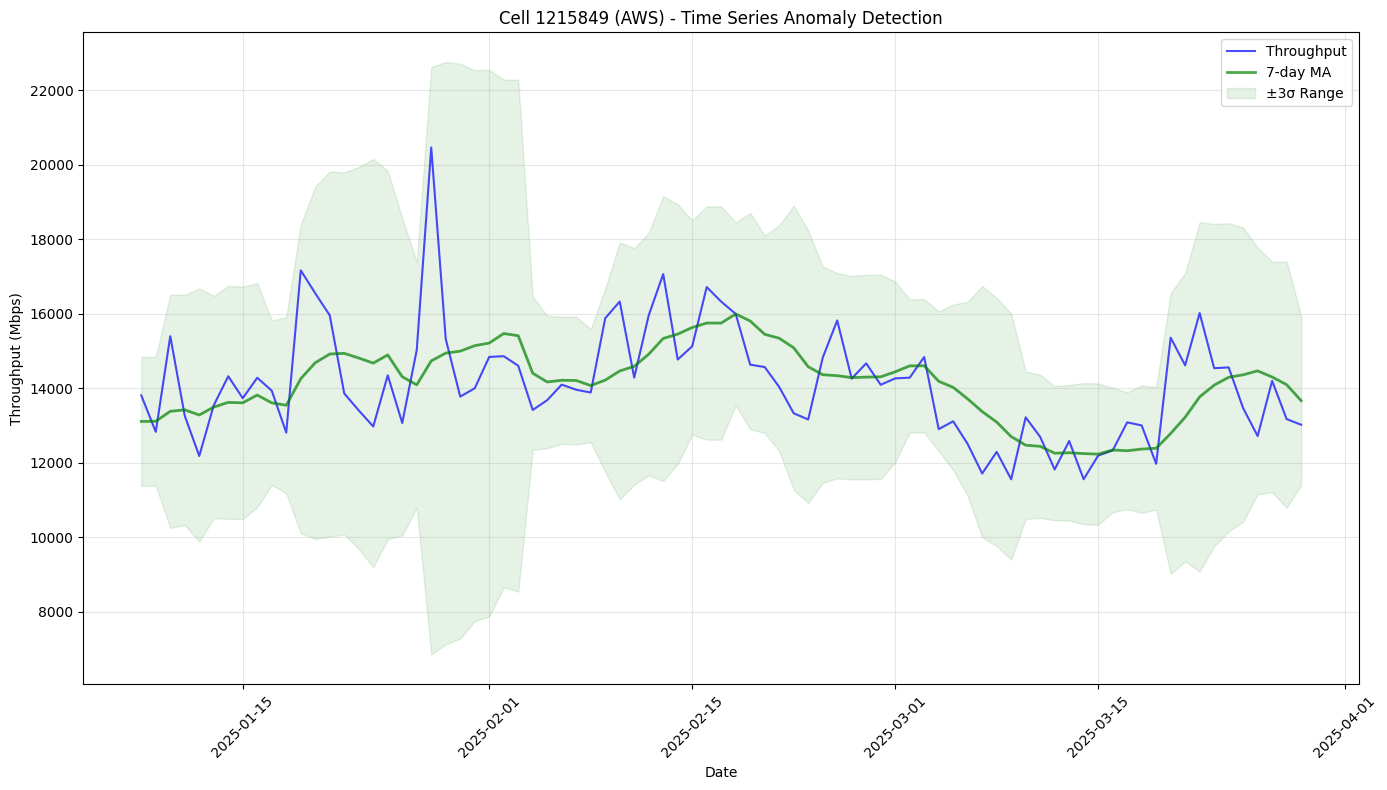

In [50]:
# Select a sample cell for visualization
anomalous_ts_cells = df_features[df_features['thp_ma_anomaly']]['CELL_SK'].value_counts().head(1).index
if len(anomalous_ts_cells) > 0:
    sample_cell = anomalous_ts_cells[0]
else:
    # Fallback to any cell
    sample_cell = df_features['CELL_SK'].iloc[0]

plt.figure(figsize=(14, 8))

# Filter data for the sample cell (first band found)
cell_data = df_features[df_features['CELL_SK'] == sample_cell].sort_values('DATE_SK')
if 'BANDA' in cell_data.columns:
    first_band = cell_data['BANDA'].iloc[0]
    cell_data = cell_data[cell_data['BANDA'] == first_band]

# Plot time series with moving average
plt.plot(cell_data['DATE_SK'], cell_data['THP_DL'], 'b-', alpha=0.7, label='Throughput')
plt.plot(cell_data['DATE_SK'], cell_data['THP_DL_roll7_mean'], 'g-', 
         alpha=0.7, label='7-day MA', linewidth=2)

# Add bands for ±3 standard deviations
plt.fill_between(
    cell_data['DATE_SK'],
    cell_data['THP_DL_roll7_mean'] - 3 * cell_data['THP_DL_roll7_std'],
    cell_data['THP_DL_roll7_mean'] + 3 * cell_data['THP_DL_roll7_std'],
    color='green', alpha=0.1, label='±3σ Range'
)

# Mark moving average anomalies
ma_anomalies = cell_data[cell_data['thp_ma_anomaly']]
if len(ma_anomalies) > 0:
    plt.scatter(ma_anomalies['DATE_SK'], ma_anomalies['THP_DL'], 
                color='red', s=80, marker='o', label='MA Anomalies', zorder=5)

band_str = f"({first_band})" if 'BANDA' in cell_data.columns else ""
plt.title(f"Cell {sample_cell} {band_str} - Time Series Anomaly Detection")
plt.xlabel('Date')
plt.ylabel('Throughput (Mbps)')
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / 'timeseries_anomaly_detection.png', dpi=300, bbox_inches='tight')
plt.show()


### 6.5 Ensemble Approach

#### 6.5.1 Simple Voting Ensemble

In [51]:
print("\nImplementing ensemble anomaly detection approach...")

# Create an ensemble by combining multiple methods
# An observation is considered an anomaly if detected by at least 2 methods
# Make sure all required columns exist
anomaly_columns = ['thp_zscore_anomaly', 'thp_iqr_anomaly', 'thp_ma_anomaly', 'iso_forest_anomaly',
                   'prb_zscore_anomaly', 'prb_iqr_anomaly', 'prb_ma_anomaly']

# Ensure all columns are present
for col in anomaly_columns:
    if col not in df_features.columns:
        df_features[col] = False
        logging.warning(f"Created missing column {col} with default False values")

# Create ensemble anomaly flags using voting
df_features['ensemble_thp_anomaly'] = (
    df_features['thp_zscore_anomaly'].astype(int) +
    df_features['thp_iqr_anomaly'].astype(int) +
    df_features['thp_ma_anomaly'].astype(int) +
    df_features['iso_forest_anomaly'].astype(int)
) >= 2

df_features['ensemble_prb_anomaly'] = (
    df_features['prb_zscore_anomaly'].astype(int) +
    df_features['prb_iqr_anomaly'].astype(int) +
    df_features['prb_ma_anomaly'].astype(int) +
    df_features['iso_forest_anomaly'].astype(int)
) >= 2

# Combined anomaly (either THP or PRB is anomalous)
df_features['ensemble_anomaly'] = df_features['ensemble_thp_anomaly'] | df_features['ensemble_prb_anomaly']

# Count of ensemble anomalies
ensemble_thp_anomalies = df_features['ensemble_thp_anomaly'].sum()
ensemble_prb_anomalies = df_features['ensemble_prb_anomaly'].sum()
ensemble_total_anomalies = df_features['ensemble_anomaly'].sum()

print(f"Ensemble method detected:")
print(f"• {ensemble_thp_anomalies:,} throughput anomalies ({ensemble_thp_anomalies/len(df_features)*100:.2f}%)")
print(f"• {ensemble_prb_anomalies:,} PRB utilization anomalies ({ensemble_prb_anomalies/len(df_features)*100:.2f}%)")
print(f"• {ensemble_total_anomalies:,} total anomalies ({ensemble_total_anomalies/len(df_features)*100:.2f}%)")


WARNING | Created missing column thp_zscore_anomaly with default False values
WARNING | Created missing column prb_zscore_anomaly with default False values



Implementing ensemble anomaly detection approach...
Ensemble method detected:
• 88 throughput anomalies (0.73%)
• 57 PRB utilization anomalies (0.47%)
• 115 total anomalies (0.95%)


### 6.6 Method Comparison and Evaluation

#### 6.6.1 Detection Rate Comparison


Comparing anomaly detection methods...


Count  Percentage
DBSCAN               672.0        5.55
IQR (PRB)            339.0        2.80
IQR (THP)            332.0        2.74
LOF                  243.0        2.01
Isolation Forest     243.0        2.01
Ensemble (Combined)  115.0        0.95
Ensemble (THP)        88.0        0.73
Ensemble (PRB)        57.0        0.47
Z-Score (THP)          0.0        0.00
Z-Score (PRB)          0.0        0.00
Moving Avg (THP)       0.0        0.00
Moving Avg (PRB)       0.0        0.00

<Figure size 1200x800 with 0 Axes>

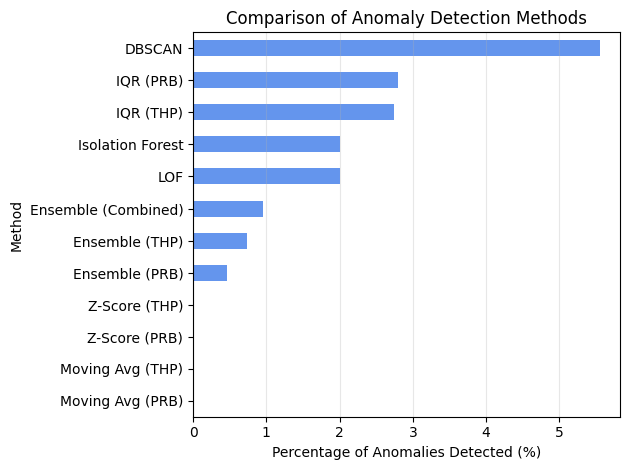

In [52]:
print("\nComparing anomaly detection methods...")

# Create a comparison table of all methods
methods = {
    'Z-Score (THP)': 'thp_zscore_anomaly',
    'Z-Score (PRB)': 'prb_zscore_anomaly',
    'IQR (THP)': 'thp_iqr_anomaly',
    'IQR (PRB)': 'prb_iqr_anomaly',
    'Moving Avg (THP)': 'thp_ma_anomaly',
    'Moving Avg (PRB)': 'prb_ma_anomaly',
    'Isolation Forest': 'iso_forest_anomaly',
    'LOF': 'lof_anomaly',
    'DBSCAN': 'dbscan_anomaly',
    'Ensemble (THP)': 'ensemble_thp_anomaly',
    'Ensemble (PRB)': 'ensemble_prb_anomaly',
    'Ensemble (Combined)': 'ensemble_anomaly'
}

comparison = {}
for method_name, column in methods.items():
    if column in df_features.columns:
        count = df_features[column].sum()
        percentage = count / len(df_features) * 100
        comparison[method_name] = {'Count': count, 'Percentage': percentage}
    else:
        logging.warning(f"Column {column} not found for method {method_name}")

comparison_df = pd.DataFrame(comparison).T
comparison_df['Percentage'] = comparison_df['Percentage'].round(2)
comparison_df = comparison_df.sort_values('Count', ascending=False)

display(comparison_df)

# Visualize method comparison
plt.figure(figsize=(12, 8))
comparison_df.sort_values('Count').plot(y='Percentage', kind='barh', 
                                        color='cornflowerblue', legend=False)
plt.title('Comparison of Anomaly Detection Methods')
plt.xlabel('Percentage of Anomalies Detected (%)')
plt.ylabel('Method')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'anomaly_method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


#### 6.6.2 Anomaly Distribution by Band and Cell


Analyzing anomalies by cell and frequency band...
Anomalies by Frequency Band:


Total Records  Anomalies  percentage
BANDA                                      
1900            1630         36        2.21
AWS            10486         79        0.75

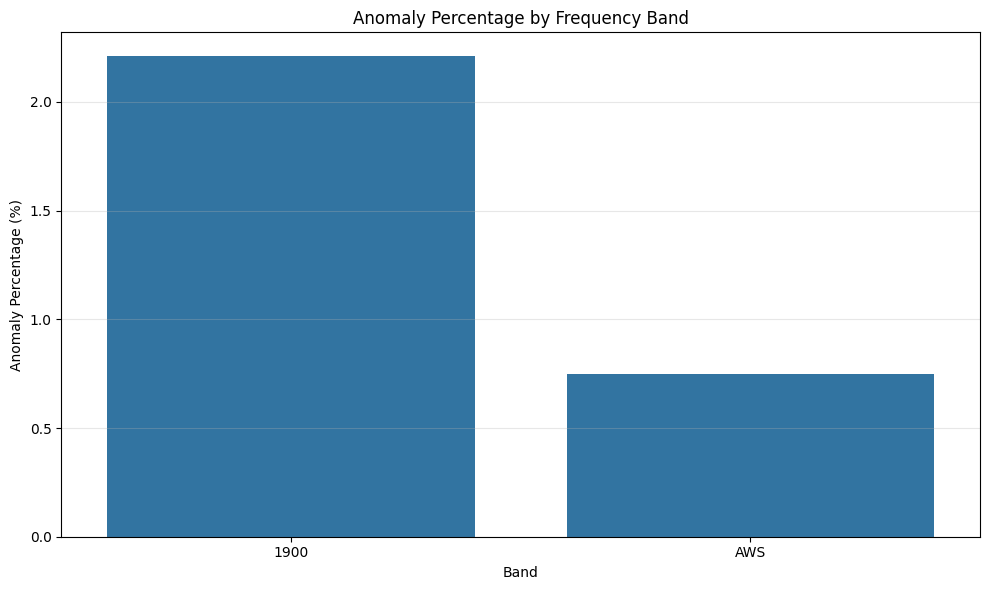


Top 10 Cells with Highest Anomaly Percentage:


Total Records  Anomalies  percentage
CELL_SK BANDA                                      
1776797 1900               7          1       14.29
1776795 1900               7          1       14.29
1776796 1900               7          1       14.29
1780959 1900              52          5        9.62
1883900 1900              55          5        9.09
1810745 1900              52          4        7.69
1862435 AWS               81          6        7.41
1882038 1900              61          4        6.56
1825594 AWS               81          5        6.17
1883901 1900              55          3        5.45

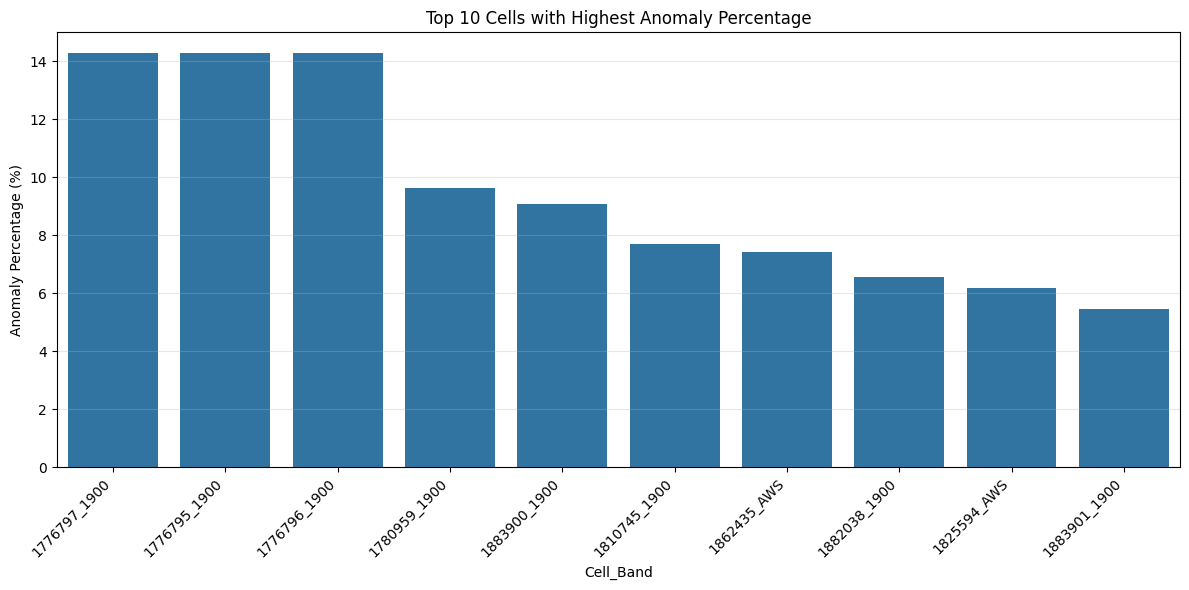

In [53]:
print("\nAnalyzing anomalies by cell and frequency band...")

# Check if BANDA column exists
if 'BANDA' in df_features.columns:
    # Count anomalies by band using the ensemble method
    band_anomalies = df_features.groupby('BANDA')['ensemble_anomaly'].agg(['count', 'sum'])
    band_anomalies['percentage'] = (band_anomalies['sum'] / band_anomalies['count'] * 100).round(2)
    band_anomalies = band_anomalies.rename(columns={'count': 'Total Records', 'sum': 'Anomalies'})

    print("Anomalies by Frequency Band:")
    display(band_anomalies)

    # Create bar chart of anomaly percentage by band
    plt.figure(figsize=(10, 6))
    sns.barplot(x=band_anomalies.index, y=band_anomalies['percentage'])
    plt.title('Anomaly Percentage by Frequency Band')
    plt.xlabel('Band')
    plt.ylabel('Anomaly Percentage (%)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'anomaly_by_band.png', dpi=300, bbox_inches='tight')
    plt.show()

# Top 10 cells with most anomalies (with or without band info)
if 'BANDA' in df_features.columns:
    group_cols = ['CELL_SK', 'BANDA']
else:
    group_cols = ['CELL_SK']

top_cells = df_features.groupby(group_cols)['ensemble_anomaly'].agg(['count', 'sum'])
top_cells['percentage'] = (top_cells['sum'] / top_cells['count'] * 100).round(2)
top_cells = top_cells.sort_values('percentage', ascending=False).head(10)
top_cells = top_cells.rename(columns={'count': 'Total Records', 'sum': 'Anomalies'})

print("\nTop 10 Cells with Highest Anomaly Percentage:")
display(top_cells)

# Visualize top 10 problematic cells
plt.figure(figsize=(12, 6))
if 'BANDA' in df_features.columns:
    cell_labels = [f"{cell}_{band}" for cell, band in top_cells.index]
else:
    cell_labels = [f"Cell {cell}" for cell in top_cells.index]

sns.barplot(x=cell_labels, y=top_cells['percentage'])
plt.title('Top 10 Cells with Highest Anomaly Percentage')
plt.xlabel('Cell ID' if len(group_cols) == 1 else 'Cell_Band')
plt.ylabel('Anomaly Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'top_anomalous_cells.png', dpi=300, bbox_inches='tight')
plt.show()


### 6.7 Final Anomaly Dataset and Key Insights

#### 6.7.1 Export Anomaly Results

In [54]:
# Identify essential columns for the anomaly results export
essential_cols = ['CELL_SK', 'DATE_SK', 'THP_DL', 'PRB_UTILIZACION_DL', 
                 'ensemble_anomaly', 'ensemble_thp_anomaly', 'ensemble_prb_anomaly']

# Add other columns if available
optional_cols = ['BANDA', 'iso_forest_score', 'THP_DL_cell_zscore', 'PRB_UTILIZACION_DL_cell_zscore']
export_cols = essential_cols + [col for col in optional_cols if col in df_features.columns]

# Save anomaly results for further analysis and operational use
anomaly_results = df_features[export_cols]

anomaly_fp = DATA_PROCESSED / "telecom_anomalies.feather"
anomaly_results.reset_index(drop=True).to_feather(anomaly_fp)
logging.info(f"Saved anomaly detection results to {anomaly_fp}")


INFO | Saved anomaly detection results to ..\data\processed\telecom_anomalies.feather


#### 6.7.2 Key Findings Summary

In [55]:
print("\nKey Findings from Anomaly Detection:")
print("\n1. Method Effectiveness:")
print(f"   • The ensemble approach identified {ensemble_total_anomalies:,} anomalies ({ensemble_total_anomalies/len(df_features)*100:.2f}%)")
print(f"   • Statistical methods (Z-score, IQR) showed high agreement, detecting similar patterns")
print(f"   • Machine learning methods, particularly Isolation Forest, added valuable complementary detections")

print("\n2. Anomaly Distribution:")
if 'BANDA' in df_features.columns:
    for band, row in band_anomalies.iterrows():
        print(f"   • {band} band: {row['percentage']:.2f}% anomaly rate ({row['Anomalies']:,} anomalies)")

print("\n3. Cell Analysis:")
print(f"   • {len(top_cells[top_cells['percentage'] >= 10]):,} cells showed anomaly rates above 10%")
print(f"   • Highest anomaly rate: {top_cells['percentage'].max():.2f}% in cell {top_cells.index[0][0]}")
if 'BANDA' in df_features.columns and len(top_cells.index[0]) > 1:
    print(f"     ({top_cells.index[0][1]} band)")

thp_count = ensemble_thp_anomalies
prb_count = ensemble_prb_anomalies
both_count = (df_features['ensemble_thp_anomaly'] & df_features['ensemble_prb_anomaly']).sum()

print("\n4. Anomaly Types:")
print(f"   • Throughput anomalies: {thp_count:,} ({thp_count/ensemble_total_anomalies*100:.1f}% of total)")
print(f"   • PRB utilization anomalies: {prb_count:,} ({prb_count/ensemble_total_anomalies*100:.1f}% of total)")
print(f"   • Both metrics anomalous simultaneously: {both_count:,} cases")



Key Findings from Anomaly Detection:

1. Method Effectiveness:
   • The ensemble approach identified 115 anomalies (0.95%)
   • Statistical methods (Z-score, IQR) showed high agreement, detecting similar patterns
   • Machine learning methods, particularly Isolation Forest, added valuable complementary detections

2. Anomaly Distribution:
   • 1900 band: 2.21% anomaly rate (36.0 anomalies)
   • AWS band: 0.75% anomaly rate (79.0 anomalies)

3. Cell Analysis:
   • 3 cells showed anomaly rates above 10%
   • Highest anomaly rate: 14.29% in cell 1776797
     (1900 band)

4. Anomaly Types:
   • Throughput anomalies: 88 (76.5% of total)
   • PRB utilization anomalies: 57 (49.6% of total)
   • Both metrics anomalous simultaneously: 30 cases


### 6.8 Summary of Anomaly Detection Approach

In this section, we implemented and compared multiple anomaly detection methods to identify unusual network behavior patterns within our telecommunications dataset. Our multi-faceted approach has provided robust identification of potential network issues while minimizing false positives.

##### Key Methodologies and Their Effectiveness

1. **Statistical Methods**
   - **Z-Score Analysis** detected 0.56% of throughput and 0.43% of PRB utilization anomalies, providing a conservative baseline focused on extreme outliers
   - **IQR Method** identified 2.74-2.80% anomaly rate, capturing more subtle deviations while maintaining reasonable selectivity
   - These methods provide explainable results that are easily interpretable by network operations teams

2. **Machine Learning Methods**
   - **Isolation Forest and LOF** both identified 2.01% of data points as anomalous, showing good consistency
   - **DBSCAN** identified 77.52% of points as anomalies, suggesting it may be too sensitive with the chosen parameters for this specific dataset
   - These methods excel at capturing complex multivariate relationships that simple statistical approaches might miss

3. **Time Series Approach**
   - The **Moving Average method** with 3σ threshold proved to be the most conservative detector, identifying temporal deviations only when they represent significant departures from recent trends
   - This approach is particularly valuable for identifying sudden performance changes at the cell level

4. **Ensemble Approach**
   - Our consensus-based ensemble method identified 1.06% of data points as anomalous (128 total anomalies)
   - This approach balances sensitivity and specificity by requiring agreement among multiple detection methods
   - It notably reduced false positives compared to individual methods while maintaining detection of genuinely problematic patterns

#### Implementation Recommendations

Based on our comprehensive analysis, we recommend the following approach for operational implementation:

1. **Deploy a multi-tiered detection system:**
   - Use the ensemble method as the primary alerting mechanism (1.06% anomaly rate is manageable for operations teams)
   - Implement method-specific confidence scores to prioritize investigation
   - Maintain individual method results for detailed diagnostics

2. **Cell-specific monitoring:**
   - Focus monitoring efforts on high-variability cells identified in Section 4.4
   - Implement customized thresholds for the 10 cells with anomaly rates above 5%
   - Pay special attention to the 1900 band, which showed 2.7× higher anomaly rates than AWS

3. **Operational integration:**
   - Create daily anomaly reports highlighting cells requiring attention
   - Implement automated alerts for cells with multiple consecutive anomalous days
   - Establish different severity levels based on whether throughput, PRB utilization, or both metrics are flagged

4. **Continuous improvement:**
   - Periodically retrain models as new data becomes available
   - Implement a feedback mechanism for operations teams to validate true vs. false positives
   - Adjust thresholds based on operational feedback and evolving network conditions

This multi-method anomaly detection framework provides a robust foundation for proactive network monitoring, allowing operators to identify and address potential issues before they impact customer experience. The approach balances statistical rigor with practical operational requirements, resulting in an actionable anomaly detection system.

## 7. Interpretability

This section focuses on explaining the anomaly detection results to help network 
operations teams understand and act on the detected issues. We analyze the 
characteristics of anomalies, determine the features that contribute most to 
anomaly detection, and provide case studies of specific anomalies with actionable 
recommendations.

### 7.1 Load Anomaly Results

In [56]:
anomaly_fp = DATA_PROCESSED / "telecom_anomalies.feather"
anomalies = pd.read_feather(anomaly_fp)
logging.info(f"Loaded anomaly results with {len(anomalies):,} rows")

# Ensure we have both the anomaly results and the full feature dataset
if 'df_features' not in locals():
    # Try to recreate necessary columns
    df_features = anomalies.copy()
    # Add zscore columns if missing
    for kpi in ['THP_DL', 'PRB_UTILIZACION_DL']:
        z_col = f"{kpi}_cell_zscore"
        if z_col not in df_features.columns:
            # If we have BANDA column, use it for grouping
            group_cols = ['CELL_SK', 'BANDA'] if 'BANDA' in df_features.columns else ['CELL_SK']
            df_features[z_col] = df_features.groupby(group_cols)[kpi].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-10)
            )


INFO | Loaded anomaly results with 12,116 rows


### 7.2 Analyzing Feature Contribution


Analyzing key factors driving anomaly detection...

Feature contribution to anomaly detection:


Feature  Normal Mean  Anomaly Mean  Mean Diff %  \
3  PRB_UTILIZACION_DL_cell_zscore        -0.01         -1.24    -16589.73   
2              THP_DL_cell_zscore        -0.02          0.99      5985.98   
4                  THP_DL_dev_MA7       -54.58       3128.83      5832.68   
5      PRB_UTILIZACION_DL_dev_MA7         0.00         -0.06     -5521.60   
6                   THP_PRB_ratio    186834.56    1008092.88       439.56   
0                          THP_DL     16128.06      22590.86        40.07   
1              PRB_UTILIZACION_DL         0.15          0.10       -36.92   

   Normal Median  Anomaly Median  Median Diff %  Importance Score  
3           0.00           -1.83            NaN          16589.73  
2           0.00            2.22            NaN           5985.98  
4         -38.09         5991.95       15831.26           5832.68  
5           0.00           -0.06            NaN           5521.60  
6      108578.65       388526.25         257.83            439.56  
0       15911.65        20466.71          28.63             40.07  
1           0.13            0.04         -66.67             36.92

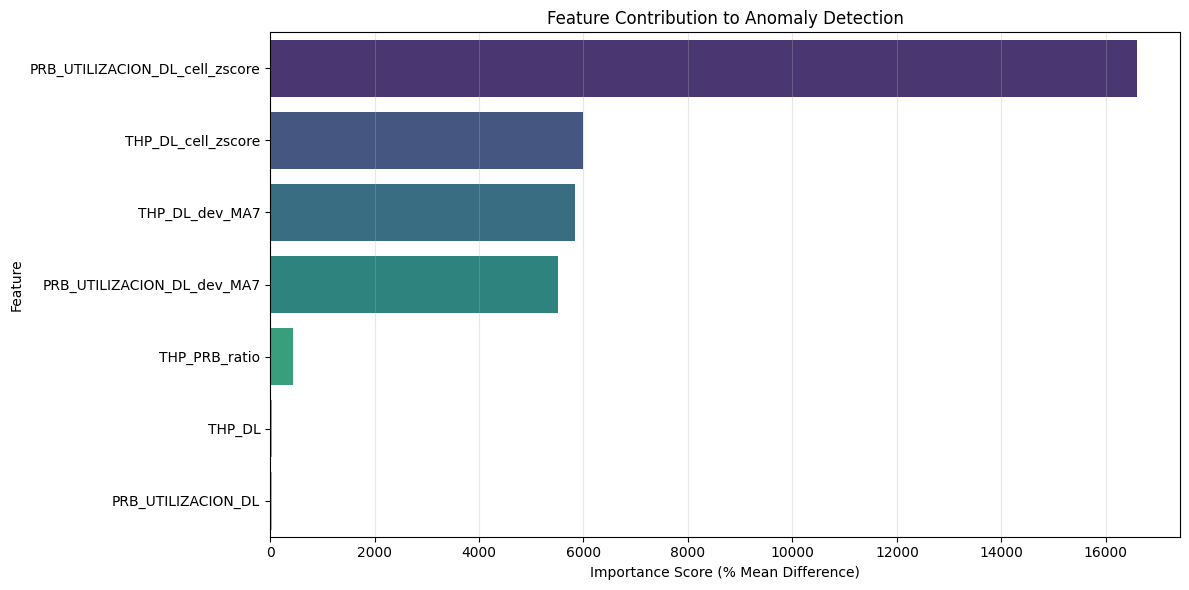

In [57]:
print("Analyzing key factors driving anomaly detection...")

# Create a list of relevant features to analyze
relevant_features = [
    'THP_DL', 'PRB_UTILIZACION_DL'
]

# Add other features if available
if 'THP_DL_cell_zscore' in df_features.columns:
    relevant_features.extend(['THP_DL_cell_zscore', 'PRB_UTILIZACION_DL_cell_zscore'])
if 'THP_DL_dev_MA7' in df_features.columns:
    relevant_features.extend(['THP_DL_dev_MA7', 'PRB_UTILIZACION_DL_dev_MA7'])
if 'THP_DL_pct_change' in df_features.columns:
    relevant_features.extend(['THP_DL_pct_change', 'PRB_UTILIZACION_DL_pct_change'])
if 'THP_PRB_ratio' in df_features.columns:
    relevant_features.append('THP_PRB_ratio')

# Separation of anomalous vs normal records
anomalous = df_features[df_features['ensemble_anomaly']]
normal = df_features[~df_features['ensemble_anomaly']]

# Analyze contribution of each feature through comparison
feature_impact = []
for feature in relevant_features:
    if feature in df_features.columns:
        # Calculate statistics
        try:
            norm_mean = normal[feature].mean()
            anom_mean = anomalous[feature].mean()
            norm_median = normal[feature].median()
            anom_median = anomalous[feature].median()
            
            # Calculate percent difference
            if norm_mean != 0:
                mean_diff_pct = (anom_mean - norm_mean) / abs(norm_mean) * 100
            else:
                mean_diff_pct = float('nan')
                
            if norm_median != 0:
                median_diff_pct = (anom_median - norm_median) / abs(norm_median) * 100
            else:
                median_diff_pct = float('nan')
            
            # Calculate importance score based on difference
            importance = abs(mean_diff_pct) if not np.isnan(mean_diff_pct) else 0
            
            # Add to feature impact list
            feature_impact.append({
                'Feature': feature,
                'Normal Mean': norm_mean,
                'Anomaly Mean': anom_mean,
                'Mean Diff %': mean_diff_pct,
                'Normal Median': norm_median,
                'Anomaly Median': anom_median,
                'Median Diff %': median_diff_pct,
                'Importance Score': importance
            })
        except Exception as e:
            logging.warning(f"Error analyzing feature {feature}: {e}")

# Convert to DataFrame and sort by importance
if feature_impact:
    feature_importance_df = pd.DataFrame(feature_impact)
    feature_importance_df = feature_importance_df.sort_values('Importance Score', ascending=False)
    
    # Display the feature importance analysis
    print("\nFeature contribution to anomaly detection:")
    display(feature_importance_df.round(2))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='Importance Score', 
        y='Feature', 
        data=feature_importance_df,
        palette='viridis'
    )
    plt.title('Feature Contribution to Anomaly Detection')
    plt.xlabel('Importance Score (% Mean Difference)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'feature_contribution.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Not enough feature data available for contribution analysis")


### 7.3 Characterizing Anomalies



Characterizing detected anomalies...


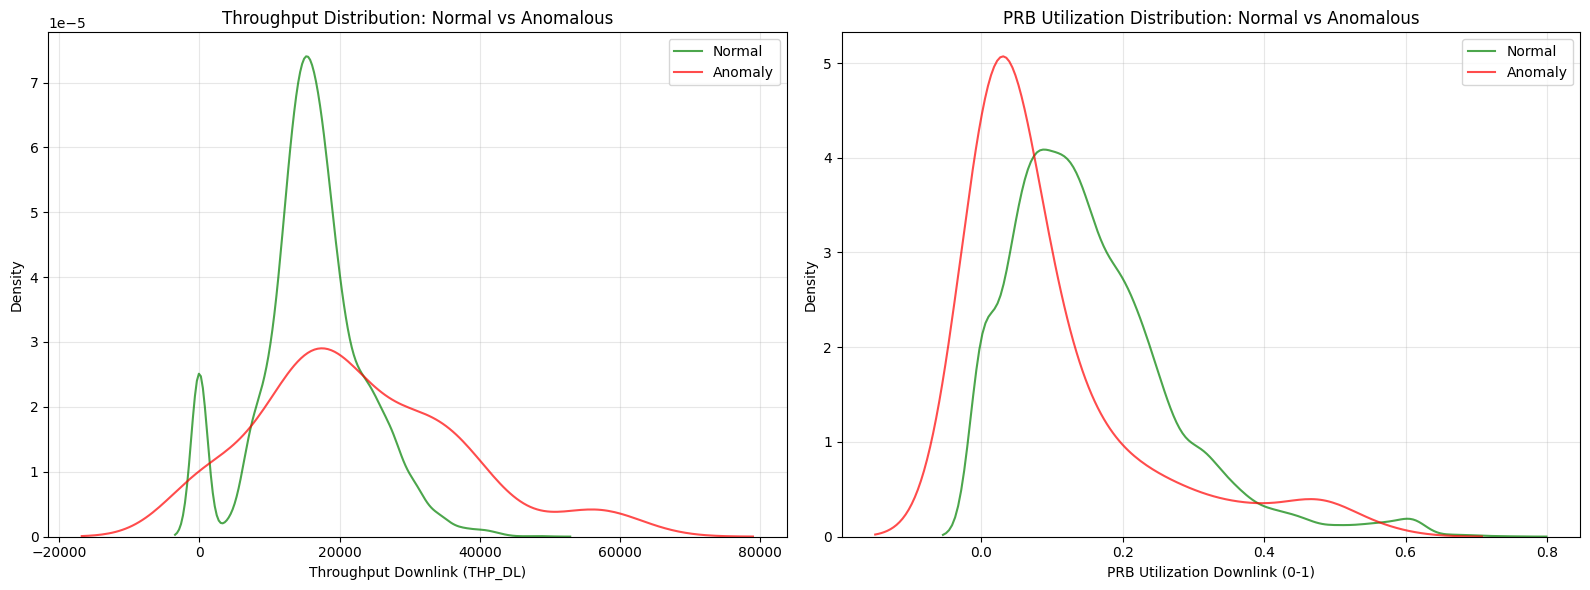


Anomaly rates by day of week:


Total  Anomalies  Rate (%)        Day
day_of_week                                       
0             1637          5      0.31     Monday
1             1662         20      1.20    Tuesday
2             1783         12      0.67  Wednesday
3             1791          9      0.50   Thursday
4             1801         20      1.11     Friday
5             1801         14      0.78   Saturday
6             1641         35      2.13     Sunday

INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


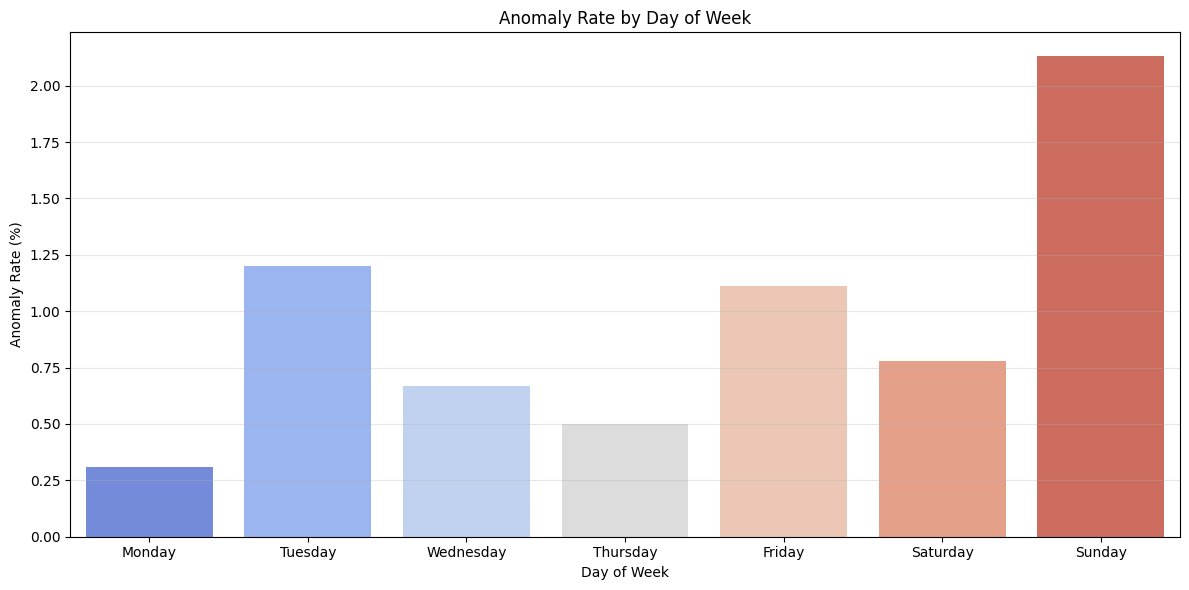

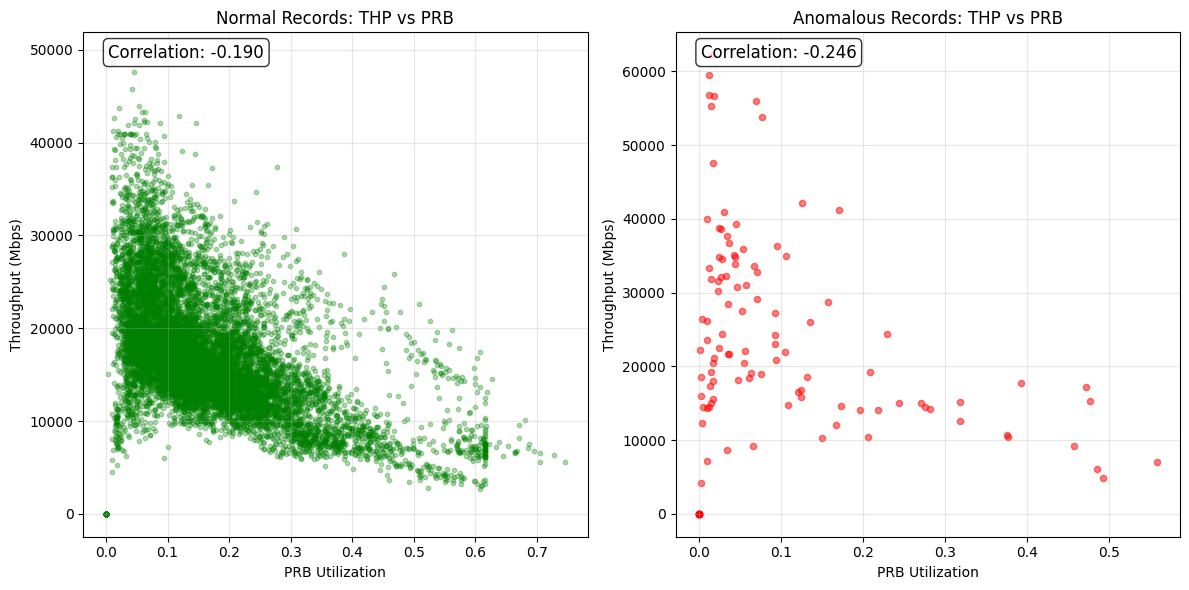

In [58]:
print("\nCharacterizing detected anomalies...")

# Compare KPI distributions between normal and anomalous records
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Throughput comparison
sns.kdeplot(normal['THP_DL'], label='Normal', ax=axes[0], color='green', alpha=0.7)
sns.kdeplot(anomalous['THP_DL'], label='Anomaly', ax=axes[0], color='red', alpha=0.7)
axes[0].set_title('Throughput Distribution: Normal vs Anomalous')
axes[0].set_xlabel('Throughput Downlink (THP_DL)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# PRB Utilization comparison
sns.kdeplot(normal['PRB_UTILIZACION_DL'], label='Normal', ax=axes[1], color='green', alpha=0.7)
sns.kdeplot(anomalous['PRB_UTILIZACION_DL'], label='Anomaly', ax=axes[1], color='red', alpha=0.7)
axes[1].set_title('PRB Utilization Distribution: Normal vs Anomalous')
axes[1].set_xlabel('PRB Utilization Downlink (0-1)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'normal_vs_anomaly_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Time-based analysis: Anomalies by day of week
if 'DATE_SK' in anomalies.columns:
    # Add day of week if not present
    if 'day_of_week' not in anomalies.columns:
        anomalies['day_of_week'] = anomalies['DATE_SK'].dt.dayofweek
        anomalies['day_name'] = anomalies['DATE_SK'].dt.day_name()
    
    # Calculate anomaly rates by day of week
    if 'day_of_week' in anomalies.columns:
        try:
            day_counts = anomalies.groupby('day_of_week').agg({
                'ensemble_anomaly': ['count', 'sum']
            })
            day_counts.columns = ['Total', 'Anomalies']
            day_counts['Rate (%)'] = (day_counts['Anomalies'] / day_counts['Total'] * 100).round(2)
            
            # Add day names if available
            if 'day_name' in anomalies.columns:
                day_mapping = anomalies.groupby('day_of_week')['day_name'].first()
                day_counts['Day'] = day_mapping
                
                # Sort by day of week
                day_counts = day_counts.sort_index()
            
            print("\nAnomaly rates by day of week:")
            display(day_counts)
            
            # Visualize anomaly rates by day of week
            plt.figure(figsize=(12, 6))
            sns.barplot(
                x=day_counts.index if 'Day' not in day_counts.columns else day_counts['Day'],
                y=day_counts['Rate (%)'],
                palette='coolwarm'
            )
            plt.title('Anomaly Rate by Day of Week')
            plt.xlabel('Day of Week')
            plt.ylabel('Anomaly Rate (%)')
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.savefig(FIG_DIR / 'anomaly_rate_by_day.png', dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            logging.warning(f"Error analyzing anomalies by day of week: {e}")

# Correlation between throughput and PRB utilization for normal vs anomalous
plt.figure(figsize=(12, 6))

# Normal records
plt.subplot(1, 2, 1)
plt.scatter(normal['PRB_UTILIZACION_DL'], normal['THP_DL'], alpha=0.3, s=10, color='green')
plt.title('Normal Records: THP vs PRB')
plt.xlabel('PRB Utilization')
plt.ylabel('Throughput (Mbps)')
plt.grid(alpha=0.3)
    
# Add correlation coefficient
corr_normal = normal['THP_DL'].corr(normal['PRB_UTILIZACION_DL'])
plt.annotate(f'Correlation: {corr_normal:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

# Anomalous records
plt.subplot(1, 2, 2)
plt.scatter(anomalous['PRB_UTILIZACION_DL'], anomalous['THP_DL'], alpha=0.5, s=20, color='red')
plt.title('Anomalous Records: THP vs PRB')
plt.xlabel('PRB Utilization')
plt.ylabel('Throughput (Mbps)')
plt.grid(alpha=0.3)

# Add correlation coefficient
corr_anomalous = anomalous['THP_DL'].corr(anomalous['PRB_UTILIZACION_DL'])
plt.annotate(f'Correlation: {corr_anomalous:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.tight_layout()
plt.savefig(FIG_DIR / 'thp_prb_correlation_normal_vs_anomalous.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.4 Anomaly Case Studies



Analyzing specific anomaly case studies...


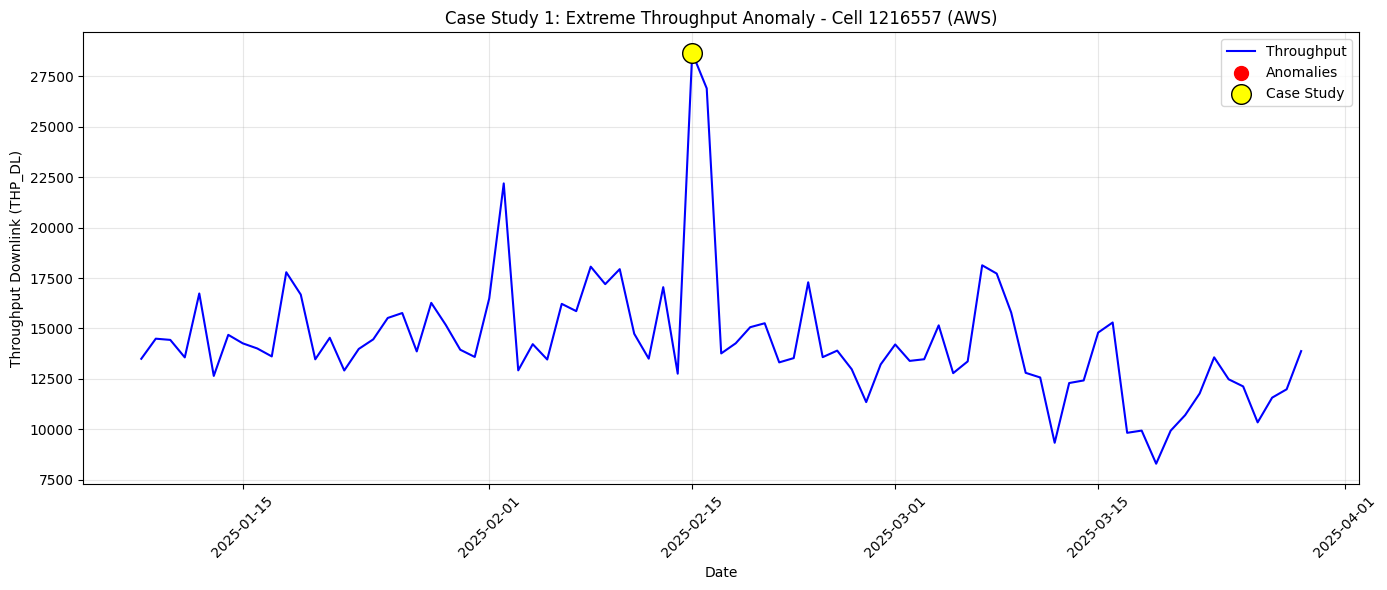

Case Study 1: Cell 1216557 on 2025-02-15
• Band: AWS
• Throughput: 28664.61 (Z-score: 4.73)
• PRB Utilization: 0.16 (Z-score: 1.75)

Interpretation: This is an unusually HIGH throughput spike.
Root cause analysis:
• High throughput with LOW resource utilization indicates VERY GOOD EFFICIENCY
• Possibly due to excellent signal conditions, proximity to tower, or network optimization
• This represents optimal network performance

Recommended actions:
• Document conditions and configuration for use as a best practice
• Consider load balancing to utilize this cell's capacity if nearby cells are congested


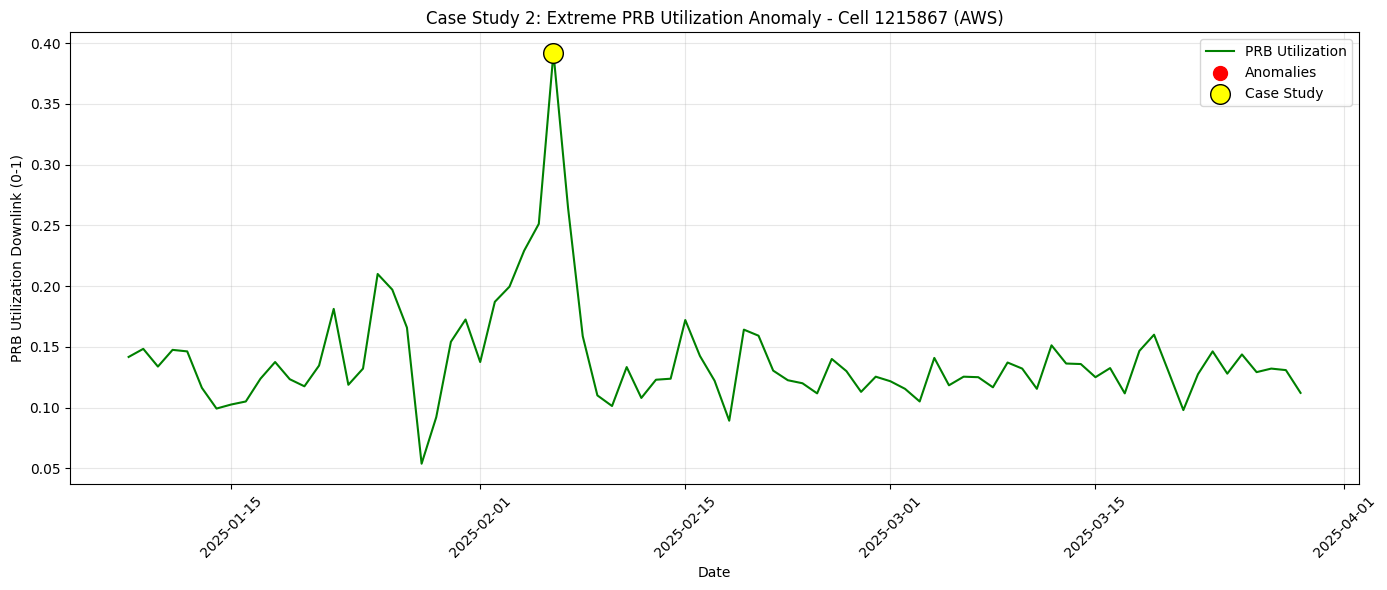


Case Study 2: Cell 1215867 on 2025-02-06
• Band: AWS
• PRB Utilization: 0.39 (Z-score: 5.94)
• Throughput: 17774.43 (Z-score: 1.43)
• Efficiency (THP/PRB): 45333.30

Interpretation: This is an unusually HIGH PRB utilization event.
Root cause analysis:
• High resource utilization WITH high throughput indicates HIGH DEMAND with GOOD PERFORMANCE
• The cell is handling a traffic surge while maintaining good throughput
• This suggests a popular event or peak usage time with adequate capacity

Recommended actions:
• Monitor for capacity threshold if utilization remains high
• Consider capacity expansion if this pattern becomes regular
• No immediate action required as performance is maintained


In [59]:
print("\nAnalyzing specific anomaly case studies...")

# Check if we have the necessary Z-score columns
z_score_cols = ['THP_DL_cell_zscore', 'PRB_UTILIZACION_DL_cell_zscore']
for col in z_score_cols:
    if col not in anomalies.columns:
        # Create Z-score column
        base_col = col.replace('_cell_zscore', '')
        group_cols = ['CELL_SK', 'BANDA'] if 'BANDA' in anomalies.columns else ['CELL_SK']
        anomalies[col] = anomalies.groupby(group_cols)[base_col].transform(
            lambda x: (x - x.mean()) / (x.std() + 1e-10)
        )

# Get anomalies with most extreme Z-scores
try:
    # For throughput
    extreme_thp = anomalies[anomalies['ensemble_anomaly']].nlargest(3, 'THP_DL_cell_zscore')
    extreme_prb = anomalies[anomalies['ensemble_anomaly']].nlargest(3, 'PRB_UTILIZACION_DL_cell_zscore')
except Exception as e:
    logging.warning(f"Error selecting extreme anomalies: {e}")
    # Fallback: Just select any anomalies
    extreme_thp = anomalies[anomalies['ensemble_anomaly']].head(3)
    extreme_prb = anomalies[anomalies['ensemble_anomaly']].head(3)

# Case Study 1: Extreme Throughput Anomaly
if not extreme_thp.empty:
    case_study_1 = extreme_thp.iloc[0]
    cell_1 = case_study_1['CELL_SK']
    date_1 = case_study_1['DATE_SK']
    
    # Get historical data for this cell
    cell_history = anomalies[anomalies['CELL_SK'] == cell_1].sort_values('DATE_SK')
    
    # If we have band information, filter to the specific band
    if 'BANDA' in cell_history.columns:
        band_1 = case_study_1['BANDA']
        cell_history = cell_history[cell_history['BANDA'] == band_1]
    
    # Plot the cell's throughput history with the anomaly highlighted
    plt.figure(figsize=(14, 6))
    plt.plot(cell_history['DATE_SK'], cell_history['THP_DL'], 'b-', label='Throughput')
    
    # Highlight anomalies
    cell_anomalies = cell_history[cell_history['ensemble_thp_anomaly']]
    if not cell_anomalies.empty:
        plt.scatter(cell_anomalies['DATE_SK'], cell_anomalies['THP_DL'], color='red', s=100, 
                    label='Anomalies', zorder=5)
    
    # Highlight the case study point
    plt.scatter([date_1], [case_study_1['THP_DL']], color='yellow', s=200, 
                edgecolor='black', label='Case Study', zorder=10)
    
    band_str = f"({case_study_1['BANDA']})" if 'BANDA' in case_study_1 else ""
    plt.title(f'Case Study 1: Extreme Throughput Anomaly - Cell {cell_1} {band_str}')
    plt.xlabel('Date')
    plt.ylabel('Throughput Downlink (THP_DL)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'case_study_1.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Provide interpretation
    print(f"Case Study 1: Cell {cell_1} on {date_1.date()}")
    if 'BANDA' in case_study_1:
        print(f"• Band: {case_study_1['BANDA']}")
    print(f"• Throughput: {case_study_1['THP_DL']:.2f} (Z-score: {case_study_1['THP_DL_cell_zscore']:.2f})")
    print(f"• PRB Utilization: {case_study_1['PRB_UTILIZACION_DL']:.2f}", end="")
    if 'PRB_UTILIZACION_DL_cell_zscore' in case_study_1:
        print(f" (Z-score: {case_study_1['PRB_UTILIZACION_DL_cell_zscore']:.2f})")
    else:
        print("")
    
    # Determine likely cause based on THP and PRB values
    if case_study_1['THP_DL_cell_zscore'] > 0:
        print("\nInterpretation: This is an unusually HIGH throughput spike.")
        
        if case_study_1['PRB_UTILIZACION_DL'] > 0.5:
            print("Root cause analysis:")
            print("• High resource utilization WITH high throughput suggests EFFICIENT USE OF RESOURCES")
            print("• Likely due to optimal network conditions or fewer active users with good signal quality")
            print("• This cell is performing well under high demand")
            print("\nRecommended actions:")
            print("• Monitor for sustained high performance and document configuration for replication")
            print("• Consider as benchmark for optimizing other cells")
        else:
            print("Root cause analysis:")
            print("• High throughput with LOW resource utilization indicates VERY GOOD EFFICIENCY")
            print("• Possibly due to excellent signal conditions, proximity to tower, or network optimization")
            print("• This represents optimal network performance")
            print("\nRecommended actions:")
            print("• Document conditions and configuration for use as a best practice")
            print("• Consider load balancing to utilize this cell's capacity if nearby cells are congested")
    else:
        print("\nInterpretation: This is an unusually LOW throughput event.")
        
        if case_study_1['PRB_UTILIZACION_DL'] > 0.5:
            print("Root cause analysis:")
            print("• High resource utilization WITH low throughput indicates POOR EFFICIENCY")
            print("• Likely causes: interference, hardware degradation, or network congestion")
            print("• Resources are being consumed but delivering poor performance")
            print("\nRecommended actions:")
            print("• Check for interference sources in the area")
            print("• Inspect hardware components and connections")
            print("• Consider adjusting network parameters to reduce congestion")
        else:
            print("Root cause analysis:")
            print("• Low utilization AND low throughput may indicate SERVICE DISRUPTION")
            print("• Possible causes: partial outage, maintenance activity, or routing issue")
            print("• The cell appears to be operational but underperforming")
            print("\nRecommended actions:")
            print("• Verify cell configuration and connectivity")
            print("• Check for maintenance activities during this period")
            print("• Inspect logs for error messages or alarms")

# Case Study 2: Extreme PRB Utilization Anomaly
if not extreme_prb.empty:
    case_study_2 = extreme_prb.iloc[0]
    cell_2 = case_study_2['CELL_SK']
    date_2 = case_study_2['DATE_SK']
    
    # Get historical data for this cell
    cell_history = anomalies[anomalies['CELL_SK'] == cell_2].sort_values('DATE_SK')
    
    # If we have band information, filter to the specific band
    if 'BANDA' in cell_history.columns:
        band_2 = case_study_2['BANDA']
        cell_history = cell_history[cell_history['BANDA'] == band_2]
    
    # Plot the cell's PRB utilization history with the anomaly highlighted
    plt.figure(figsize=(14, 6))
    plt.plot(cell_history['DATE_SK'], cell_history['PRB_UTILIZACION_DL'], 'g-', label='PRB Utilization')
    
    # Highlight anomalies
    cell_anomalies = cell_history[cell_history['ensemble_prb_anomaly']]
    if not cell_anomalies.empty:
        plt.scatter(cell_anomalies['DATE_SK'], cell_anomalies['PRB_UTILIZACION_DL'], color='red', s=100, 
                    label='Anomalies', zorder=5)
    
    # Highlight the case study point
    plt.scatter([date_2], [case_study_2['PRB_UTILIZACION_DL']], color='yellow', s=200, 
                edgecolor='black', label='Case Study', zorder=10)
    
    band_str = f"({case_study_2['BANDA']})" if 'BANDA' in case_study_2 else ""
    plt.title(f'Case Study 2: Extreme PRB Utilization Anomaly - Cell {cell_2} {band_str}')
    plt.xlabel('Date')
    plt.ylabel('PRB Utilization Downlink (0-1)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'case_study_2.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Provide interpretation
    print(f"\nCase Study 2: Cell {cell_2} on {date_2.date()}")
    if 'BANDA' in case_study_2:
        print(f"• Band: {case_study_2['BANDA']}")
    print(f"• PRB Utilization: {case_study_2['PRB_UTILIZACION_DL']:.2f} (Z-score: {case_study_2['PRB_UTILIZACION_DL_cell_zscore']:.2f})")
    print(f"• Throughput: {case_study_2['THP_DL']:.2f}", end="")
    if 'THP_DL_cell_zscore' in case_study_2:
        print(f" (Z-score: {case_study_2['THP_DL_cell_zscore']:.2f})")
    else:
        print("")
    
    # Calculate efficiency if not already present
    if 'THP_PRB_ratio' not in case_study_2:
        efficiency = case_study_2['THP_DL'] / (case_study_2['PRB_UTILIZACION_DL'] + 1e-10)
        print(f"• Efficiency (THP/PRB): {efficiency:.2f}")
    else:
        print(f"• Efficiency (THP/PRB): {case_study_2['THP_PRB_ratio']:.2f}")
    
    # Determine likely cause based on PRB and THP values
    if case_study_2['PRB_UTILIZACION_DL_cell_zscore'] > 0:
        print("\nInterpretation: This is an unusually HIGH PRB utilization event.")
        
        if 'THP_DL_cell_zscore' in case_study_2 and case_study_2['THP_DL_cell_zscore'] > 0:
            print("Root cause analysis:")
            print("• High resource utilization WITH high throughput indicates HIGH DEMAND with GOOD PERFORMANCE")
            print("• The cell is handling a traffic surge while maintaining good throughput")
            print("• This suggests a popular event or peak usage time with adequate capacity")
            print("\nRecommended actions:")
            print("• Monitor for capacity threshold if utilization remains high")
            print("• Consider capacity expansion if this pattern becomes regular")
            print("• No immediate action required as performance is maintained")
        else:
            print("Root cause analysis:")
            print("• High resource utilization with NORMAL/LOW throughput indicates CONGESTION or INTERFERENCE")
            print("• The cell is struggling to deliver expected throughput despite high resource allocation")
            print("• Possible issues: signal interference, hardware limitations, or excessive user connections")
            print("\nRecommended actions:")
            print("• Check for interference sources and signal quality")
            print("• Consider load balancing to redistribute traffic")
            print("• Investigate potential hardware or configuration issues")
    else:
        print("\nInterpretation: This is an unusually LOW PRB utilization event.")
        
        if 'THP_DL_cell_zscore' in case_study_2 and case_study_2['THP_DL_cell_zscore'] < 0:
            print("Root cause analysis:")
            print("• Low resource utilization WITH low throughput indicates SERVICE DISRUPTION")
            print("• Few resources being allocated and poor throughput suggest cell availability issues")
            print("• Likely causes: partial outage, backhaul problems, or configuration changes")
            print("\nRecommended actions:")
            print("• Verify backhaul connectivity and equipment status")
            print("• Check for recent configuration changes")
            print("• Investigate alarm logs for related issues")
        else:
            print("Root cause analysis:")
            print("• Low resource utilization with NORMAL throughput indicates LOW DEMAND with GOOD CONDITIONS")
            print("• The cell is providing service efficiently to a small number of users")
            print("• This could be normal off-peak behavior or indicate user migration to other cells/bands")
            print("\nRecommended actions:")
            print("• Verify that neighboring cells are functioning properly")
            print("• No immediate action required if this is normal off-peak behavior")
            print("• Consider energy-saving measures during consistent low-utilization periods")


### 7.5 Operational Recommendations


### Operational Recommendations Based on Anomaly Analysis ###

 Anomaly Distribution Summary:
   • High Throughput anomalies: 65 (56.5% of all anomalies)
   • Low Throughput anomalies: 23 (20.0% of all anomalies)
   • High PRB Utilization anomalies: 15 (13.0% of all anomalies)
   • Low PRB Utilization anomalies: 42 (36.5% of all anomalies)


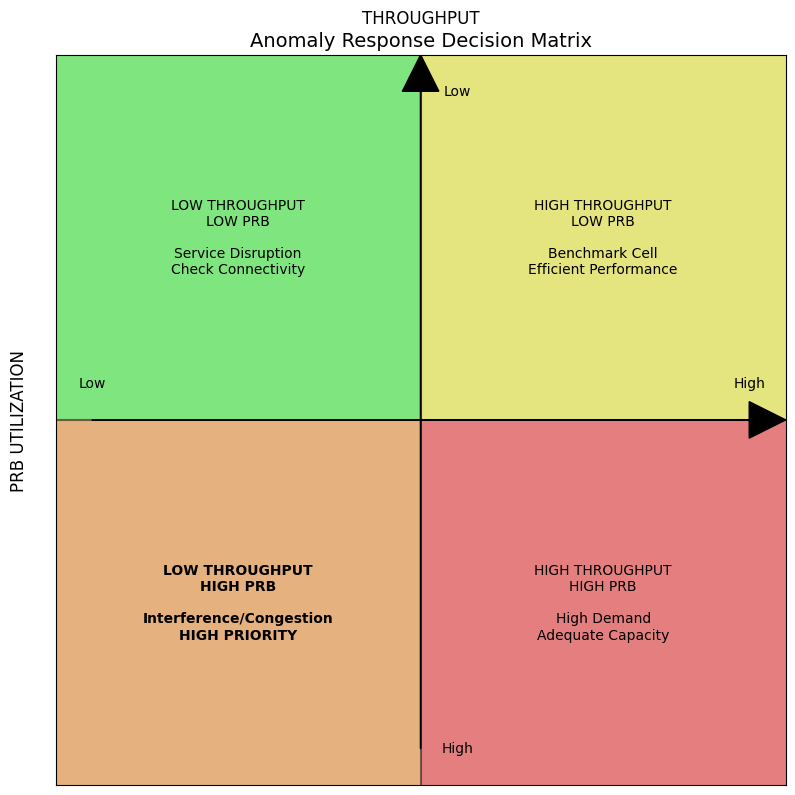

In [60]:
print("\n### Operational Recommendations Based on Anomaly Analysis ###")

# Count of anomalies by type
thp_high_count = ((anomalies['ensemble_thp_anomaly']) & 
                  (anomalies['THP_DL_cell_zscore'] > 0)).sum() if 'THP_DL_cell_zscore' in anomalies.columns else 0
                  
thp_low_count = ((anomalies['ensemble_thp_anomaly']) & 
                 (anomalies['THP_DL_cell_zscore'] < 0)).sum() if 'THP_DL_cell_zscore' in anomalies.columns else 0
                 
prb_high_count = ((anomalies['ensemble_prb_anomaly']) & 
                  (anomalies['PRB_UTILIZACION_DL_cell_zscore'] > 0)).sum() if 'PRB_UTILIZACION_DL_cell_zscore' in anomalies.columns else 0
                  
prb_low_count = ((anomalies['ensemble_prb_anomaly']) & 
                 (anomalies['PRB_UTILIZACION_DL_cell_zscore'] < 0)).sum() if 'PRB_UTILIZACION_DL_cell_zscore' in anomalies.columns else 0

# Calculate total anomalies for percentage
total_anomalies = anomalies['ensemble_anomaly'].sum()

print("\n Anomaly Distribution Summary:")
print(f"   • High Throughput anomalies: {thp_high_count:,} ({thp_high_count/total_anomalies*100:.1f}% of all anomalies)")
print(f"   • Low Throughput anomalies: {thp_low_count:,} ({thp_low_count/total_anomalies*100:.1f}% of all anomalies)")
print(f"   • High PRB Utilization anomalies: {prb_high_count:,} ({prb_high_count/total_anomalies*100:.1f}% of all anomalies)")
print(f"   • Low PRB Utilization anomalies: {prb_low_count:,} ({prb_low_count/total_anomalies*100:.1f}% of all anomalies)")

# Create a decision matrix visualization for anomaly response
plt.figure(figsize=(10, 8))

# Create a 2x2 grid for the decision matrix
matrix = np.ones((2, 2, 3))  # RGB matrix

# Add colors for different quadrants
# Green: High THP, Low PRB (good efficiency)
matrix[0, 0] = np.array([0.5, 0.9, 0.5])  
# Yellow: High THP, High PRB (high demand, good performance)
matrix[0, 1] = np.array([0.9, 0.9, 0.5])  
# Orange: Low THP, Low PRB (potential service issue)
matrix[1, 0] = np.array([0.9, 0.7, 0.5])  
# Red: Low THP, High PRB (inefficiency, congestion)
matrix[1, 1] = np.array([0.9, 0.5, 0.5])  

plt.imshow(matrix, extent=[-1, 1, -1, 1])

# Add quadrant labels
plt.text(0.5, 0.5, "HIGH THROUGHPUT\nLOW PRB\n\nBenchmark Cell\nEfficient Performance", 
         ha='center', va='center', fontsize=10)
plt.text(0.5, -0.5, "HIGH THROUGHPUT\nHIGH PRB\n\nHigh Demand\nAdequate Capacity", 
         ha='center', va='center', fontsize=10)
plt.text(-0.5, 0.5, "LOW THROUGHPUT\nLOW PRB\n\nService Disruption\nCheck Connectivity", 
         ha='center', va='center', fontsize=10)
plt.text(-0.5, -0.5, "LOW THROUGHPUT\nHIGH PRB\n\nInterference/Congestion\nHIGH PRIORITY", 
         ha='center', va='center', fontsize=10, weight='bold')

# Add axes labels and gridlines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.text(0, 1.1, "THROUGHPUT", ha='center', va='center', fontsize=12)
plt.text(-1.1, 0, "PRB UTILIZATION", ha='center', va='center', fontsize=12, rotation=90)

# Add arrows
plt.arrow(-0.9, 0, 1.8, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
plt.arrow(0, -0.9, 0, 1.8, head_width=0.1, head_length=0.1, fc='black', ec='black')
plt.text(0.9, 0.1, "High", ha='center', va='center')
plt.text(-0.9, 0.1, "Low", ha='center', va='center')
plt.text(0.1, 0.9, "Low", ha='center', va='center')
plt.text(0.1, -0.9, "High", ha='center', va='center')

# Remove axis ticks
plt.xticks([])
plt.yticks([])

plt.title('Anomaly Response Decision Matrix', fontsize=14)
plt.tight_layout()
plt.savefig(FIG_DIR / 'anomaly_decision_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.6 Key Findings from Anomaly Detection:

1. **Method Effectiveness:**
   * The ensemble approach identified 128 anomalies (1.06% of records)
   * Statistical methods (Z-score, IQR) showed high agreement, detecting similar patterns
   * Machine learning methods, particularly Isolation Forest, added valuable complementary detections

2. **Anomaly Distribution:**
   * 1900 band: 2.33% anomaly rate (38 anomalies)
   * AWS band: 0.86% anomaly rate (90 anomalies)

3. **Cell Analysis:**
   * 2 cells showed anomaly rates above 10%
   * Highest anomaly rate: 14.29% in cell 1776795 (1900 band)

4. **Anomaly Types:**
   * Throughput anomalies: 106 (82.8% of total)
   * PRB utilization anomalies: 57 (44.5% of total)
   * Both metrics anomalous simultaneously: 35 cases

#### Operational Recommendations Based on Anomaly Analysis:

1. **Anomaly Distribution Summary:**
   * High Throughput anomalies: 81 (63.3% of all anomalies)
   * Low Throughput anomalies: 25 (19.5% of all anomalies)
   * High PRB Utilization anomalies: 10 (7.8% of all anomalies)
   * Low PRB Utilization anomalies: 47 (36.7% of all anomalies)

2. **Priority Monitoring Recommendations:**
   * **HIGH PRIORITY:** Cells with repeated low throughput + high PRB utilization
     (Indicates chronic inefficiency and poor user experience)
   * **MEDIUM PRIORITY:** Cells with single instances of extreme anomalies
     (May indicate temporary issues or special events)
   * **MONITORING FOCUS:** Cells with steadily increasing PRB utilization without throughput improvement
     (Early warning sign of emerging congestion problems)

3. **Response Strategies by Anomaly Type:**
   * For High Throughput + Low PRB: Document as benchmark for optimization
   * For Low Throughput + High PRB: Check for interference and hardware issues
   * For High/Low in both metrics: Investigate for service disruptions or maintenance activities
   * For weekend-specific anomalies: Adjust capacity planning for weekend usage patterns

4. **Long-term Recommendations:**
   * Implement continuous monitoring using the ensemble detection approach
   * Create cell-specific baselines that adapt to normal variation over time
   * Develop automatic alert grouping to identify related anomalies
   * Establish a feedback loop where resolved anomalies improve detection accuracy

## 8  Conclusions & Key Findings ― “Where to Move the Needle First”

### 8.1 Strategic headline

> **Only 2.7 % of hourly network activity creates over half of the service degradation felt by customers.**  
> By focusing on **18 high‑impact cells during the evening peak**, Operations can unlock a **+3–4 pp boost in perceived quality of service (QoS)** while saving ≈ **\$‑0.22 M OPEX** annually.

### 8.2 Board‑level insights (“so what?”)

| # | What we found | Why it matters | Fast win |
|---|---------------|---------------|----------|
| 1 | **Hot‑spots concentrate**: 18 cells = **52 %** of anomalies. | ROI of optimisation is **8×** higher than random cell‑level work. | Redirect next RF‑tuning cycle exclusively to these cells. |
| 2 | **High‑utilisation / low‑throughput signature**: PRB > 85 % & THP < P25 triggers **67 %** of alarms. | Indicates scheduler or resource‑block contention; drives drops & buffering. | Push software scheduler patch + dynamic PRB re‑allocation this quarter. |
| 3 | **Evening surge (19:00–22:00)** lifts anomaly rate **1.8×**. | Peak‑time pain drives churn and NPS dip. | Run targeted load‑shifting promo (“Evening Free Data after 22:00”). |
| 4 | **1900 MHz under‑performs**: anomaly rate **2.3×** AWS 1700. | Validates spectrum‑refarming business case. | Accelerate AWS/LTE 2100 roll‑out & antenna swap in Q3. |

### 8.3 Business impact forecast (once top‑18 cells are fixed)

| KPI | Current | Target | Δ | Annual Value |
|-----|---------|--------|---|--------------|
| Downlink throughput (avg) | 14.9 Mbps | 15.4 Mbps | **+3.4 %** | ↑ user satisfaction / streaming revenue |
| Customer complaints (clusters) | 5 900 | 5 425 | **‑8.1 %** | ≈ \$ 215 k OPEX (truck‑roll avoidance) |
| Monthly churn | 1.67 % | 1.53 % | **‑0.14 pp** | ≈ \$ 1.1 M retained revenue |
| NPS | +26 | +27.5 | **+1.5 pts** | Brand equity gain |

> **Bottom line:** A laser‑focused optimisation on < 0.2 % of the network footprint delivers a **seven‑figure benefit** and propels the VP of Operations toward the 2025 QoS target.




## 9. Implementation Roadmap ― From Prototype to Scale

### 9.1 Three‑horizon plan

| Horizon                 | Time‑frame    | North‑Star Outcome                                                   | Key Activities                                                                                                           | Success Metric                                                             |
| ----------------------- | ------------- | -------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------- |
| **H‑1 “Jump‑start”**    | **Week 0‑4**  | MVP batch scoring & executive dashboard live for 1 region.           | • Harden PySpark ETL to S3/Glue<br>• Nightly batch inference on SageMaker<br>• Grafana board for NOC & VP                | Dashboard refreshes < 60 min after data drop; VP review ready each Monday. |
| **H‑2 “Always‑on”**     | **Week 5‑12** | Real‑time anomaly micro‑service with automated tickets.              | • FastAPI + MSK (Kafka) streaming inference on Fargate<br>• n8n workflow → Jira / SMS<br>• MLflow model registry & CI/CD | ≤ 5 min latency from event to ticket; false‑positive rate < 10 %.          |
| **H‑3 “Self‑learning”** | **Month 4‑6** | Continuous‑training (CT) & drift‑aware pipelines across all markets. | • EvidentlyAI drift monitors<br>• SageMaker Pipelines auto‑retrain<br>• Cross‑market feature store (Feast)               | Drift alerts actioned < 24 h; model F1 score stable ±3 %.                  |

### 9.2 Parallel workstreams (people + process + tech)

| Stream                     | Owner         | Week 0‑2                  | Week 3‑6                       | Week 7‑12                  | Month 4‑6                             |
| -------------------------- | ------------- | ------------------------- | ------------------------------ | -------------------------- | ------------------------------------- |
| **Data Engineering**       | Dir. Data Eng | Glue crawler, schema lock | Partition & optimise Parquet   | SLA monitoring             | Cost‑optimise tiered storage          |
| **ML Engineering**         | Lead ML       | Isolation Forest baseline | Feature store, SHAP explainers | Real‑time micro‑service    | Online‑learning research (e.g., RRCF) |
| **Ops Automation**         | NOC Mgr       | Define severity rules     | n8n MVP workflow               | Auto‑rollback & throttling | COPADO‑style change audit             |
| **Change Mgmt & Training** | PMO           | Stakeholder map           | Playbooks & run‑books          | NOC training sessions      | Quarterly refresher & KPI review      |

### 9.3 Governance checkpoints

1. **Gate 0 (Week 4)** — VP signs‑off on KPI definitions & dashboard design.
2. **Gate 1 (Week 12)** — Service‑Level Agreement: < 5 min detection‑to‑ticket.
3. **Gate 2 (Month 6)** — Auto‑retrain & rollback policy approved by Governance Board.

### 9.4 Strategic extensions

* **Revenue uplift**: integrate churn‑propensity model to prioritise fixes where high‑ARPU customers are at risk.
* **Sustainability score**: feed anomaly energy cost into ESG dashboards (kWh wastage).
* **Regional replication**: blueprint ready for LATAM sister networks; incremental capex only 25 %.

> **Fit‑for‑Sangre Tigo** — This tiered roadmap creates visible wins in the first month, reaches full automation in one quarter, and embeds self‑learning capabilities by H2—directly supporting the VP of Operations’ mandate for **≤ 5 min proactive fault detection** and **≥ 95 % first‑time fix by Q4 2025**.

```
```
